# Projet P5 : Segmentez des clients d'un site e-commerce

## Contexte

Vous êtes consultant pour Olist, une entreprise brésilienne qui propose une solution de vente sur les marketplaces en ligne.

Votre rôle est d’accompagner Olist dans leur projet de monter une équipe Data et leur premier cas d’usage Data Science autour de la segmentation client.

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.
 
Vous devrez fournir à l’équipe Marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

La segmentation proposée doit être exploitable et facile d’utilisation par notre équipe Marketing. Elle doit au minimum pouvoir différencier les bons et moins bons clients en termes de commandes et de satisfaction. Nous attendons bien sûr une segmentation sur l’ensemble des clients.

Dans un deuxième temps, une fois le modèle de segmentation choisi, nous souhaiterions que vous nous fassiez une recommandation de fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente, afin de pouvoir effectuer un devis de contrat de maintenance.

Pour information, le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.

Les données
Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique des commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

## Etapes du projet :

Création d'une segmentation Marketing des clients et recommandation de fréquence à laquelle la segmentation doit être mise à jour.

- <b> Etape préliminaire : </b> Importation des données et description des fichiers ( --> NoteBook1 : Clustering )
- <b> Etape 1 : </b> Analyse exploratoire et feature engineering ( --> NoteBook1 : Clustering ) 
- <b> Etape 2 : </b> Elaboration d'un modèle de clustering ( --> NoteBook1 : Clustering )
- <b> Etape 3 : </b> Simulation d'évolution de la stabilité du clustering ( --> NoteBook2 : Simulation )

## Etape préliminaire : Importation des données et description des fichiers

ETAPE 0
- collecter et préparer les données dans un dataframe
- mettre en place un environnement de travail configuré avec les bibliothèques de traitement de données et de machine learning

### Environnement de travail et librairies

In [1]:
# Message d'erreur qui indique que la bibliothèque joblib a des difficultés à déterminer le nombre de 
# cœurs physiques de la machine.
# Pour connaitre le nb de coeurs :
# import psutil

# Obtenir le nombre de cœurs physiques = 14
# physical_cores = psutil.cpu_count(logical=False)
# print(f"Nombre de cœurs physiques : {physical_cores}")

# Obtenir le nombre de cœurs logiques = 20
# logical_cores = psutil.cpu_count(logical=True)
# print(f"Nombre de cœurs logiques : {logical_cores}")

In [ ]:
import os
# Définir le nombre de cœurs que vous souhaitez utiliser
os.environ['LOKY_MAX_CPU_COUNT'] = '14'
# Importer les autres bibliothèques après avoir défini la variable d'environnement
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import scipy.stats as st

# Pour l'analyse des valeurs manquantes - installation du package via anaconda navigator
import missingno as msno

# Pour adapter les étiquettes de texte sur les graphs
from adjustText import adjust_text

# Pour les représentations de cartes
import folium 

# Pour formater les chiffres sur un axe d'un graphique en notation scientifique
from matplotlib.ticker import ScalarFormatter

# Imputation des valeurs manquantes 
from sklearn.impute import KNNImputer

# Standardiser les données
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

# Reduction de dimensions
from sklearn import decomposition
from sklearn import manifold

# Clustering
from sklearn import cluster, metrics
from scipy.cluster.hierarchy import dendrogram

sns.set_palette('Set3')

### Importation des données

In [3]:
fichiers_csv = ('olist_customers_dataset', 'olist_geolocation_dataset', 'olist_order_items_dataset',
                'olist_order_payments_dataset', 'olist_order_reviews_dataset', 'olist_orders_dataset',
                'olist_products_dataset', 'olist_sellers_dataset', 'product_category_name_translation')

# Dictionnaire pour stocker les DataFrames
dataframes = {}

for fichier in fichiers_csv:
    # Nom du fichier CSV
    csv_file = f"C:\\Users\\druar\\OneDrive\\Documents\\01_Formations\\1_Outils_ET_Metier\\2024_DataScientist\\ProjetsPython\\P5\\data\\{fichier}.csv"
    
    # Lire le fichier CSV
    df = pd.read_csv(csv_file)
    
    # Stocker le DataFrame dans le dictionnaire
    dataframes[fichier] = df
    
    # Afficher le nombre de lignes et de colonnes
    print(f"Le fichier {fichier} a {df.shape[1]} colonnes et {df.shape[0]} lignes")

olist_customers_dataset = dataframes['olist_customers_dataset']
olist_geolocation_dataset = dataframes['olist_geolocation_dataset']
olist_order_items_dataset = dataframes['olist_order_items_dataset']
olist_order_payments_dataset = dataframes['olist_order_payments_dataset']
olist_order_reviews_dataset = dataframes['olist_order_reviews_dataset']
olist_orders_dataset = dataframes['olist_orders_dataset']
olist_products_dataset = dataframes['olist_products_dataset']
olist_sellers_dataset = dataframes['olist_sellers_dataset']
product_category_name_translation = dataframes['product_category_name_translation']

Le fichier olist_customers_dataset a 5 colonnes et 99441 lignes
Le fichier olist_geolocation_dataset a 5 colonnes et 1000163 lignes
Le fichier olist_order_items_dataset a 7 colonnes et 112650 lignes
Le fichier olist_order_payments_dataset a 5 colonnes et 103886 lignes
Le fichier olist_order_reviews_dataset a 7 colonnes et 99224 lignes
Le fichier olist_orders_dataset a 8 colonnes et 99441 lignes
Le fichier olist_products_dataset a 9 colonnes et 32951 lignes
Le fichier olist_sellers_dataset a 4 colonnes et 3095 lignes
Le fichier product_category_name_translation a 2 colonnes et 71 lignes


## ETAPE 1 : Analyse exploratoire des datasets et premiers feature engineering

ETAPE 1
1. Analyse descriptives des données 
2. Création de la base clients & feature engineering - création de nouvelles variables, traitement des valeurs manquantes
   - variables RFM :
      - Nb de commandes par client
      - Montant du paiement
      - Ancienneté de la dernière commande
   - variables AUTRES :
      - Latitude - longitude
      - Types de paiements du client
      - Paiement en plusieurs fois
      - Note minimale donnée par un client
      - Client a laissé un commentaire
      - Au moins un produit de telle catégorie (73 catégories)

### 1. Analyse descriptives des données

#### Dataset CUSTOMERS

In [4]:
olist_customers_dataset.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [5]:
# Infos sur les variables de la table :
print("-"*20)
print("customer_id")
print(f"Nb : {olist_customers_dataset['customer_id'].count()}")
print(f"Nb unique : {olist_customers_dataset['customer_id'].nunique()}")
print("-"*20)
print("customer_unique_id")
print(f"Nb : {olist_customers_dataset['customer_unique_id'].count()}")
print(f"Nb unique : {olist_customers_dataset['customer_unique_id'].nunique()}")
print("-"*20)
print("customer_zip_code_prefix")
print(olist_customers_dataset['customer_zip_code_prefix'].count())
print(olist_customers_dataset['customer_zip_code_prefix'].describe())
print("-"*20)
print("customer_city")
print(olist_customers_dataset['customer_city'].count())
effectifs = olist_customers_dataset['customer_city'].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['customer_city']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
print(tab.head())
print("-"*20)
print("customer_state")
print(olist_customers_dataset['customer_state'].count())
effectifs = olist_customers_dataset['customer_state'].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['customer_state']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
print(tab.head())

--------------------
customer_id
Nb : 99441
Nb unique : 99441
--------------------
customer_unique_id
Nb : 99441
Nb unique : 96096
--------------------
customer_zip_code_prefix
99441
count    99441.000000
mean     35137.474583
std      29797.938996
min       1003.000000
25%      11347.000000
50%      24416.000000
75%      58900.000000
max      99990.000000
Name: customer_zip_code_prefix, dtype: float64
--------------------
customer_city
99441
    customer_city      n
0       sao paulo  15540
1  rio de janeiro   6882
2  belo horizonte   2773
3        brasilia   2131
4        curitiba   1521
--------------------
customer_state
99441
  customer_state      n
0             SP  41746
1             RJ  12852
2             MG  11635
3             RS   5466
4             PR   5045


In [6]:
# Supprimer les doublons en utilisant la colonne 'customer_id_unique'
olist_customers_dataset_deduplicated = olist_customers_dataset.drop_duplicates(subset='customer_unique_id')

# Afficher le nombre de lignes avant et après le dédoublonnage
print(f"Nombre de lignes avant dédoublonnage: {olist_customers_dataset.shape[0]}")
print(f"Nombre de lignes après dédoublonnage: {olist_customers_dataset_deduplicated.shape[0]}")

Nombre de lignes avant dédoublonnage: 99441
Nombre de lignes après dédoublonnage: 96096


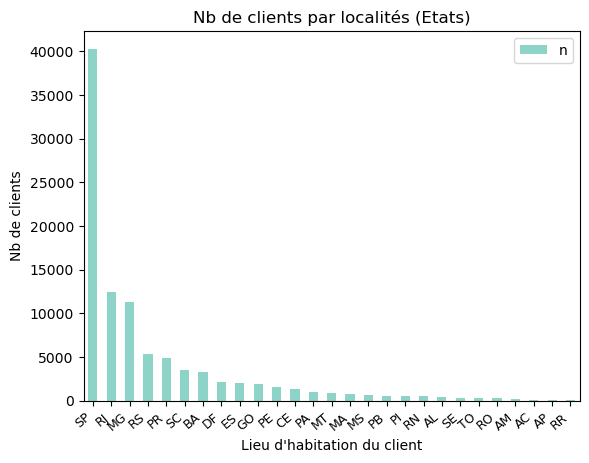

In [7]:
effectifs = olist_customers_dataset_deduplicated['customer_state'].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['customer_state']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab.plot(kind='bar',y='n',x='customer_state')
plt.xticks(rotation=40, fontsize=9, ha='right')
plt.xlabel("Lieu d'habitation du client")
plt.ylabel('Nb de clients')
plt.title('Nb de clients par localités (Etats)')
plt.show()

In [ ]:
# Conserver la longitude et latitude de la table geolocation et renommer le zip_code
ref_geoloc = olist_geolocation_dataset[['geolocation_zip_code_prefix','geolocation_lat','geolocation_lng']]
ref_geoloc = ref_geoloc.rename(columns={'geolocation_zip_code_prefix': 'customer_zip_code_prefix'})

# Fusionnez les données des clients uniques avec la géolocalisation pour récupérer la longitude et latitude
# Créer des dictionnaires de mappage pour latitude et longitude
lat_mapping = ref_geoloc.set_index('customer_zip_code_prefix')['geolocation_lat'].to_dict()
lng_mapping = ref_geoloc.set_index('customer_zip_code_prefix')['geolocation_lng'].to_dict()
# Ajouter les colonnes 'geolocation_lat' et 'geolocation_lng' à olist_customers_dataset_deduplicated
olist_customers_dataset_deduplicated['geolocation_lat'] = olist_customers_dataset_deduplicated['customer_zip_code_prefix'].map(lat_mapping)
olist_customers_dataset_deduplicated['geolocation_lng'] = olist_customers_dataset_deduplicated['customer_zip_code_prefix'].map(lng_mapping)

In [9]:
olist_customers_dataset_deduplicated.shape

(96096, 7)

In [10]:
# Représenter les clients sur une carte avec leur longitude et latitude 
# On supprime les clients sans longitude / latitude : 
olist_customers_dataset_deduplicated_cleaned = olist_customers_dataset_deduplicated.dropna(subset=['geolocation_lat'])
olist_customers_dataset_deduplicated_cleaned = olist_customers_dataset_deduplicated.dropna(subset=['geolocation_lng'])
# Coordonnées initiales de la carte (moyenne des coordonnées)
mean_longitude = olist_customers_dataset_deduplicated_cleaned['geolocation_lat'].median()
mean_latitude = olist_customers_dataset_deduplicated_cleaned['geolocation_lng'].median()

In [11]:
# Création de la carte
m = folium.Map(location=[-23.5, -46.6], zoom_start=10)

In [12]:
# Représentation de chaque client par un point sur la carte

# Paramètres du marqueur
radius = 2

# Ajout des marqueurs pour chaque point dans le DataFrame
for i in olist_customers_dataset_deduplicated_cleaned.index:
    folium.CircleMarker(
        location=[olist_customers_dataset_deduplicated_cleaned.loc[i, 'geolocation_lat'], olist_customers_dataset_deduplicated_cleaned.loc[i, 'geolocation_lng']],
        radius=radius,
        stroke=False,
        fill=True,
        fill_opacity=0.6,
        opacity=1,
    ).add_to(m)

# Affichage de la carte
# m

In [13]:
# Afficher les lignes où 'geolocation_lat' est NaN
missing_geolocation_lat = olist_customers_dataset_deduplicated[olist_customers_dataset_deduplicated['geolocation_lat'].isna()]
# Afficher les résultats
missing_geolocation_lat.shape

(268, 7)

<div class="alert alert-block alert-info">
    <b> A RETENIR : </b> 
    
- un customer_id correspond à un client ayant effectué une commande (équivaut à order_id)
- pour avoir les clients uniques il faut dédoublonner la base et se reférer à customer_unique_id, ont a 99 441 commandes qui ont été faites par 96 096 clients.
- les longitudes et latitudes sont manquantes pour 268 clients, on pourra faire un remplacement de ces valeurs manquantes par KNN basé sur la variable zip_code et ville, il s'agit souvent de codes proches mais pas exactes
    
</div>

#### Dataset ORDERS

In [14]:
olist_orders_dataset.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [15]:
# Infos sur les variables de la table :
print("-"*20)
print("order_id")
print(f"Nb : {olist_orders_dataset['order_id'].count()}")
print(f"Nb unique : {olist_orders_dataset['order_id'].nunique()}")
print("-"*20)
print("customer_id")
print(f"Nb : {olist_orders_dataset['customer_id'].count()}")
print(f"Nb unique : {olist_orders_dataset['customer_id'].nunique()}")
print("-"*20)
print("order_status")
print(olist_orders_dataset['order_status'].count())
effectifs = olist_orders_dataset['order_status'].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['order_status']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/olist_orders_dataset['order_status'].count())*100
print(tab.head(10))
print("-"*20)
print("order_purchase_timestamp")
print(olist_orders_dataset['order_purchase_timestamp'].count())
print(olist_orders_dataset['order_purchase_timestamp'].describe())

--------------------
order_id
Nb : 99441
Nb unique : 99441
--------------------
customer_id
Nb : 99441
Nb unique : 99441
--------------------
order_status
99441
  order_status      n          %
0    delivered  96478  97.020344
1      shipped   1107   1.113223
2     canceled    625   0.628513
3  unavailable    609   0.612423
4     invoiced    314   0.315765
5   processing    301   0.302692
6      created      5   0.005028
7     approved      2   0.002011
--------------------
order_purchase_timestamp
99441
count                   99441
unique                  98875
top       2018-04-11 10:48:14
freq                        3
Name: order_purchase_timestamp, dtype: object


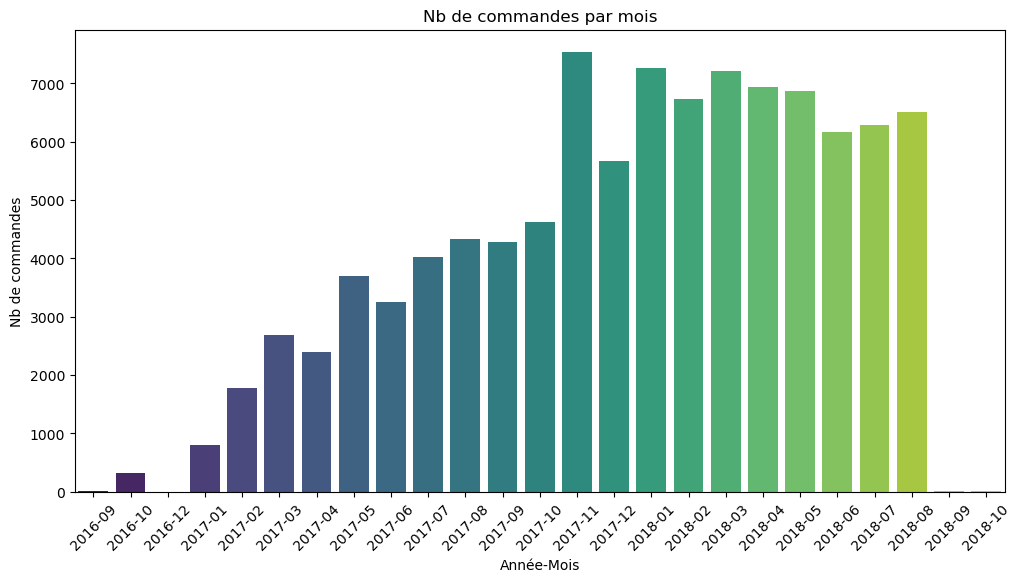

In [16]:
# Convertir la colonne 'order_purchase_timestamp' en datetime
olist_orders_dataset['order_purchase_timestamp'] = pd.to_datetime(olist_orders_dataset['order_purchase_timestamp'])
# Extraire l'année et le mois
olist_orders_dataset['year_month'] = olist_orders_dataset['order_purchase_timestamp'].dt.to_period('M')
# Nombre de commandes par mois
order_counts = olist_orders_dataset['year_month'].value_counts().sort_index()
# Créer le barplot
plt.figure(figsize=(12, 6))
sns.barplot(x=order_counts.index.astype(str), y=order_counts.values, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Année-Mois')
plt.ylabel('Nb de commandes')
plt.title('Nb de commandes par mois')
plt.show()

#### Dataset ORDER PAYMENTS

In [17]:
olist_order_payments_dataset.columns

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [18]:
# Infos sur les variables de la table :
print("-"*20)
print("order_id")
print(f"Nb : {olist_order_payments_dataset['order_id'].count()}")
print(f"Nb unique : {olist_order_payments_dataset['order_id'].nunique()}")
print("-"*20)
print("payment_sequential")
print(olist_order_payments_dataset['payment_sequential'].count())
effectifs = olist_order_payments_dataset['payment_sequential'].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['payment_sequential']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/olist_order_payments_dataset['payment_sequential'].count())*100
print(tab.head())
print("-"*20)
print("payment_type")
print(olist_order_payments_dataset['payment_type'].count())
effectifs = olist_order_payments_dataset['payment_type'].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['payment_type']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/olist_order_payments_dataset['payment_type'].count())*100
print(tab.head())
print("payment_installments")
print(olist_order_payments_dataset['payment_installments'].count())
effectifs = olist_order_payments_dataset['payment_installments'].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['payment_installments']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/olist_order_payments_dataset['payment_installments'].count())*100
print(tab.head(10))
print("payment_value")
print(olist_order_payments_dataset['payment_value'].count())
print(olist_order_payments_dataset['payment_value'].describe())

--------------------
order_id
Nb : 103886
Nb unique : 99440
--------------------
payment_sequential
103886
   payment_sequential      n          %
0                   1  99360  95.643301
1                   2   3039   2.925322
2                   3    581   0.559267
3                   4    278   0.267601
4                   5    170   0.163641
--------------------
payment_type
103886
  payment_type      n          %
0  credit_card  76795  73.922376
1       boleto  19784  19.043952
2      voucher   5775   5.558978
3   debit_card   1529   1.471806
4  not_defined      3   0.002888
payment_installments
103886
   payment_installments      n          %
0                     1  52546  50.580444
1                     2  12413  11.948675
2                     3  10461  10.069692
3                     4   7098   6.832489
4                    10   5328   5.128699
5                     5   5239   5.043028
6                     8   4268   4.108350
7                     6   3920   3.773367
8       

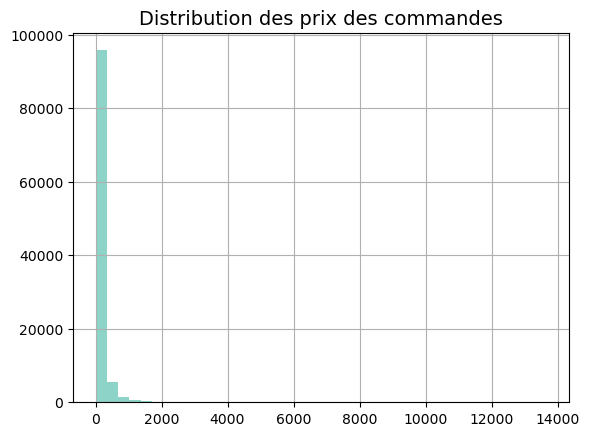

In [19]:
# 1000 BRL équivaut à environ 173,83 EUR.
olist_order_payments_dataset['payment_value'].hist(bins=40)
plt.title("Distribution des prix des commandes",fontsize=14)
plt.show()

<div class="alert alert-block alert-info">
    <b> A RETENIR : </b> 
    
- la table olist_order_payments_dataset contient une ligne par séquence de paiement, il peut y avoir plusieurs lignes pour une même commande (id_order) 103886 séquences de paiement pour 99440 commandes.
- les séquences multiples sont souvent associés à des paiement par bons d'achat ou bons cadeaux.
- il faudrait sommer les différentes séquences pour une commande pour avoir le montant global de la commande
    
</div>

#### Dataset PRODUCTS

In [20]:
olist_products_dataset.columns

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

In [21]:
# Infos sur les variables de la table :
print("-"*20)
print("product_id")
print(f"Nb : {olist_products_dataset['product_id'].count()}")
print(f"Nb unique : {olist_products_dataset['product_id'].nunique()}")
print("-"*20)
print("product_category_name")
print(olist_products_dataset['product_category_name'].count())
effectifs = olist_products_dataset['product_category_name'].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
print(f"Nb de catégories de produits : {modalites.shape[0]} catégories différentes")
tab = pd.DataFrame(modalites, columns = ['product_category_name']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/olist_products_dataset['product_category_name'].count())*100
print(tab.head(10))

--------------------
product_id
Nb : 32951
Nb unique : 32951
--------------------
product_category_name
32341
Nb de catégories de produits : 73 catégories différentes
    product_category_name     n         %
0         cama_mesa_banho  3029  9.365820
1           esporte_lazer  2867  8.864908
2        moveis_decoracao  2657  8.215578
3            beleza_saude  2444  7.556971
4   utilidades_domesticas  2335  7.219938
5              automotivo  1900  5.874896
6  informatica_acessorios  1639  5.067871
7              brinquedos  1411  4.362883
8      relogios_presentes  1329  4.109335
9               telefonia  1134  3.506385


<div class="alert alert-block alert-info">
    <b> A RETENIR : </b> 
    
- il y a 73 catégories de produit différentes - attention il y a des produits pour lesquels la catégorie est vide (610 produits)
- on pourra définir le nombre de produits achetés
- les autres informations produit ne serviront pas a priori
    
</div>

#### Dataset REVIEWS

In [22]:
olist_order_reviews_dataset.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [23]:
# Infos sur les variables de la table :
print("-"*20)
print("review_id")
print(f"Nb : {olist_order_reviews_dataset['review_id'].count()}")
print(f"Nb unique : {olist_order_reviews_dataset['review_id'].nunique()}")
print("-"*20)
print("review_score")
print(olist_order_reviews_dataset['review_score'].count())
effectifs = olist_order_reviews_dataset['review_score'].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['review_score']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/olist_order_reviews_dataset['review_score'].count())*100
print(tab.head())
print("-"*20)
print("review_comment_message")
print(f"Nb : {olist_order_reviews_dataset['review_comment_message'].count()}")

--------------------
review_id
Nb : 99224
Nb unique : 98410
--------------------
review_score
99224
   review_score      n          %
0             5  57328  57.776344
1             4  19142  19.291704
2             1  11424  11.513344
3             3   8179   8.242965
4             2   3151   3.175643
--------------------
review_comment_message
Nb : 40977


### 2. Création de la base clients & feature engineering

#### 0. Filtre sur la période 01/2017 --> 08/2018

In [24]:
# Filtre sur les commandes 01/2017 - 08/2018
olist_orders_dataset_filtered = olist_orders_dataset.loc[(olist_orders_dataset['year_month'] > '2016-12') & (olist_orders_dataset['year_month'] < '2018-09')]
# Filtre sur les commandes livrées
olist_orders_dataset_filtered = olist_orders_dataset_filtered.loc[(olist_orders_dataset_filtered['order_status'] == "delivered")]
olist_orders_dataset_filtered.shape

(96211, 9)

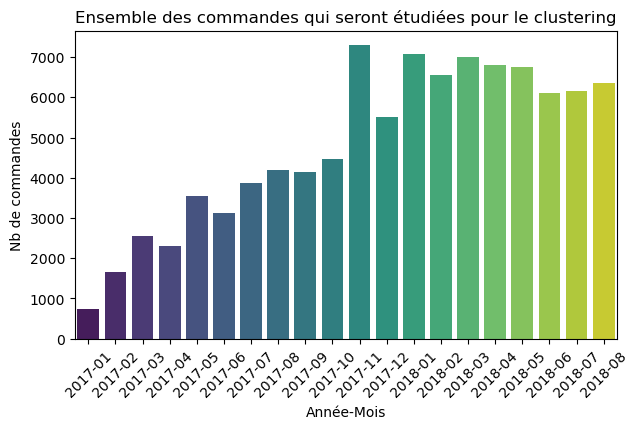

In [25]:
# Nombre de commandes par mois
order_counts = olist_orders_dataset_filtered['year_month'].value_counts().sort_index()
# Créer le barplot
plt.figure(figsize=(7, 4))
sns.barplot(x=order_counts.index.astype(str), y=order_counts.values, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Année-Mois')
plt.ylabel('Nb de commandes')
plt.title('Ensemble des commandes qui seront étudiées pour le clustering')
plt.show()

#### 1. Referentiel 'order_id' x 'customer_id' x 'customer_unique_id'

In [26]:
ref_order = olist_orders_dataset_filtered[['customer_id', 'order_id']]
ref_customer = olist_customers_dataset[['customer_id','customer_unique_id']]
ref_customer = pd.merge(ref_order, ref_customer, on='customer_id', how='left')
ref_customer.shape

(96211, 3)

#### 2. Création de la base clients uniques et des variables à partir de la base 'olist_customers_dataset'

Variables à créer : 
   - Nb de commandes par client
   - Latitude - longitude -> remplacement de valeurs manquantes nécessaire

#### -- Nombre de commandes par client --

In [27]:
# Prendre la base des clients qui ont effectué une commande entre 08-2017 et 08-2018
ref = ref_customer.drop(columns=['customer_unique_id','order_id'])
olist_customers_dataset_filtered = pd.merge(ref, olist_customers_dataset, on='customer_id', how='left')
olist_customers_dataset_filtered.shape

(96211, 5)

In [28]:
# Dédoublonner la base de ces clients qui ont effectué une commande entre 08-2017 et 08-2018
olist_customers_dataset_dedup = olist_customers_dataset_filtered.drop_duplicates(subset='customer_unique_id')
olist_customers_dataset_dedup.shape

(93104, 5)

In [29]:
# Grouper les commandes par client et compter le nombre de commandes par client
nb_commandes_par_client = olist_customers_dataset_filtered.groupby('customer_unique_id').size().reset_index(name='nombre_commandes')

# Fusionnez les données des clients avec le nombre de commandes par client
base_client_unique = pd.merge(olist_customers_dataset_dedup, nb_commandes_par_client, on='customer_unique_id', how='left')
# Supprimer la variable customer_id qui n'a plus de sens dans cette base
base_client_unique = base_client_unique.drop(columns=['customer_id'])

In [30]:
base_client_unique.shape

(93104, 5)

In [31]:
# Nombre de commandes passés par les clients
effectifs = base_client_unique['nombre_commandes'].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['nombre_commandes']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/base_client_unique['nombre_commandes'].count())*100
print(tab.head(10))

   nombre_commandes      n          %
0                 1  90315  97.004425
1                 2   2562   2.751761
2                 3    180   0.193332
3                 4     28   0.030074
4                 5      9   0.009667
5                 6      5   0.005370
6                 7      3   0.003222
7                15      1   0.001074
8                 9      1   0.001074


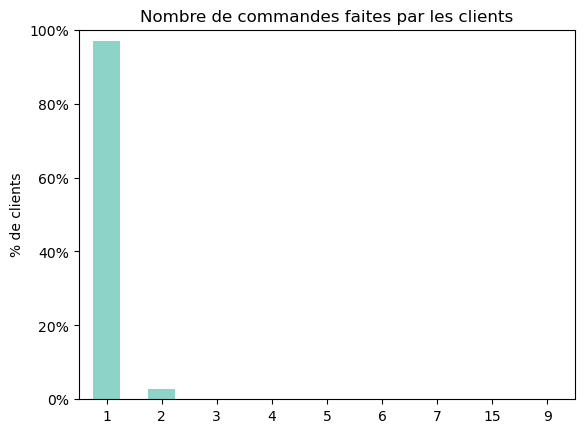

In [32]:
barplot = base_client_unique['nombre_commandes'].value_counts(normalize=True, dropna=False).plot(kind='bar')

plt.xticks(rotation=0)
plt.title("Nombre de commandes faites par les clients", fontsize=12)
plt.xlabel(None)
plt.ylabel("% de clients")
plt.ylim(0,1)
ticks = plt.yticks()[0]
plt.yticks(ticks, ['{}%'.format(int(tick * 100)) for tick in ticks])
        
plt.show()

#### -- Longitude / Latitude --

In [33]:
# Remplacement des valeurs manquantes de longitude et latitude d'un client déjà créées dans la base : olist_customers_dataset_deduplicated
# Sélectionner les colonnes à utiliser pour l'imputation
data_to_impute = olist_customers_dataset_deduplicated[['customer_zip_code_prefix',
                'geolocation_lat','geolocation_lng']]
# Sauvegarder les index
index_data_to_impute = data_to_impute.index
# Instancier KNNImputer :
imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, weights="uniform")
# Imputer les valeurs manquantes et convertir le résultat en DataFrame pandas
data_imputed = pd.DataFrame(imputer.fit_transform(data_to_impute), index=index_data_to_impute, columns=data_to_impute.columns)
# Réintégrer les valeurs imputées dans le DataFrame d'origine
olist_customers_dataset_deduplicated[data_imputed.columns] = data_imputed

C:\Users\druar\AppData\Local\Temp\ipykernel_20800\2448254863.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  olist_customers_dataset_deduplicated[data_imputed.columns] = data_imputed


In [34]:
# Fusionnez les variables longitude / latitude des clients avec la base client unique
long_lat_completed = olist_customers_dataset_deduplicated[['customer_unique_id','geolocation_lat','geolocation_lng']]
base_client_unique = pd.merge(base_client_unique, long_lat_completed, on='customer_unique_id', how='left')

In [35]:
base_client_unique.shape

(93104, 7)

#### 3. Création des variables à partir de la base 'olist_orders_dataset'

#### -- Date de la dernière commande --
- Date de la derniere commande

In [36]:
# Conserver uniquement les variables utiles dans olist_orders_dataset :
olist_orders_dataset_selected = olist_orders_dataset[['order_purchase_timestamp', 'customer_id']]
base_commandes = pd.merge(ref_customer, olist_orders_dataset_selected, on='customer_id', how='left')

In [37]:
# Créer la variable date de la dernière commande
# Convertir la colonne de date en datetime
base_commandes['order_purchase_timestamp'] = pd.to_datetime(base_commandes['order_purchase_timestamp'])
# Triez le DataFrame par 'customer_unique_id' et 'order_date' dans l'ordre décroissant
base_commandes = base_commandes.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'], ascending=[True, False])

# Dédoublonner en conservant la commande la plus récente pour chaque client unique
base_commandes_recentes = base_commandes.drop_duplicates(subset='customer_unique_id', keep='first')

# Supprimer la variable customer_id qui n'a plus de sens
base_commandes_recentes = base_commandes_recentes.drop(columns=['customer_id','order_id'])

In [38]:
# Fusionnez les données des clients avec les variables créées
base_client_unique = pd.merge(base_client_unique, base_commandes_recentes, on='customer_unique_id', how='left')
# Renomer la variable 'order_purchase_timestamp'
base_client_unique = base_client_unique.rename(columns={'order_purchase_timestamp': 'date_derniere_commande'})

In [39]:
# Convertir 'date_derniere_commande' en nombre de jours depuis une date de référence
reference_date = pd.Timestamp('2018-08-31')  # Depuis la fin de la période d'analyse par exemple
base_client_unique['nb_jour_reference'] = (reference_date - base_client_unique['date_derniere_commande']).dt.days

In [40]:
# Créer une variable récence de la dernière commande :
# Définir les intervalles pour les catégories de récence
bins = [0, 30, 60, 90, 120, 150, 365]
labels = ['1 mois', '2 mois', '3 mois', '4 mois', '5 mois', '6-12 mois']
# Créer la variable 'recence_client' en utilisant pd.cut
base_client_unique['recence_client'] = pd.cut(base_client_unique['nb_jour_reference'], bins=bins, labels=labels, right=False)
# Afficher le DataFrame mis à jour
base_client_unique.shape

(93104, 10)

In [41]:
base_client_unique.head()

customer_unique_id  customer_zip_code_prefix  \
0  7c396fd4830fd04220f754e42b4e5bff                      3149   
1  af07308b275d755c9edb36a90c618231                     47813   
2  3a653a41f6f9fc3d2a113cf8398680e8                     75265   
3  7c142cf63193a1473d2e66489a9ae977                     59296   
4  72632f0f9dd73dfee390c9b22eb56dd6                      9195   

             customer_city customer_state  nombre_commandes  geolocation_lat  \
0                sao paulo             SP                 2       -23.583452   
1                barreiras             BA                 1       -12.124719   
2               vianopolis             GO                 1       -16.743570   
3  sao goncalo do amarante             RN                 1        -5.773119   
4              santo andre             SP                 1       -23.674612   

   geolocation_lng date_derniere_commande  nb_jour_reference recence_client  
0       -46.586284    2017-10-02 10:56:33                332      6-12 mois  
1       -45.011148    2018-07-24 20:41:37                 37         2 mois  
2       -48.511633    2018-08-08 08:38:49                 22         1 mois  
3       -35.272557    2017-11-18 19:28:06                285      6-12 mois  
4       -46.518300    2018-02-13 21:18:39                198      6-12 mois

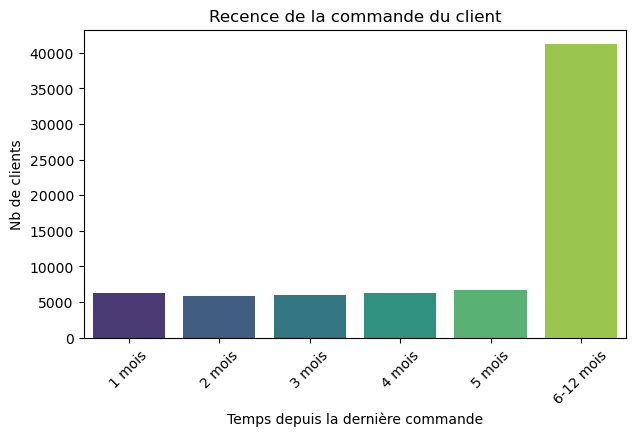

In [42]:
# Nombre de commandes par mois
order_counts = base_client_unique['recence_client'].value_counts().sort_index()
# Créer le barplot
plt.figure(figsize=(7, 4))
sns.barplot(x=order_counts.index.astype(str), y=order_counts.values, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Temps depuis la dernière commande')
plt.ylabel('Nb de clients')
plt.title('Recence de la commande du client')
plt.show()

#### 4. Création des variables à partir de la base 'olist_order_payments_dataset'
- Montant total des commandes
- Types de paiements du client / attention il peut y avoir plusieurs types de paiement par commande
- Paiement en plusieurs fois

#### -- Montants des commandes --

In [43]:
# Montant total des commandes :
# Fusionnez les données des clients avec les données de paiement
# Conserver uniquement les variables utiles dans olist_order_payments_dataset :
olist_order_payments_dataset_selected = olist_order_payments_dataset[['payment_value', 'order_id']]
base_paiements = pd.merge(olist_order_payments_dataset_selected, ref_customer, on='order_id', how='left')

# Sommer les valeurs de 'payment_value' pour chaque 'customer_unique_id', cela sommera d'une part les séquences d'une même commande et d'autres part les commandes d'un même client
paiement_client_unique = base_paiements.groupby('customer_unique_id', as_index=False)['payment_value'].sum()

# Fusionnez avec la base_client_unique
base_client_unique = pd.merge(base_client_unique, paiement_client_unique, on='customer_unique_id', how='left')
# Renomer la variable 'payment_value'
base_client_unique = base_client_unique.rename(columns={'payment_value': 'montant_total_commandes'})

In [44]:
# Il y a un client pour lequel la commande n'apparait pas dans la base de paiement (il s'agit de la première commande du 15-09-2016)
# On affecte la moyenne au montant_total_commandes pour ce client, mais il sera sans doute retiré de la base de travail
# Remplacement des valeurs manquantes de la variable 'montant_total_commandes' par la valeur médiane :
base_client_unique['montant_total_commandes'].fillna(base_client_unique['montant_total_commandes'].median(), inplace=True)

#### -- Type de paiement utilisé --
- Carte de crédit, bon, carte de débit, boleto ...

In [45]:
# Conserver uniquement les variables utiles dans olist_order_payments_dataset :
olist_order_payments_dataset_selected = olist_order_payments_dataset[['payment_type','order_id']]
base_paiements = pd.merge(olist_order_payments_dataset_selected, ref_customer, on='order_id', how='left')

In [46]:
# Nb de commandes par client / type de paiement : 'Nb de commandes credit_card, boleto …' 
# - à noter que une même commande peut avoir été payée par carte et par chèque cadeau par exemple -

for type in base_paiements['payment_type'].unique():
    # Filtrer les commandes avec le payment_type = type
    commandes_filtrees = base_paiements[base_paiements['payment_type'] == type]
    # Grouper les commandes par client et compter le nombre de commandes par client
    nb_commandes_par_client = commandes_filtrees.groupby('customer_unique_id').size().reset_index(name=f'nombre_commandes_{type}')
    # Fusionnez les données des clients avec le nombre de commandes par client
    base_client_unique = pd.merge(base_client_unique, nb_commandes_par_client, on='customer_unique_id', how='left')
    base_client_unique[f'nombre_commandes_{type}'] = base_client_unique[f'nombre_commandes_{type}'].fillna(0)

# Supprimer les variables qui n'ont plus de sens - 'nombre_commandes_not_defined'=2 à supprimer
base_client_unique = base_client_unique.drop(columns=['nombre_commandes_not_defined'])

In [47]:
# ['nombre_commandes_credit_card', 'nombre_commandes_boleto', 'nombre_commandes_voucher', 'nombre_commandes_debit_card']
# 'nombre_commandes_credit_card' 0.0  21274
# 'nombre_commandes_boleto' 0.0  74438
# nombre_commandes_voucher 0.0  89522
# nombre_commandes_debit_card 0.0  91636

In [48]:
# Création d'une variable "au moins un paiement en credit card pour le client" 0/1
base_client_unique.loc[base_client_unique['nombre_commandes_credit_card'] >= 1, 'paiement_credit_card'] = 1
base_client_unique.loc[base_client_unique['nombre_commandes_credit_card'] == 0, 'paiement_credit_card'] = 0

#### -- Paiement en plusieurs fois --
- Au moins une commande payée au comptant, en x fois ...

In [49]:
# Conserver uniquement les variables utiles dans olist_order_payments_dataset :
olist_order_payments_dataset_selected = olist_order_payments_dataset[['payment_installments','order_id']]
base_paiements = pd.merge(olist_order_payments_dataset_selected, ref_customer, on='order_id', how='left')

In [50]:
# Nb de commandes par client / paiement en x fois : 'Nb de commandes payées en 1 fois, 2 xxx' 
# Agréger les nb de fois de paiement : 1 fois, 2 fois, 3 fois, 4 fois, 5-9 fois, 10 fois et +
# 2 commandes avec installments = 0 --> affecter 1
base_paiements.loc[base_paiements["payment_installments"] == 0, "payment_installments"] = 1
bins = [1, 2, 3, 4, 5, 10, 25]
labels = ['1 fois', '2 fois', '3 fois', '4 fois', '5-9 fois', '10 fois et +']
# Créer la variable 'nb_installments' en utilisant pd.cut
base_paiements['nb_installments'] = pd.cut(base_paiements['payment_installments'], bins=bins, labels=labels, right=False)
# Créer une variable 'paiement_plusieurs_fois'
base_paiements.loc[base_paiements["payment_installments"] > 1, 'paiement_xfois'] = 1
base_paiements.loc[base_paiements["payment_installments"] == 1, 'paiement_xfois'] = 0
# Afficher le DataFrame mis à jour
base_paiements.head()

payment_installments                          order_id  \
0                     8  b81ef226f3fe1789b1e8b2acac839d17   
1                     1  a9810da82917af2d9aefd1278f1dcfa0   
2                     1  25e8ea4e93396b6fa0d3dd708e76c1bd   
3                     8  ba78997921bbcdc1373bb41e913ab953   
4                     2  42fdf880ba16b47b59251dd489d4441a   

                        customer_id                customer_unique_id  \
0  0a8556ac6be836b46b3e89920d59291c  708ab75d2a007f0564aedd11139c7708   
1  f2c7fc58a9de810828715166c672f10a  a8b9d3a27068454b1c98cc67d4e31e6f   
2  25b14b69de0b6e184ae6fe2755e478f9  6f70c0b2f7552832ba46eb57b1c5651e   
3  7a5d8efaaa1081f800628c30d2b0728f  87695ed086ebd36f20404c82d20fca87   
4  15fd6fb8f8312dbb4674e4518d6fa3b3  4291db0da71914754618cd789aebcd56   

  nb_installments  paiement_xfois  
0        5-9 fois             1.0  
1          1 fois             0.0  
2          1 fois             0.0  
3        5-9 fois             1.0  
4          2 fois             1.0

In [51]:
for nb_installment in base_paiements['nb_installments'].unique():
    # Filtrer les commandes avec le payment_type = type
    commandes_filtrees = base_paiements[base_paiements['nb_installments'] == nb_installment]
    # Grouper les commandes par client et compter le nombre de commandes par client
    nb_commandes_par_client = commandes_filtrees.groupby('customer_unique_id').size().reset_index(name=f'nombre_commandes_{nb_installment}')
    # Fusionnez les données des clients avec le nombre de commandes par client
    base_client_unique = pd.merge(base_client_unique, nb_commandes_par_client, on='customer_unique_id', how='left')
    base_client_unique[f'nombre_commandes_{nb_installment}'] = base_client_unique[f'nombre_commandes_{nb_installment}'].fillna(0)

In [52]:
# Triez le DataFrame par 'customer_unique_id' et 'paiement_xfois' dans l'ordre décroissant
base_paiements = base_paiements.sort_values(by=['customer_unique_id', 'paiement_xfois'], ascending=[True, False])

# Dédoublonner en conservant la commande 'paiement_xfois' = 1 en prio pour chaque client unique
base_paiement_xfois = base_paiements.drop_duplicates(subset='customer_unique_id', keep='first')

# Supprimer la variable customer_id qui n'a plus de sens
base_paiement_xfois = base_paiement_xfois.drop(columns=['customer_id','order_id'])

In [53]:
# Fusionnez les données des clients avec base_paiement_xfois
base_client_unique = pd.merge(base_client_unique, base_paiement_xfois, on='customer_unique_id', how='left')
base_client_unique['paiement_xfois'] = base_client_unique['paiement_xfois'].fillna(0)

In [54]:
# 'nombre_commandes_1 fois', 0.0  46790
# 'nombre_commandes_2 fois', 0.0  81221
# 'nombre_commandes_3 fois', 0.0  83121
# 'nombre_commandes_4 fois', 0.0  86315
# 'nombre_commandes_5-9 fois', 0.0  78274
# 'nombre_commandes_10 fois et +', 0.0  87781

#### 5. Création des variables à partir de la base 'olist_order_reviews_dataset'
- Note minimale donnée par un client
- Client a laissé un commentaire oui / non

#### -- Note de satisfaction minimale --

In [55]:
# Fusionnez les données des clients avec les données commentaires
# Conserver uniquement les variables utiles dans olist_order_reviews_dataset :
olist_order_reviews_dataset_selected = olist_order_reviews_dataset[['review_score', 'order_id']]
base_notes = pd.merge(olist_order_reviews_dataset_selected, ref_customer, on='order_id', how='left')

# Note minimale pour chaque 'customer_unique_id'
commentaires_client_unique = base_notes.groupby('customer_unique_id', as_index=False)['review_score'].min()

# Fusionnez avec la base_client_unique
base_client_unique = pd.merge(base_client_unique, commentaires_client_unique, on='customer_unique_id', how='left')
# Renomer la variable 'review_score'
base_client_unique = base_client_unique.rename(columns={'review_score': 'score_min'})

In [56]:
# Nombre de clients n'ayant jamais donné de note
base_client_unique['score_min'].isna().sum()

600

In [57]:
# Remplacement des valeurs manquantes de la variable 'score_min' par la valeur moyenne :
base_client_unique['score_min'].fillna(base_client_unique['score_min'].mean(), inplace=True)

#### -- Commentaire laissé par le client --

In [58]:
# Fusionnez les données des clients avec les données commentaires
# Conserver uniquement les variables utiles dans olist_order_reviews_dataset :
olist_order_reviews_dataset_selected = olist_order_reviews_dataset[['review_comment_message', 'order_id']]
base_commentaires = pd.merge(olist_order_reviews_dataset_selected, ref_customer, on='order_id', how='left')

# Séparer les lignes avec review_comment_message non vide
commentaires_clients = base_commentaires.dropna(subset=['review_comment_message'])

# Grouper les lignes avec review_comment_message par id_client_unique et conserver une ligne
commentaires_clients_dedup = commentaires_clients.groupby('customer_unique_id').first().reset_index()

# Fusionnez avec la base_client_unique
base_client_unique = pd.merge(base_client_unique, commentaires_clients_dedup, on='customer_unique_id', how='left')
# Renomer la variable 'review_comment_message'
base_client_unique = base_client_unique.rename(columns={'review_comment_message': 'commentaire_client'})

# Modifier la variable en 0 : pas de commentaire laissé et 1 : commentaire laissé
base_client_unique['commentaire_client'] = base_client_unique['commentaire_client'].fillna(0)
base_client_unique['commentaire_client'] = base_client_unique['commentaire_client'].apply(lambda x: 1 if x != 0 else 0)

# Supprimer les variables qui n'ont plus de sens
base_client_unique = base_client_unique.drop(columns=['order_id','customer_id'])

In [59]:
# Vérification - 0 : pas de commentaire laissé et 1 : commentaire laissé (37850 clients)
base_client_unique['commentaire_client'].sum()

37850

#### 6. Création des variables à partir de la base 'olist_products_dataset'

#### -- Catégorie de produits achetés --

In [60]:
category_name = pd.merge(olist_products_dataset, product_category_name_translation, on='product_category_name', how='left')

In [61]:
effectifs = category_name['product_category_name_english'].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
print(f"Nb de catégories de produits : {modalites.shape[0]} catégories différentes")
tab = pd.DataFrame(modalites, columns = ['product_category_name_english']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/category_name['product_category_name_english'].count())*100
print(tab.head(10))

Nb de catégories de produits : 71 catégories différentes
  product_category_name_english     n         %
0                bed_bath_table  3029  9.369587
1                sports_leisure  2867  8.868473
2               furniture_decor  2657  8.218881
3                 health_beauty  2444  7.560010
4                    housewares  2335  7.222841
5                          auto  1900  5.877258
6         computers_accessories  1639  5.069908
7                          toys  1411  4.364637
8                 watches_gifts  1329  4.110987
9                     telephony  1134  3.507795


In [62]:
# tab.to_excel('category_name.xlsx', index=False)

In [63]:
# Regroupement des produits en 10 grandes catégories
maison_decoration = [
    'bed_bath_table',
    'furniture_decor',
    'housewares',
    'furniture_living_room',
    'air_conditioning',
    'furniture_bedroom',
    'furniture_mattress_and_upholstery',
    'home_confort',
    'home_construction',
    'home_comfort_2',
    'kitchen_dining_laundry_garden_furniture',
    'la_cuisine',
    'christmas_supplies'
]
electro_informatique = [
    'computers_accessories',
    'electronics',
    'computers',
    'audio',
    'small_appliances',
    'fixed_telephony',
    'telephony',
    'small_appliances_home_oven_and_coffee',
    'home_appliances',
    'home_appliances_2'
]
mode_accessoires = [
    'fashion_bags_accessories',
    'fashion_shoes',
    'fashion_male_clothing',
    'fashio_female_clothing',
    'fashion_underwear_beach',
    'fashion_sport',
    'fashion_childrens_clothes',
    'luggage_accessories'
]
bebe_sante_beaute = [
    'health_beauty',
    'perfumery',
    'diapers_and_hygiene',
    'baby'
]
loisirs_divertissement = [
    'sports_leisure',
    'toys',
    'watches_gifts',
    'musical_instruments',
    'books_general_interest',
    'books_technical',
    'books_imported',
    'party_supplies',
    'toys',
    'art',
    'music',
    'dvds_blu_ray',
    'cds_dvds_musicals',
    'cine_photo',
    'consoles_games',
    'arts_and_craftmanship',
    'cool_stuff',
    'tablets_printing_image'
]
jardi_brico = [
    'garden_tools',
    'construction_tools_construction',
    'costruction_tools_garden',
    'costruction_tools_tools',
    'construction_tools_safety',
    'construction_tools_lights',
    'signaling_and_security',
    'flowers'
]
nourriture_boissons = [
    'food_drink',
    'food',
    'drinks'
]
bureau = [
    'stationery',
    'office_furniture'
]
divers = [
    'pet_shop',
    'market_place',
    'agro_industry_and_commerce',
    'industry_commerce_and_business',
    'security_and_services'
]
auto = [
    'auto'
]

In [64]:
# Création d'une variable catégorie_10
category_name.loc[category_name['product_category_name_english'].isin(maison_decoration), 'categorie_10'] = 'maison_decoration'
category_name.loc[category_name['product_category_name_english'].isin(electro_informatique), 'categorie_10'] = 'electro_informatique'
category_name.loc[category_name['product_category_name_english'].isin(mode_accessoires), 'categorie_10'] = 'mode_accessoires'
category_name.loc[category_name['product_category_name_english'].isin(bebe_sante_beaute), 'categorie_10'] = 'bebe_sante_beaute'
category_name.loc[category_name['product_category_name_english'].isin(loisirs_divertissement), 'categorie_10'] = 'loisirs_divertissement'
category_name.loc[category_name['product_category_name_english'].isin(jardi_brico), 'categorie_10'] = 'jardi_brico'
category_name.loc[category_name['product_category_name_english'].isin(nourriture_boissons), 'categorie_10'] = 'nourriture_boissons'
category_name.loc[category_name['product_category_name_english'].isin(bureau), 'categorie_10'] = 'bureau'
category_name.loc[category_name['product_category_name_english'].isin(divers), 'categorie_10'] = 'divers'
category_name.loc[category_name['product_category_name_english'].isna(), 'categorie_10'] = 'divers' # On affecte divers pour les produits sans catégorie
category_name.loc[category_name['product_category_name_english'].isin(auto), 'categorie_10'] = 'auto'

In [65]:
effectifs = category_name['categorie_10'].value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
print(f"Nb de catégories de produits : {modalites.shape[0]} catégories différentes")
tab = pd.DataFrame(modalites, columns = ['categorie_10']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/category_name['categorie_10'].count())*100
print(tab.head(10))

Nb de catégories de produits : 10 catégories différentes
             categorie_10     n          %
0       maison_decoration  8866  26.906619
1  loisirs_divertissement  7585  23.019028
2       bebe_sante_beaute  4243  12.876696
3    electro_informatique  4216  12.794756
4                    auto  1900   5.766138
5                  divers  1590   4.825347
6        mode_accessoires  1570   4.764651
7             jardi_brico  1556   4.722163
8                  bureau  1158   3.514309
9     nourriture_boissons   267   0.810294


In [66]:
# Récupérer l'info catégorie de produit dans la base client unique
# Conserver uniquement les variables utiles dans olist_products_dataset :
category_name_selected = category_name[['categorie_10','product_id']]
# on croise la base categ avec la base items produits pour récupérer l'order_id :
base_produits_categ = pd.merge(olist_order_items_dataset, category_name_selected, on='product_id', how='left')
# on croise la base produits avec la base ref_customer
base_produits = pd.merge(base_produits_categ, ref_customer, on='order_id', how='left')

In [67]:
base_produits.shape

(112650, 10)

In [68]:
# Nb de produits par client / categorie de produits : 'Nb de commandes avec un produit categ1, categ2, etc' 
for categ in base_produits['categorie_10'].unique():
    # Filtrer les produits avec la catégorie = categ
    produits_filtrees = base_produits[base_produits['categorie_10'] == categ]
    # Grouper les produits par client et compter le nombre de produits par client
    nb_produits_par_client = produits_filtrees.groupby('customer_unique_id').size().reset_index(name=f'nombre_produits_{categ}')
    # Fusionnez les données des clients avec le nombre de produits par client
    base_client_unique = pd.merge(base_client_unique, nb_produits_par_client, on='customer_unique_id', how='left')
    base_client_unique[f'nombre_produits_{categ}'] = base_client_unique[f'nombre_produits_{categ}'].fillna(0)

In [69]:
base_client_unique.head()

customer_unique_id  customer_zip_code_prefix  \
0  7c396fd4830fd04220f754e42b4e5bff                      3149   
1  af07308b275d755c9edb36a90c618231                     47813   
2  3a653a41f6f9fc3d2a113cf8398680e8                     75265   
3  7c142cf63193a1473d2e66489a9ae977                     59296   
4  72632f0f9dd73dfee390c9b22eb56dd6                      9195   

             customer_city customer_state  nombre_commandes  geolocation_lat  \
0                sao paulo             SP                 2       -23.583452   
1                barreiras             BA                 1       -12.124719   
2               vianopolis             GO                 1       -16.743570   
3  sao goncalo do amarante             RN                 1        -5.773119   
4              santo andre             SP                 1       -23.674612   

   geolocation_lng date_derniere_commande  nb_jour_reference recence_client  \
0       -46.586284    2017-10-02 10:56:33                332      6-12 mois   
1       -45.011148    2018-07-24 20:41:37                 37         2 mois   
2       -48.511633    2018-08-08 08:38:49                 22         1 mois   
3       -35.272557    2017-11-18 19:28:06                285      6-12 mois   
4       -46.518300    2018-02-13 21:18:39                198      6-12 mois   

   ...  nombre_produits_loisirs_divertissement  nombre_produits_divers  \
0  ...                                     0.0                     0.0   
1  ...                                     0.0                     0.0   
2  ...                                     0.0                     0.0   
3  ...                                     0.0                     1.0   
4  ...                                     0.0                     0.0   

   nombre_produits_maison_decoration  nombre_produits_bebe_sante_beaute  \
0                                1.0                                1.0   
1                                0.0                                1.0   
2                                0.0                                0.0   
3                                0.0                                0.0   
4                                0.0                                0.0   

   nombre_produits_jardi_brico  nombre_produits_electro_informatique  \
0                          0.0                                   0.0   
1                          0.0                                   0.0   
2                          0.0                                   0.0   
3                          0.0                                   0.0   
4                          0.0                                   0.0   

   nombre_produits_mode_accessoires  nombre_produits_bureau  \
0                               0.0                     0.0   
1                               0.0                     0.0   
2                               0.0                     0.0   
3                               0.0                     0.0   
4                               0.0                     1.0   

   nombre_produits_nourriture_boissons  nombre_produits_auto  
0                                  0.0                   0.0  
1                                  0.0                   0.0  
2                                  0.0                   1.0  
3                                  0.0                   0.0  
4                                  0.0                   0.0  

[5 rows x 37 columns]

In [70]:
vars = ['nombre_produits_loisirs_divertissement', 'nombre_produits_divers',
       'nombre_produits_maison_decoration',
       'nombre_produits_bebe_sante_beaute', 'nombre_produits_jardi_brico',
       'nombre_produits_electro_informatique',
       'nombre_produits_mode_accessoires', 'nombre_produits_bureau',
       'nombre_produits_nourriture_boissons', 'nombre_produits_auto']
for variable in vars:
    base_client_unique.loc[base_client_unique[variable] >= 1, variable] = 1

#### 7. Représentation des variables

In [71]:
base_client_unique.columns

Index(['customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'nombre_commandes', 'geolocation_lat',
       'geolocation_lng', 'date_derniere_commande', 'nb_jour_reference',
       'recence_client', 'montant_total_commandes',
       'nombre_commandes_credit_card', 'nombre_commandes_boleto',
       'nombre_commandes_voucher', 'nombre_commandes_debit_card',
       'paiement_credit_card', 'nombre_commandes_5-9 fois',
       'nombre_commandes_1 fois', 'nombre_commandes_2 fois',
       'nombre_commandes_3 fois', 'nombre_commandes_4 fois',
       'nombre_commandes_10 fois et +', 'payment_installments',
       'nb_installments', 'paiement_xfois', 'score_min', 'commentaire_client',
       'nombre_produits_loisirs_divertissement', 'nombre_produits_divers',
       'nombre_produits_maison_decoration',
       'nombre_produits_bebe_sante_beaute', 'nombre_produits_jardi_brico',
       'nombre_produits_electro_informatique',
       'nombre_produits_mode_accessoire

In [72]:
# Afficher la liste des variables avec leurs valeurs manquantes = vérifs OK, plus de valeurs manquantes
# msno.bar(base_client_unique, color='#8dd3c7',figsize=(10, 6),fontsize=12)
# plt.show()

#### -- Représentations univariées --

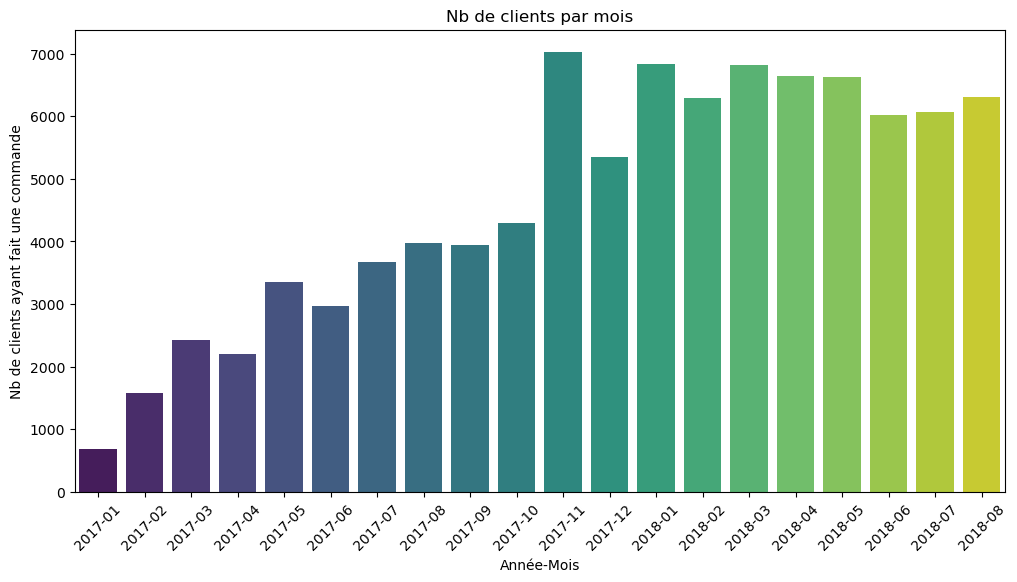

In [73]:
# Convertir la colonne 'order_purchase_timestamp' en datetime
# base_client_unique['date_derniere_commande'] = pd.to_datetime(base_client_unique['date_derniere_commande'])
# Extraire l'année et le mois
base_client_unique['year_month'] = base_client_unique['date_derniere_commande'].dt.to_period('M')
# Nombre de commandes par mois
order_counts = base_client_unique['year_month'].value_counts().sort_index()
# Créer le barplot
plt.figure(figsize=(12, 6))
sns.barplot(x=order_counts.index.astype(str), y=order_counts.values, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel('Année-Mois')
plt.ylabel('Nb de clients ayant fait une commande')
plt.title('Nb de clients par mois')
plt.show()

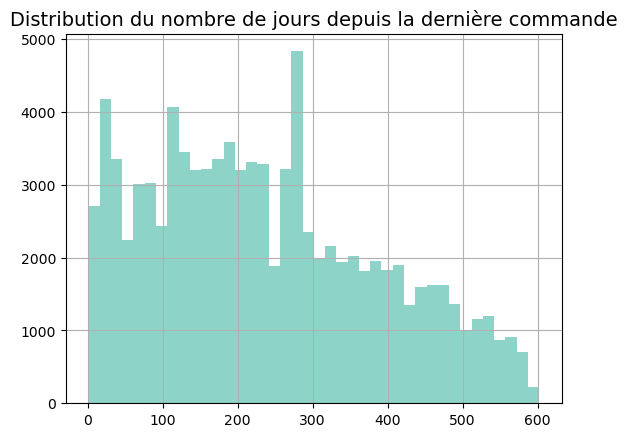

In [74]:
base_client_unique['nb_jour_reference'].hist(bins=40)
plt.title("Distribution du nombre de jours depuis la dernière commande",fontsize=14)
plt.show()

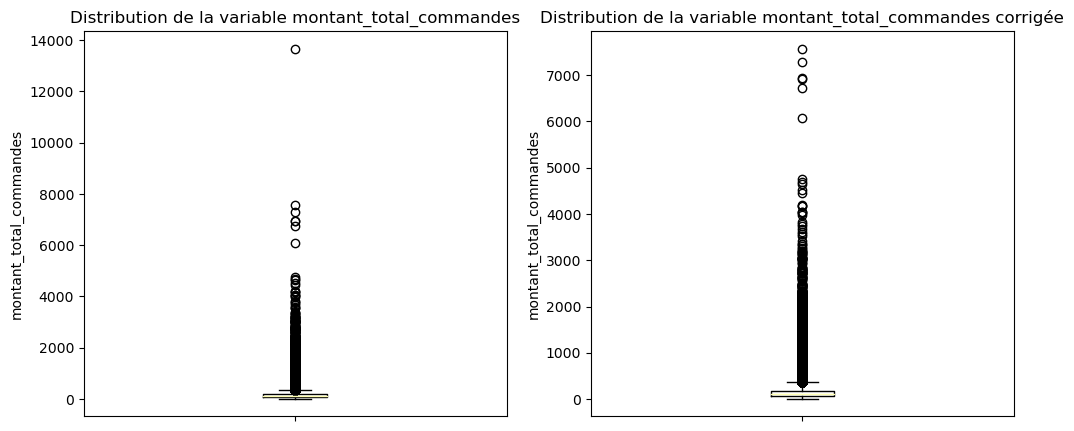

In [75]:
variable = 'montant_total_commandes'

# Supprimer les valeurs manquantes pour afficher le boxplot et étudier les outliers
df_corrige = base_client_unique.loc[base_client_unique[variable]<8000, ]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Boîte à moustaches pour la distribution avant correction
axs[0].boxplot(base_client_unique[variable])
axs[0].set_title(f'Distribution de la variable {variable}')
axs[0].set_xticklabels([]) 
axs[0].set_ylabel(f"{variable}",fontsize=10) 
axs[0].ticklabel_format(style='plain', axis='y')  # Désactiver l'écriture scientifique sur l'axe y

# Boîte à moustaches pour la distribution après correction
axs[1].boxplot(df_corrige[variable])
axs[1].set_title(f'Distribution de la variable {variable} corrigée')
axs[1].set_xticklabels([]) 
axs[1].set_ylabel(f"{variable}",fontsize=10) 

plt.show()

In [76]:
# La commande à 14 000 BRL (env. 2 400€) correspond à 8 produits identiques de la catégorie 'telephone fixe'

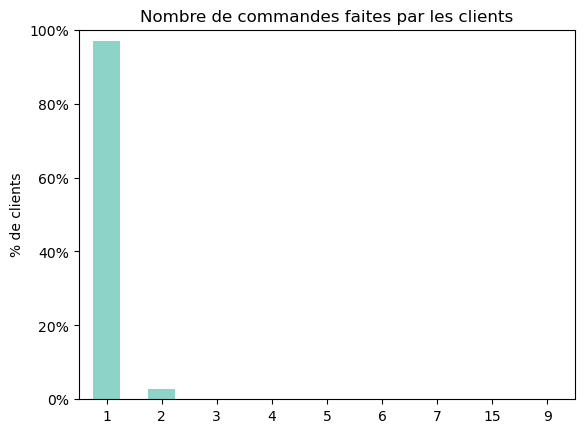

In [77]:
barplot = base_client_unique['nombre_commandes'].value_counts(normalize=True, dropna=False).plot(kind='bar')

plt.xticks(rotation=0)
plt.title("Nombre de commandes faites par les clients", fontsize=12)
plt.xlabel(None)
plt.ylabel("% de clients")
plt.ylim(0,1)
ticks = plt.yticks()[0]
plt.yticks(ticks, ['{}%'.format(int(tick * 100)) for tick in ticks])
        
plt.show()

In [78]:
vars = ['nombre_commandes_credit_card', 'nombre_commandes_boleto',
       'nombre_commandes_voucher', 'nombre_commandes_debit_card']
# Boleto = moyen de paiement en espèce au Brézil
for variable in vars:
    print("-"*20)
    print(variable)
    print(base_client_unique[f'{variable}'].sum())

--------------------
nombre_commandes_credit_card
74376.0
--------------------
nombre_commandes_boleto
19140.0
--------------------
nombre_commandes_voucher
5473.0
--------------------
nombre_commandes_debit_card
1484.0


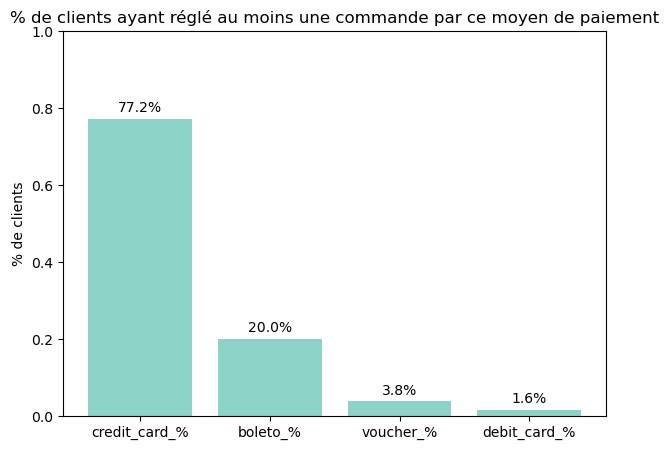

In [79]:
# % de clients ayant réglé au moins une commande par ce moyen de paiement
base = base_client_unique.copy()
# Ajouter des colonnes pour indiquer si le client a réglé au moins une commande par chaque moyen de paiement
base['part_credit_card'] = base["nombre_commandes_credit_card"].apply(lambda x: 1 if x > 0 else 0)
base['part_boleto'] = base["nombre_commandes_boleto"].apply(lambda x: 1 if x > 0 else 0)
base['part_voucher'] = base["nombre_commandes_voucher"].apply(lambda x: 1 if x > 0 else 0)
base['part_debit_card'] = base["nombre_commandes_debit_card"].apply(lambda x: 1 if x > 0 else 0)

# Calculer le pourcentage de clients ayant utilisé chaque moyen de paiement
pct = [
    base["part_credit_card"].sum() / base_client_unique.shape[0],
    base["part_boleto"].sum() / base_client_unique.shape[0],
    base["part_voucher"].sum() / base_client_unique.shape[0],
    base["part_debit_card"].sum() / base_client_unique.shape[0]
]

# Labels pour les barres
labels = ['credit_card_%', 'boleto_%', 'voucher_%', 'debit_card_%']

# Créer le graphique en barres
plt.figure(figsize=(7, 5))
plt.bar(labels, pct)

# Ajouter les pourcentages sur les barres
for i, v in enumerate(pct):
    plt.text(i, v + 0.01, f'{v * 100:.1f}%', ha='center', va='bottom')

# Ajouter un titre et des labels aux axes
plt.title('% de clients ayant réglé au moins une commande par ce moyen de paiement')
plt.ylabel('% de clients')
plt.ylim(0, 1)  # Assurer que l'axe y va de 0 à 1 pour représenter les pourcentages

# Afficher le graphique
plt.show()

In [80]:
vars = ['nombre_commandes_5-9 fois', 'nombre_commandes_1 fois',
       'nombre_commandes_2 fois', 'nombre_commandes_3 fois',
       'nombre_commandes_4 fois', 'nombre_commandes_10 fois et +', 'paiement_xfois']

for variable in vars:
    print("-"*20)
    print(variable)
    print(base_client_unique[f'{variable}'].sum())

--------------------
nombre_commandes_5-9 fois
15170.0
--------------------
nombre_commandes_1 fois
50809.0
--------------------
nombre_commandes_2 fois
12050.0
--------------------
nombre_commandes_3 fois
10130.0
--------------------
nombre_commandes_4 fois
6869.0
--------------------
nombre_commandes_10 fois et +
5445.0
--------------------
paiement_xfois
48056.0


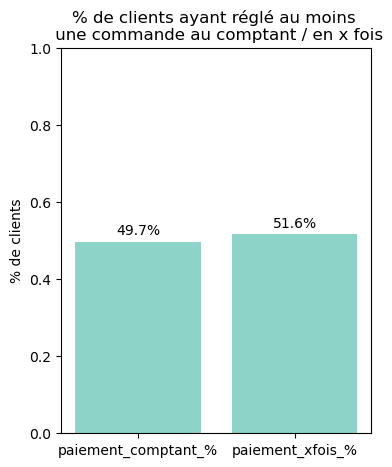

In [81]:
# % de clients ayant réglé au moins une commande par ce moyen de paiement
base = base_client_unique.copy()
# Ajouter des colonnes pour indiquer si le client a réglé au moins une commande au comptant
base['part_paiement_comptant'] = base["nombre_commandes_1 fois"].apply(lambda x: 1 if x > 0 else 0)

# Calculer le pourcentage de clients ayant utilisé chaque moyen de paiement
pct = [
    base["part_paiement_comptant"].sum() / base_client_unique.shape[0],
    base["paiement_xfois"].sum() / base_client_unique.shape[0],
]

# Labels pour les barres
labels = ['paiement_comptant_%', 'paiement_xfois_%']

# Créer le graphique en barres
plt.figure(figsize=(4, 5))
plt.bar(labels, pct)

# Ajouter les pourcentages sur les barres
for i, v in enumerate(pct):
    plt.text(i, v + 0.01, f'{v * 100:.1f}%', ha='center', va='bottom')

# Ajouter un titre et des labels aux axes
plt.title('% de clients ayant réglé au moins \n une commande au comptant / en x fois')
plt.ylabel('% de clients')
plt.ylim(0, 1)  # Assurer que l'axe y va de 0 à 1 pour représenter les pourcentages

# Afficher le graphique
plt.show()

In [82]:
vars = ['nombre_produits_loisirs_divertissement', 'nombre_produits_divers',
       'nombre_produits_maison_decoration',
       'nombre_produits_bebe_sante_beaute', 'nombre_produits_jardi_brico',
       'nombre_produits_electro_informatique',
       'nombre_produits_mode_accessoires', 'nombre_produits_bureau',
       'nombre_produits_nourriture_boissons', 'nombre_produits_auto']

for variable in vars:
    print("-"*20)
    print(variable)
    print(base_client_unique[f'{variable}'].sum())
    print(f"Part des clients ayant acheté au moins un produit de la catégorie : {base_client_unique[variable].sum()/base_client_unique.shape[0]}")

--------------------
nombre_produits_loisirs_divertissement
22826.0
Part des clients ayant acheté au moins un produit de la catégorie : 0.24516669530847224
--------------------
nombre_produits_divers
3730.0
Part des clients ayant acheté au moins un produit de la catégorie : 0.040062725554218935
--------------------
nombre_produits_maison_decoration
22449.0
Part des clients ayant acheté au moins un produit de la catégorie : 0.2411174600446812
--------------------
nombre_produits_bebe_sante_beaute
14254.0
Part des clients ayant acheté au moins un produit de la catégorie : 0.15309761127341467
--------------------
nombre_produits_jardi_brico
4983.0
Part des clients ayant acheté au moins un produit de la catégorie : 0.05352079395085066
--------------------
nombre_produits_electro_informatique
15205.0
Part des clients ayant acheté au moins un produit de la catégorie : 0.16331199518817666
--------------------
nombre_produits_mode_accessoires
3273.0
Part des clients ayant acheté au moins un pr

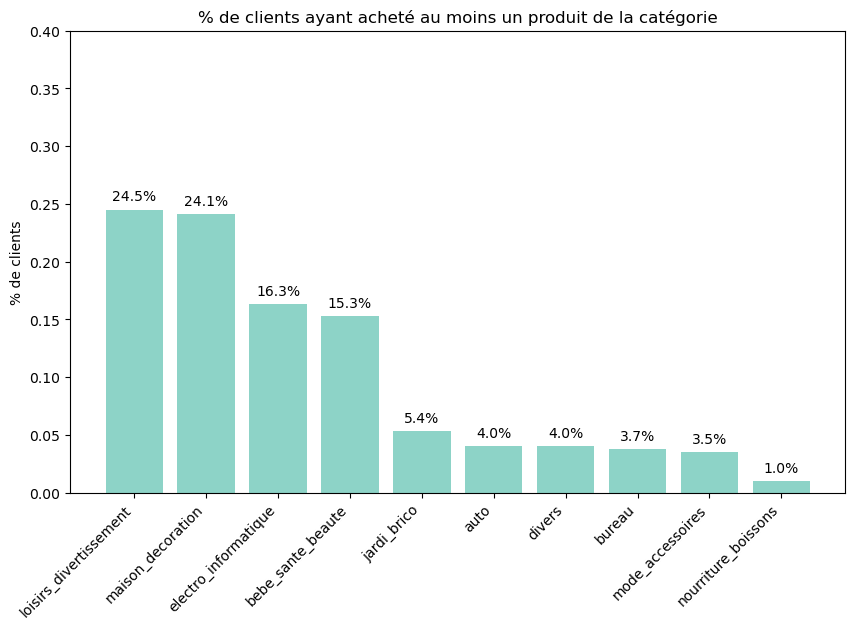

In [83]:
import matplotlib.pyplot as plt

# Initialiser les listes
vars = ['nombre_produits_loisirs_divertissement', 'nombre_produits_divers',
       'nombre_produits_maison_decoration', 'nombre_produits_bebe_sante_beaute',
       'nombre_produits_jardi_brico', 'nombre_produits_electro_informatique',
       'nombre_produits_mode_accessoires', 'nombre_produits_bureau',
       'nombre_produits_nourriture_boissons', 'nombre_produits_auto']

pct = []
labels = []

# Calculer le pourcentage de clients ayant acheté au moins un produit de chaque catégorie
for variable in vars:
    pct.append((base_client_unique[variable].sum()) / base_client_unique.shape[0])
    labels.append(variable[16:])

# Créer une liste de tuples (labels, pct)
data = list(zip(labels, pct))

# Trier les données par pourcentage en ordre décroissant
data_sorted = sorted(data, key=lambda x: x[1], reverse=True)

# Décompresser les labels et les pourcentages triés
labels_sorted, pct_sorted = zip(*data_sorted)

# Créer le graphique en barres
plt.figure(figsize=(10, 6))
plt.bar(labels_sorted, pct_sorted)

# Ajouter les pourcentages sur les barres
for i, v in enumerate(pct_sorted):
    plt.text(i, v + 0.005, f'{v * 100:.1f}%', ha='center', va='bottom')

# Ajouter un titre et des labels aux axes
plt.title('% de clients ayant acheté au moins un produit de la catégorie')
plt.ylabel('% de clients')
plt.ylim(0, 0.4)  # Ajuster l'axe y selon les pourcentages

# Rotation des étiquettes pour une meilleure lisibilité
plt.xticks(rotation=45,ha='right')

# Afficher le graphique
plt.show()


#### -- Représentations croisées --

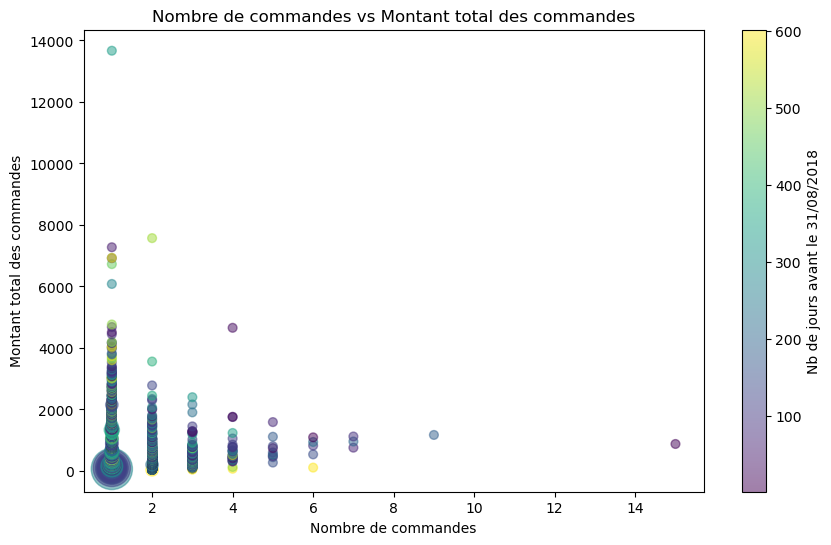

In [79]:
# Calculer le nombre de clients pour chaque combinaison de 'nombre_commandes' et 'montant_total_commandes'
customer_summary_grouped = base_client_unique.groupby(['nombre_commandes', 'montant_total_commandes','nb_jour_reference']).size().reset_index(name='nombre_clients')

# Créer le scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    customer_summary_grouped['nombre_commandes'],
    customer_summary_grouped['montant_total_commandes'],
    c=customer_summary_grouped['nb_jour_reference'],
    s=customer_summary_grouped['nombre_clients']*40,  # Ajustez le facteur de taille pour une meilleure visibilité
    alpha=0.5,
    cmap='viridis'
)
plt.colorbar(scatter, label='Nb de jours avant le 31/08/2018')
plt.title('Nombre de commandes vs Montant total des commandes')
plt.xlabel('Nombre de commandes')
plt.ylabel('Montant total des commandes')
plt.show()


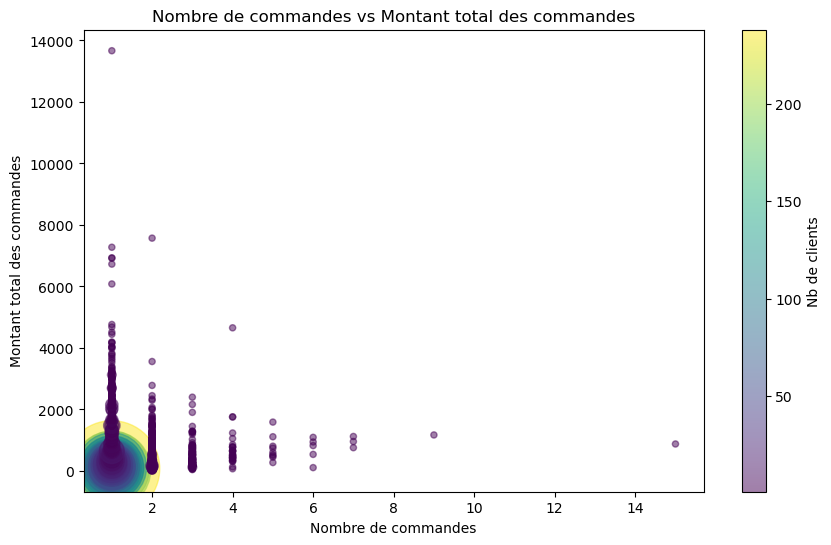

In [80]:
# Calculer le nombre de clients pour chaque combinaison de 'nombre_commandes' et 'montant_total_commandes'
customer_summary_grouped = base_client_unique.groupby(['nombre_commandes', 'montant_total_commandes']).size().reset_index(name='nombre_clients')

# Créer le scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    customer_summary_grouped['nombre_commandes'],
    customer_summary_grouped['montant_total_commandes'],
    c=customer_summary_grouped['nombre_clients'],
    s=customer_summary_grouped['nombre_clients']*20,  # Ajustez le facteur de taille pour une meilleure visibilité
    alpha=0.5,
    cmap='viridis'
)
plt.colorbar(scatter, label='Nb de clients')
plt.title('Nombre de commandes vs Montant total des commandes')
plt.xlabel('Nombre de commandes')
plt.ylabel('Montant total des commandes')
plt.show()


In [81]:
# print(base_client_unique.loc[(base_client_unique['montant_total_commandes'] > 13000)])
# customer_unique_id = 0a0a92112bd4c708ca5fde585afaa872 // 12915
# print(base_client_unique.loc[(base_client_unique['nombre_commandes'] > 14)])
# customer_unique_id = 8d50f5eadf50201ccdcedfb9e2ac8455 // 2269

<div class="alert alert-block alert-info">
    <b> A NOTER : </b> 
    
- il faudra sans doute retirer du modèle les points les plus atypiques, 15 commandes faites et le montant à 14000.
    
</div>

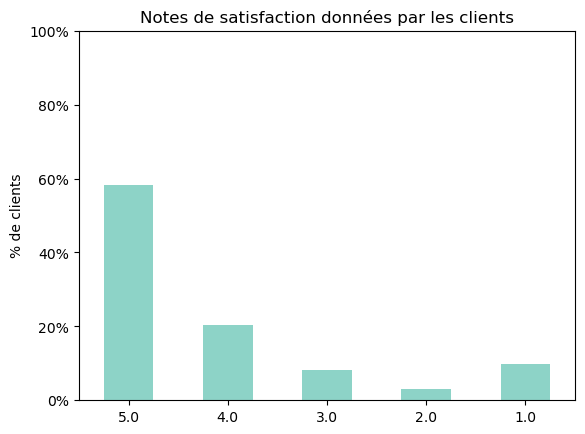

In [171]:
var = round(base_client_unique['score_min'],0)
# Calculer les fréquences relatives et les trier de 5 à 1
value_counts = var.value_counts(normalize=True, dropna=False).sort_index(ascending=False)

# Créer le diagramme en barres
barplot = value_counts.plot(kind='bar')

# Ajouter des titres et des labels
plt.xticks(rotation=0)
plt.title("Notes de satisfaction données par les clients", fontsize=12)
plt.xlabel(None)
plt.ylabel("% de clients")
plt.ylim(0, 1)
ticks = plt.yticks()[0]
plt.yticks(ticks, ['{}%'.format(int(tick * 100)) for tick in ticks])

# Afficher le diagramme
plt.show()

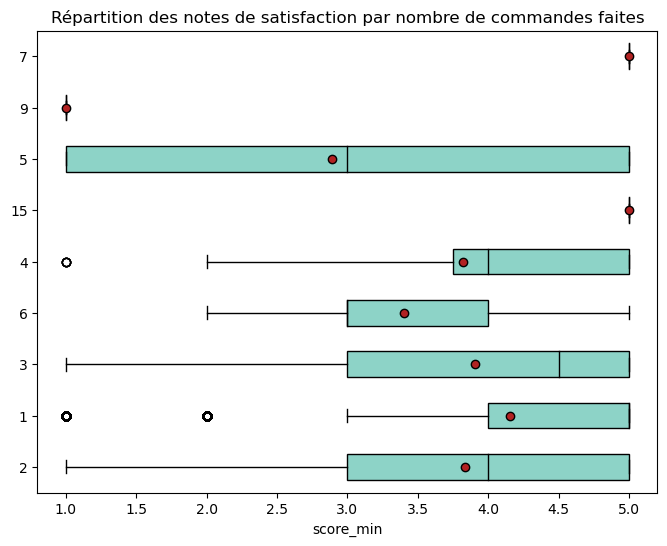

In [82]:
# Note min laissée par les clients en fonction du nombre de commandes qu'ils ont faites
# Répartition de la variable score_min par nb de commandes :
y = 'nombre_commandes' # qualitative
x = 'score_min' # quantitative

modalites = base_client_unique[y].unique()
groupes = []
for m in modalites:
    groupes.append(base_client_unique[base_client_unique[y]==m][x])

# Propriétés graphiques 
plt.figure(figsize=(8, 6))
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
plt.title(f"Répartition des notes de satisfaction par nombre de commandes faites")
plt.xlabel(f'{x}')
plt.boxplot(groupes, labels=modalites, showfliers=True, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)

plt.show()

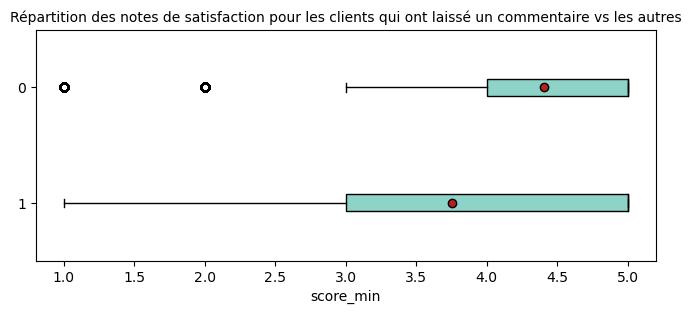

In [83]:
# Note min laissée par les clients en fonction du nombre de commandes qu'ils ont faites
# Répartition de la variable score_min par nb de commandes :
y = 'commentaire_client' # qualitative
x = 'score_min' # quantitative

modalites = base_client_unique[y].unique()
groupes = []
for m in modalites:
    groupes.append(base_client_unique[base_client_unique[y]==m][x])

# Propriétés graphiques 
plt.figure(figsize=(8, 3))
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
plt.title(f"Répartition des notes de satisfaction pour les clients qui ont laissé un commentaire vs les autres", fontsize=10)
plt.xlabel(f'{x}')
plt.boxplot(groupes, labels=modalites, showfliers=True, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)

plt.show()

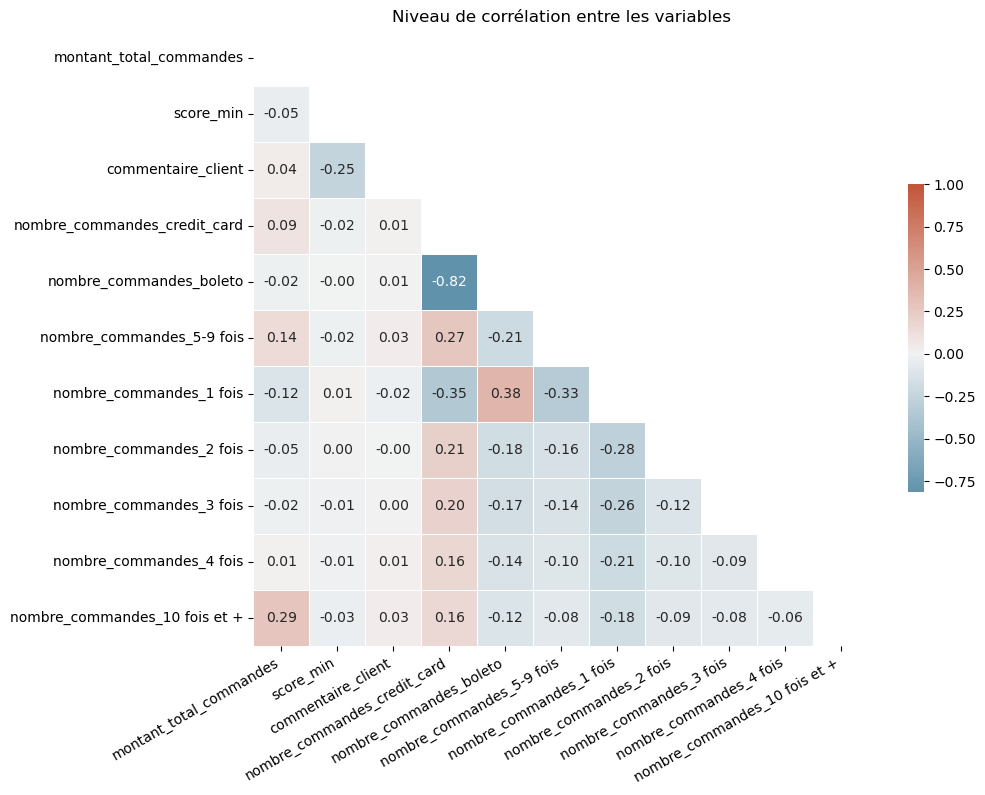

In [459]:
var_a_etudier = [
        'montant_total_commandes', 
        'score_min', 'commentaire_client', 
        'nombre_commandes_credit_card', 'nombre_commandes_boleto', 
        'nombre_commandes_5-9 fois', 'nombre_commandes_1 fois', 'nombre_commandes_2 fois', 'nombre_commandes_3 fois',
        'nombre_commandes_4 fois', 'nombre_commandes_10 fois et +'
       ]

# 'nombre_commandes_credit_card', 'nombre_commandes_boleto', 'nombre_commandes_voucher', 'nombre_commandes_debit_card',
# 'nombre_commandes_5-9 fois', 'nombre_commandes_1 fois',
# 'nombre_commandes_2 fois', 'nombre_commandes_3 fois',
# 'nombre_commandes_4 fois', 'nombre_commandes_10 fois et +',
# , 'geolocation_lat', 'geolocation_lng'
# 'nombre_commandes'
# 'nombre_commandes_voucher', 'nombre_commandes_debit_card',
# 'paiement_credit_card', 'paiement_xfois','nb_jour_reference', 
# 'nombre_produits_loisirs_divertissement', 'nombre_produits_divers', 'nombre_produits_maison_decoration',
#       'nombre_produits_bebe_sante_beaute', 'nombre_produits_jardi_brico',
#       'nombre_produits_electro_informatique',
#       'nombre_produits_mode_accessoires', 'nombre_produits_bureau',
#       'nombre_produits_nourriture_boissons', 'nombre_produits_auto' 

# Compute the correlation matrix
corr = base_client_unique[var_a_etudier].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f", annot_kws={"size": 10})

plt.xticks(rotation=30, ha='right')

plt.title('Niveau de corrélation entre les variables')
plt.show()

<div class="alert alert-block alert-info">
    <b> A RETENIR : </b> 
    
- 'commentaire_client' est inversement correlé avec le score min, un client qui laisse un commantaire est moins satisfait
- 'nombre_commandes_boleto' : boleto et credit card sont inversement correlés à 80% -> on garde uniquement credit card
- comptant vs X fois : conserver uniquement la variable 'paiement_1 fois' - les autres variables vont toutes dans le même sens
</div>

## ETAPE 2 : Elaboration d'un modèle de clustering

ETAPE 2
- Réduction de dimension PCA
- Clustering sur les variables RFM : K-means - CAH - DBSCAN
- Réduction de dimension TSNE
- Test de clustering K-means sur les variables RFM + autres variables
- Clustering final sur les variables RFM + satisfaction + paiement comptant
- Caractérisation des clusters finaux

#### 0. Suppression des individus atypiques

In [84]:
# Supprimer les 2 individus atypiques :
base_client_unique_FILT = base_client_unique.drop(12915) # customer_unique_id = 0a0a92112bd4c708ca5fde585afaa872
base_client_unique_FILT = base_client_unique_FILT.drop(2269) # customer_unique_id = 8d50f5eadf50201ccdcedfb9e2ac8455

#### 1. Clustering des données sur les variables RFM

In [122]:
# RFM = ['nombre_commandes', 'nb_jour_reference', 'montant_total_commandes']
my_data = base_client_unique_FILT[['nombre_commandes', 'nb_jour_reference', 'montant_total_commandes']]

In [123]:
# transformer les données en array numpy
X = my_data.values

In [124]:
# Centrer - réduire les données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#### -- ACP --

In [125]:
pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)

PCA(n_components=2)

In [126]:
# % de variance expliquée :
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.37604298 0.33273396]
0.7087769396695214


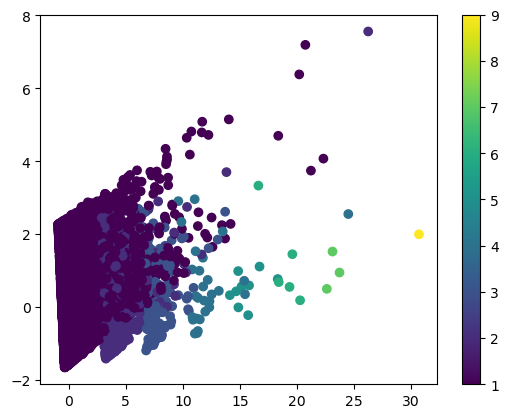

In [127]:
# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# afficher chaque observation
plt.scatter(X_projected[:, 0], X_projected[:, 1],
    # colorer en utilisant la variable c
    c=my_data['nombre_commandes'])

# plt.xlim([-5.5, 5.5])
# plt.ylim([-4, 4])
plt.colorbar()

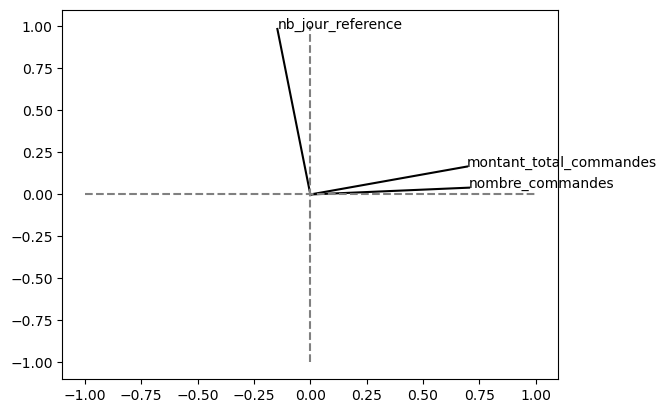

In [128]:
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, my_data.columns[i], fontsize='10')

# Afficher une ligne horizontale y=0
plt.plot([-1, 1], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-1,1], color='grey', ls='--')


#### -- Kmeans --

-- Evaluation du nb de clusters --

C:\Users\druar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\druar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\druar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\druar\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

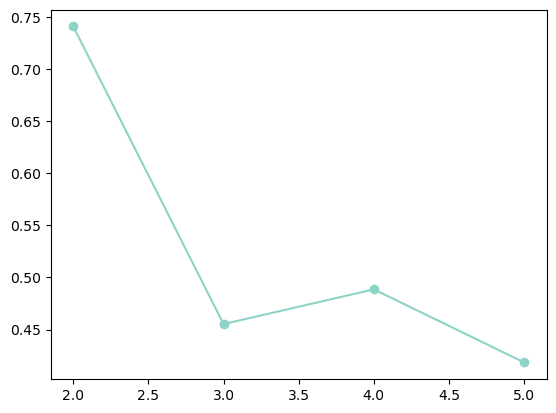

In [129]:
# 0. Evaluation du nb de cluster optimal
silhouettes = []
for num_clusters in range(2,6):
    cls = cluster.KMeans(n_clusters = num_clusters, n_init=10)
    cls.fit(X_scaled)
    silh = metrics.silhouette_score(X_scaled,cls.labels_)
    silhouettes.append(silh)
    
plt.plot(range(2,6),silhouettes, marker='o')

<div class="alert alert-block alert-info">
    <b> A RETENIR : </b> 

- Le silhouette score permet d'évaluer la qualité d'un clustering
- Proche de 1 : Indique que le point est bien assigné à son propre cluster et est loin des autres clusters. Cela signifie une bonne séparation entre les clusters
- ici on choisirait plutôt un clustering en 3 ou 5 groupes.
</div>

-- Partition en N clusters avec Kmeans --

In [130]:
# 1. Choisissons le clustering avec kmeans 
rfm_clust = cluster.KMeans(n_clusters=4,n_init=10) # par défaut init='k-mean++', prend les points les plus éloignés pour accélérer la convergence
rfm_clust.fit(X_scaled)

KMeans(n_clusters=4, n_init=10)

In [131]:
labels_df = pd.DataFrame(rfm_clust.labels_, columns=['labels'])
effectifs = labels_df.value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['labels']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/labels_df['labels'].count())*100
print(tab.head(10))

  labels      n          %
0   (0,)  50427  54.163176
1   (1,)  37470  40.246182
2   (2,)   2760   2.964491
3   (3,)   2445   2.626152


-- Visualisation des clusters --

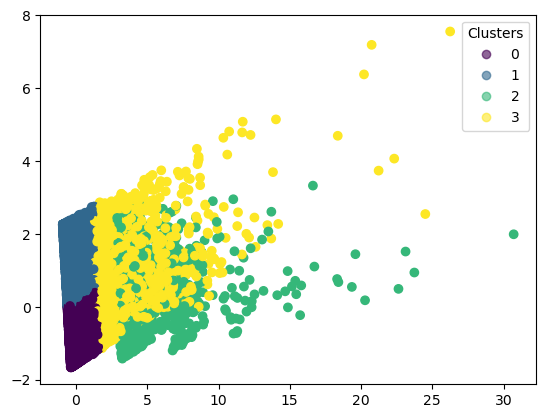

In [132]:
# 2. Visualisation sur les 2 premiers axes de l'ACP
# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# afficher chaque observation
scatter = plt.scatter(X_projected[:, 0], X_projected[:, 1],
    # colorer en utilisant la variable cluster
    c=rfm_clust.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

In [133]:
# rfm_clust.cluster_centers_ # Afficher les coordonnées des centroïdes sur les axes de l'ACP ou des axes d'origine
# plt.scatter(rfm_clust.cluster_centers_[:, 0], rfm_clust.cluster_centers_[:, 1], c='r')
# model.inertia_ # inertie = fonction coût de notre modèle, somme des distances entre les points d'un cluster et le centroïde

In [134]:
# Représenter le clustering sur les variables brutes de départ
# Supprimer les 2 individus atypiques :
var_brutes = base_client_unique.drop(12915) # customer_unique_id = 0a0a92112bd4c708ca5fde585afaa872
var_brutes = var_brutes.drop(2269) # customer_unique_id = 8d50f5eadf50201ccdcedfb9e2ac8455

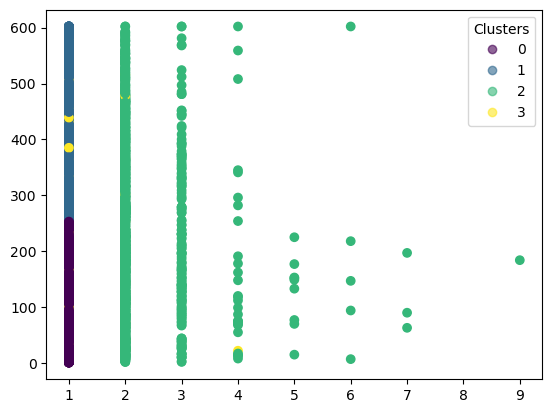

In [135]:
# 2. Visualisation sur les 2 axes nb_commandes et récence du dernier achat

# afficher chaque observation
scatter = plt.scatter(var_brutes['nombre_commandes'], var_brutes['nb_jour_reference'],
    # colorer en utilisant la variable cluster
    c=rfm_clust.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

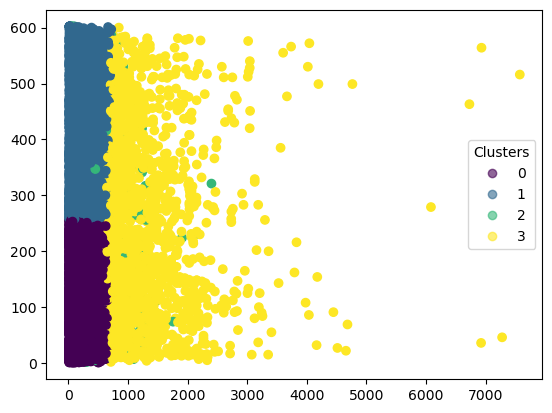

In [136]:
# 2. Visualisation sur les 2 axes montant_commandes et récence du dernier achat

# afficher chaque observation
scatter = plt.scatter(var_brutes['montant_total_commandes'], var_brutes['nb_jour_reference'],
    # colorer en utilisant la variable cluster
    c=rfm_clust.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

-- Description des clusters --

In [137]:
# On ajoute la variable clusters à mon df d'orinige
my_data['clusters_kmeans'] = rfm_clust.labels_
# On décrit les clusters sur les variables de mon df
stats_by_cluster = my_data.groupby('clusters_kmeans').agg(['mean','min', 'max', 'median'])
# Afficher les statistiques
stats_by_cluster.head()

C:\Users\druar\AppData\Local\Temp\ipykernel_20292\3716017167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data['clusters_kmeans'] = rfm_clust.labels_


nombre_commandes                nb_jour_reference            \
                            mean min max median              mean  min  max   
clusters_kmeans                                                               
0                       1.000000   1   1    1.0        128.093839    1  257   
1                       1.000000   1   1    1.0        385.256952  257  602   
2                       2.109783   2   9    2.0        220.285145    2  602   
3                       1.012270   1   4    1.0        239.142740    2  600   

                       montant_total_commandes                           
                median                    mean     min      max  median  
clusters_kmeans                                                          
0                129.0              134.198407    9.59   676.16  103.60  
1                373.0              133.038116   10.07   719.76  101.34  
2                200.0              289.816359   35.94  2400.48  224.28  
3                226.0             1148.988814  629.48  7571.63  926.30

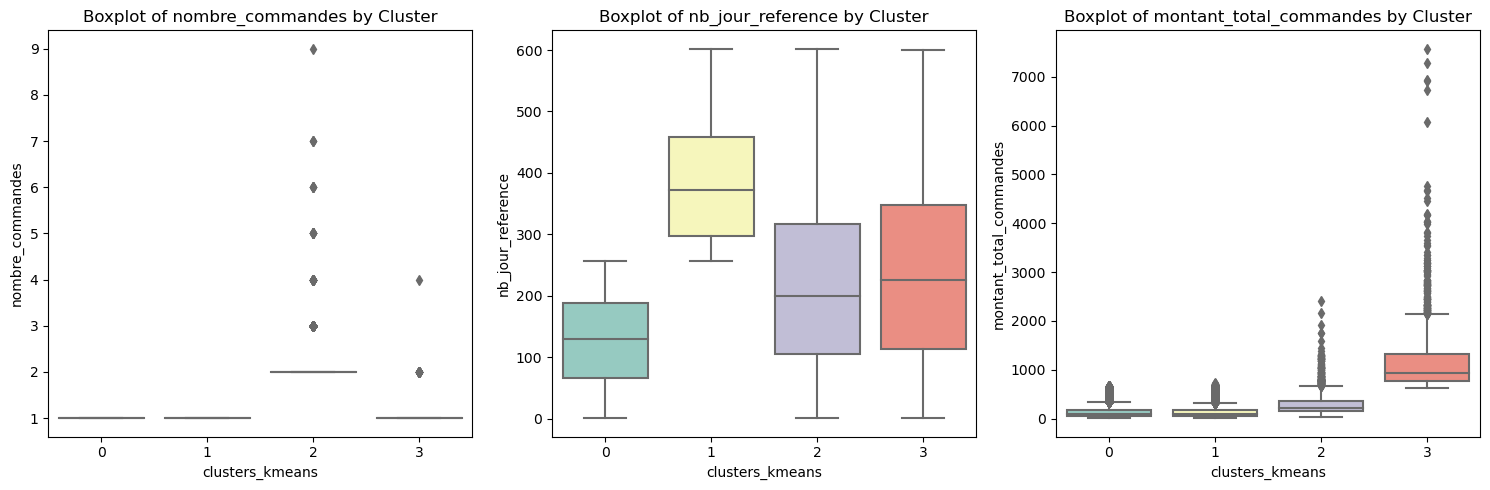

In [138]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(15, 5))

for i, var in enumerate(['nombre_commandes', 'nb_jour_reference', 'montant_total_commandes']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='clusters_kmeans', y=var, data=my_data)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
    <b> A RETENIR : </b> 

- Clustering réalisé avec 3, 4 et 5 clusters
- Dans les 3 clustering il y a toujours un groupe de 3% correspondants aux clients ayant réalisé plus d'une commande
- Les autres clusters sont ensuite déterminés par le montant et l'ancienneté : 1 cluster montant élevé, 2 ou 3 clusters par ancienneté
</div>

#### -- CAH --

-- Evaluation du nb de clusters --

In [198]:
# Réduire l'échantillon : l'algorithme de clustering hiérarchique est lourd et nécessite un temps de calcul et un espace  
# mémoire conséquent (pas possible avec notre jeu de données), on prend donc un échantillon de la base = 50% des individus
my_data_sample = my_data.sample(frac=0.5, random_state=42)
# transformer les données en array numpy
X_sample = my_data_sample.values
# Centrer - réduire les données
std_scale = preprocessing.StandardScaler().fit(X_sample)
X_scaled_sample = std_scale.transform(X_sample)

In [109]:
# 1. Choisissons le clustering CAH 
rfm_cah = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None)
rfm_cah.fit(X_scaled_sample)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

In [110]:
# Pour afficher le dendrograme de la CAH
def plot_dendrogram(model, **kwargs):
    ''' Create linkage matrix and then plot the dendrogram '''

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

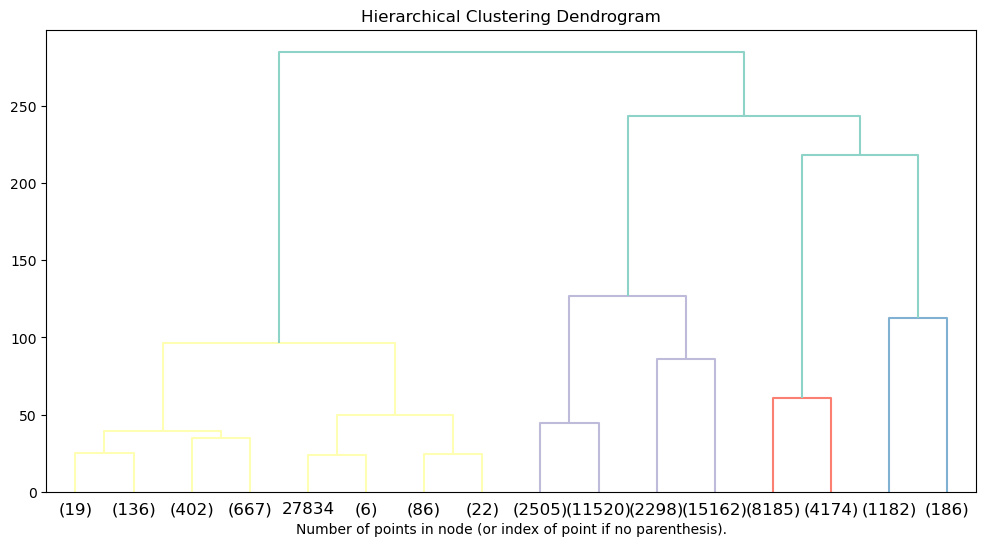

In [111]:
plt.figure(figsize=(12, 6))
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(rfm_cah, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

<div class="alert alert-block alert-info">
    <b> ANALYSE DU DENDROGRAMME : </b> 

- Le dendrogramme permet de visulaliser la manière dont les clients se regroupent à chaque étape de l'algorithme
- La hauteur à laquelle deux points ou clusters sont reliés représente la distance ou la dissimilarité entre eux
- Le clustering optimal est celui qui coupe là ou les branches sont les plus longues, ici 4 clusters

</div>

#### -- CAH N clusters --

In [227]:
# 1. Choisissons le clustering CAH 
rfm_cah_N = cluster.AgglomerativeClustering(n_clusters=5)
rfm_cah_N.fit(X_scaled_sample)

AgglomerativeClustering(n_clusters=5)

In [154]:
print(f"Silhouette Coefficient: {metrics.silhouette_score(X_scaled_sample, rfm_cah_N.labels_):.3f}")

Silhouette Coefficient: 0.384


<div class="alert alert-block alert-info">
    <b> QUALITE DU CLUSTERING : </b> 
    
- N = 3 : Silhouette Coefficient: 0.483
- N = 4 : Silhouette Coefficient: 0.490
- N = 5 : Silhouette Coefficient: 0.384
    
</div>

In [228]:
labels_df = pd.DataFrame(rfm_cah_N.labels_, columns=['labels'])
effectifs = labels_df.value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['labels']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/labels_df['labels'].count())*100
print(tab.head(10))

  labels      n          %
0   (2,)  17460  37.507250
1   (4,)  14025  30.128246
2   (3,)  12359  26.549376
3   (0,)   1368   2.938712
4   (1,)   1339   2.876415


-- Visualisation des clusters --

In [201]:
pca_sample = decomposition.PCA(n_components=2)
pca_sample.fit(X_scaled_sample)

PCA(n_components=2)

In [202]:
# % de variance expliquée :
print(pca_sample.explained_variance_ratio_)
print(pca_sample.explained_variance_ratio_.sum())

[0.37510008 0.33310535]
0.708205430320918


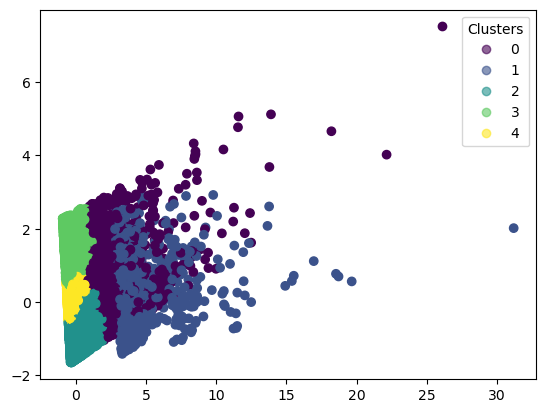

In [229]:
# 2. Visualisation sur les 2 premiers axes de l'ACP
# afficher chaque observation
# projeter X sur les composantes principales
X_projected_sample = pca.transform(X_scaled_sample)

scatter = plt.scatter(X_projected_sample[:, 0], X_projected_sample[:, 1],
    # colorer en utilisant la variable cluster
    c=rfm_cah_N.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

In [230]:
# Représenter le clustering sur les variables brutes de départ
# Supprimer les 2 individus atypiques :
var_brutes = base_client_unique.drop(12915) # customer_unique_id = 0a0a92112bd4c708ca5fde585afaa872
var_brutes = var_brutes.drop(2269) # customer_unique_id = 8d50f5eadf50201ccdcedfb9e2ac8455
var_brutes_sample = var_brutes.sample(frac=0.5, random_state=42)

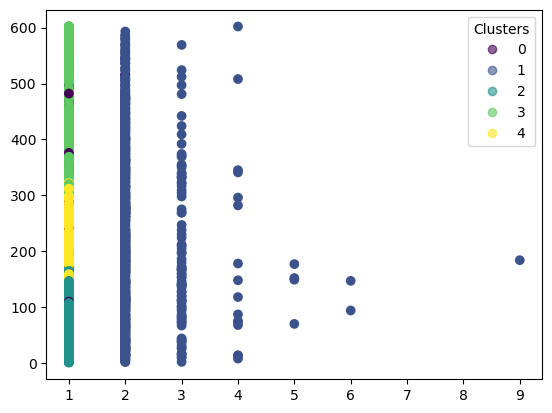

In [231]:
# 2. Visualisation sur les 2 axes nb_commandes et récence du dernier achat

# afficher chaque observation
scatter = plt.scatter(var_brutes_sample['nombre_commandes'], var_brutes_sample['nb_jour_reference'],
    # colorer en utilisant la variable cluster
    c=rfm_cah_N.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

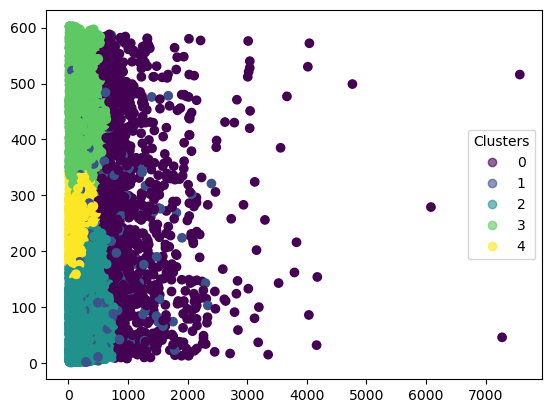

In [232]:
# 2. Visualisation sur les 2 axes nb_commandes et récence du dernier achat

# afficher chaque observation
scatter = plt.scatter(var_brutes_sample['montant_total_commandes'], var_brutes_sample['nb_jour_reference'],
    # colorer en utilisant la variable cluster
    c=rfm_cah_N.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

-- Description des clusters --

In [233]:
# On ajoute la variable clusters à mon df d'orinige
my_data_sample['clusters'] = rfm_cah_N.labels_
# On décrit les clusters sur les variables de mon df
stats_by_cluster = my_data_sample.groupby('clusters').agg(['mean','min', 'max', 'median'])
# Afficher les statistiques
stats_by_cluster.head()

nombre_commandes                nb_jour_reference                   \
                     mean min max median              mean  min  max median   
clusters                                                                      
0                1.001462   1   2    1.0        271.862573    8  588  275.0   
1                2.112771   2   9    2.0        221.314414    2  602  201.0   
2                1.000000   1   1    1.0         91.402577    1  253   91.0   
3                1.000000   1   1    1.0        433.809127  292  602  425.0   
4                1.000000   1   1    1.0        242.814759  146  361  241.0   

         montant_total_commandes                           clusters_cah      \
                            mean     min      max   median         mean min   
clusters                                                                      
0                    1082.085936  486.66  7571.63  883.105          2.0   2   
1                     303.606938   35.94  2400.48  227.250          1.0   1   
2                     148.761510    9.59   815.65  107.405          0.0   0   
3                     126.369587   10.07   662.62   98.370          3.0   3   
4                     116.646682   13.78   491.97   99.740          0.0   0   

                     
         max median  
clusters             
0          2    2.0  
1          1    1.0  
2          0    0.0  
3          3    3.0  
4          0    0.0

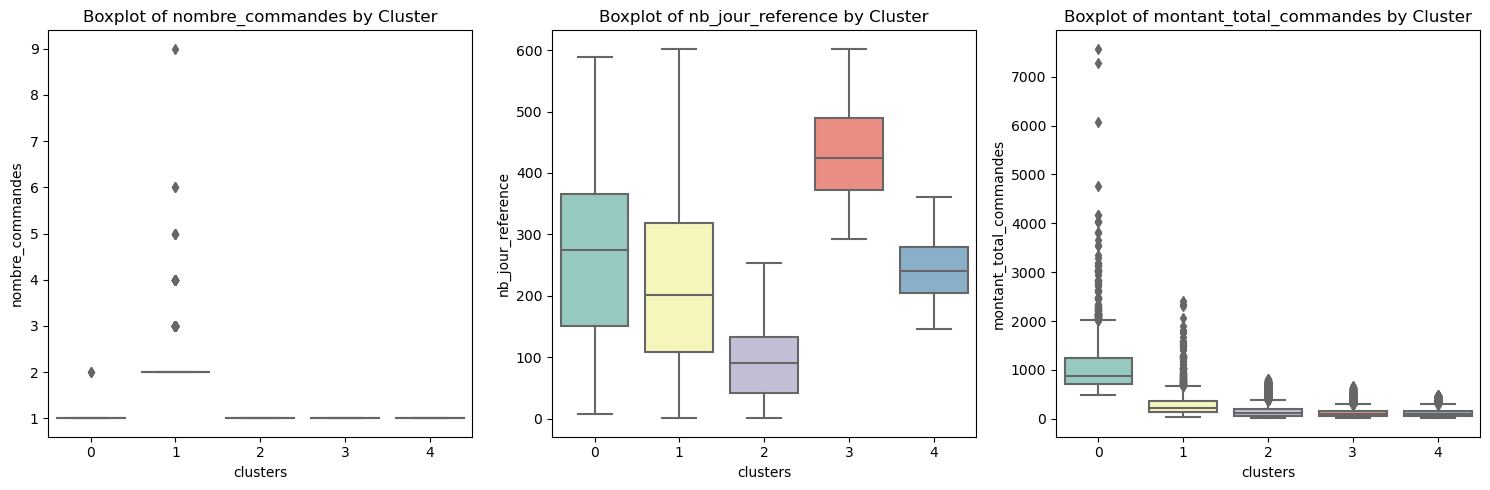

In [234]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(15, 5))

for i, var in enumerate(['nombre_commandes', 'nb_jour_reference', 'montant_total_commandes']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='clusters', y=var, data=my_data_sample)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
    <b> A RETENIR : </b> 
    
- Clustering réalisé par CAH avec 3, 4 et 5 clusters
- les résultats sont très similaires aux clusterings avec K-means
- les silhouettes score sont similaire également
- au vu du temps de calcul et de la mémoire nécessaire pour un résultat similaire, l'algorithme CAH n'est pas adapté à nos données
    
</div>

#### -- DBSCAN --

In [257]:
# 1. Choisissons le clustering DBSCAN
rfm_dbscan = cluster.DBSCAN(eps=0.8, min_samples=30)# 0.3 - 10
rfm_dbscan.fit(X_scaled)

DBSCAN(eps=0.8, min_samples=30)

In [258]:
labels = rfm_dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 235


In [176]:
print(f"Silhouette Coefficient: {metrics.silhouette_score(X_scaled, labels):.3f}")

Silhouette Coefficient: 0.715


In [259]:
labels_df = pd.DataFrame(labels, columns=['labels'])
effectifs = labels_df.value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['labels']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/labels_df['labels'].count())*100
print(tab.head(10))

  labels      n          %
0   (1,)  90222  96.906619
1   (0,)   2505   2.690597
2  (-1,)    235   0.252411
3   (2,)    140   0.150373


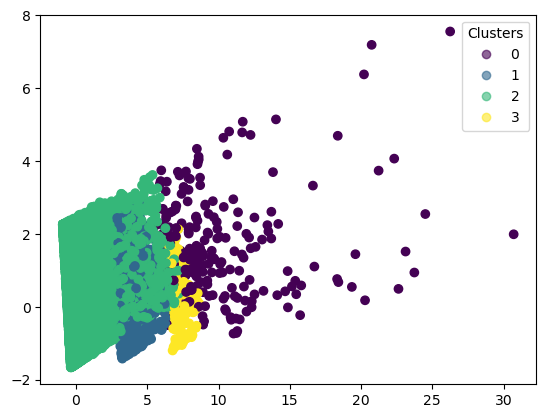

In [262]:
# 2. Visualisation sur les 2 premiers axes de l'ACP

# afficher chaque observation
scatter = plt.scatter(X_projected[:, 0], X_projected[:, 1],
    # colorer en utilisant la variable cluster
    c=rfm_dbscan.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

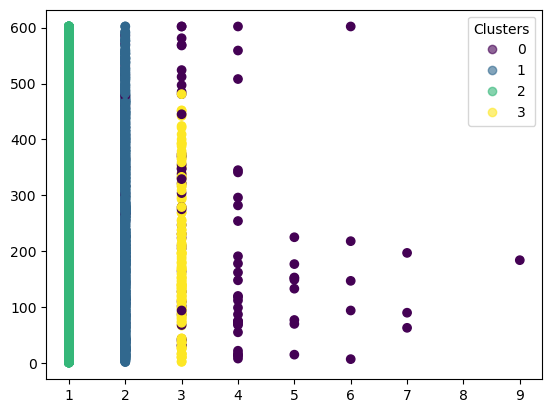

In [263]:
# 2. Visualisation sur les 2 axes nb_commandes et récence du dernier achat

# afficher chaque observation
scatter = plt.scatter(var_brutes['nombre_commandes'], var_brutes['nb_jour_reference'],
    # colorer en utilisant la variable cluster
    c=rfm_dbscan.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

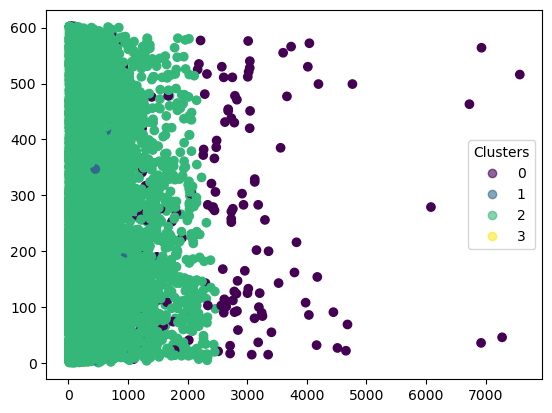

In [264]:
# 2. Visualisation sur les 2 axes nb_commandes et récence du dernier achat

# afficher chaque observation
scatter = plt.scatter(var_brutes['montant_total_commandes'], var_brutes['nb_jour_reference'],
    # colorer en utilisant la variable cluster
    c=rfm_dbscan.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

In [265]:
# On ajoute la variable clusters à mon df d'orinige
my_data['clusters'] = rfm_dbscan.labels_
# On décrit les clusters sur les variables de mon df
stats_by_cluster = my_data.groupby('clusters').agg(['mean','min', 'max', 'median'])
# Afficher les statistiques
stats_by_cluster.head()

C:\Users\druar\AppData\Local\Temp\ipykernel_22860\4121427212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data['clusters'] = rfm_dbscan.labels_


nombre_commandes                nb_jour_reference                  \
                     mean min max median              mean min  max median   
clusters                                                                     
-1               2.310638   1   9    2.0        252.327660   7  602  224.0   
 0               2.000000   2   2    2.0        221.139721   2  602  202.0   
 1               1.000000   1   1    1.0        237.725943   1  602  220.0   
 2               3.000000   3   3    3.0        187.821429   2  481  159.5   

         montant_total_commandes                          clusters_kmeans      \
                            mean    min      max   median            mean min   
clusters                                                                        
-1                   1950.460511  46.86  7571.63  1529.26        2.489362   2   
 0                    261.585381  35.94  1078.16   213.70        3.000000   3   
 1                    157.419535   9.59  2467.17   105.37        1.902729   0   
 2                    321.408714  87.60   725.80   280.91        3.000000   3   

                     
         max median  
clusters             
-1         3    2.0  
 0         3    3.0  
 1         4    1.0  
 2         3    3.0

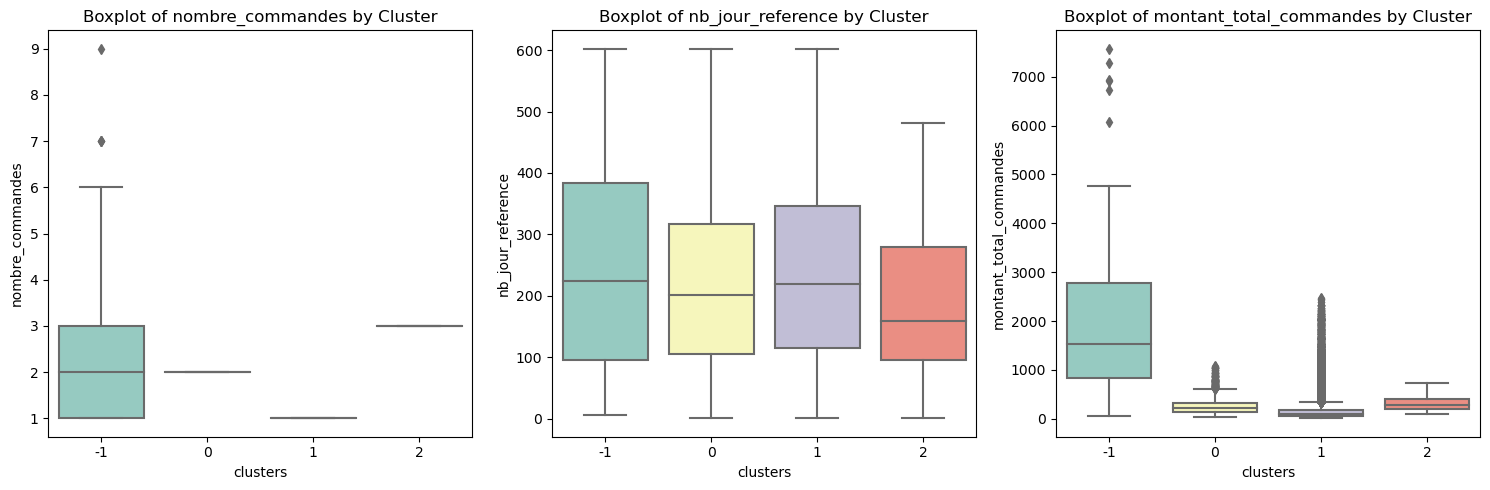

In [266]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(15, 5))

for i, var in enumerate(['nombre_commandes', 'nb_jour_reference', 'montant_total_commandes']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='clusters', y=var, data=my_data)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
    <b> A RETENIR : </b> 
    
- test de plusieurs valeurs de epsilon et min_samples
- l'algorithme parvient difficillement à splitter le gros groupe de 97% des clients ayant fait une commande
- le résultat : 3 clusters (97% 1 commande, 3% 2 commandes, 0.15% 3 commandes) + un cluster noise (= 0.25% clients ayant fait des commandes au montant élevé)
- le silhouette score est très bon (0.71) mais d'un point de vue métier ce n'est pas cohérent 
    
</div>

<div class="alert alert-block alert-info">
    <b> BILAN DE L'UTILISATION DES ALGORITHMES DE CLUSTERING K-MEANS, CAH ET DBSCAN : </b> 
    
- l'algorithme DBSCAN ne parvient pas à splitter les clients sur les variables pour un clustering cohérent d'un point de vue métier
- l'algorithme de clustering hiérarchique est trop complexe pour traiter notre volume de données et donne des résultats similaires à l'algo K-means
- avec un temps de calcul plus rapide et des clusters cohérents d'un point de vue métier, je conserve l'algorithme K-means pour réaliser le clustering de mes clients
    
</div>

#### 2. Clustering des données sur les variables RFM + satisfaction

In [139]:
# RFM + autres variables
my_data = base_client_unique_FILT[['nombre_commandes', 'nb_jour_reference', 'montant_total_commandes','score_min']]
# 'commentaire_client' redondant avec le score min
# 'nombre_commandes_boleto' : boleto et credit card sont inversement correlés à 80% -> garder uniquement credit card
# comptant vs X fois : conserver uniquement la variable 'nombre_commandes_1 fois' - les autres variables vont toutes dans le même sens
# ,'nombre_produits_loisirs_divertissement', 'nombre_produits_maison_decoration','nombre_produits_bebe_sante_beaute', 'nombre_produits_electro_informatique'

In [140]:
# transformer les données en array numpy
X = my_data.values

In [141]:
# Centrer - réduire les données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#### -- Kmeans --

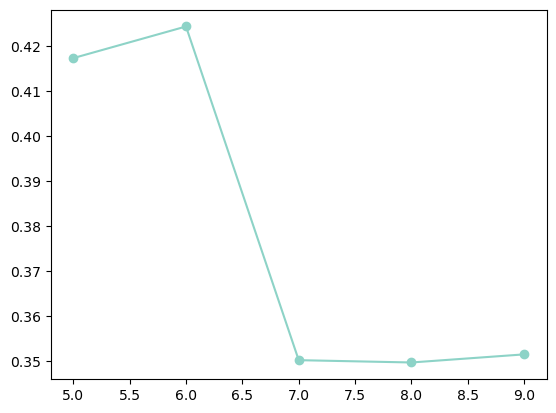

In [142]:
# Evaluation du nb de cluster optimal
silhouettes = []
for num_clusters in range(5,10):
    cls = cluster.KMeans(n_clusters = num_clusters, n_init=10)
    cls.fit(X_scaled)
    silh = metrics.silhouette_score(X_scaled,cls.labels_)
    silhouettes.append(silh)
    
plt.plot(range(5,10),silhouettes, marker='o')

In [155]:
# Choisissons le clustering optimal avec kmeans 
vars_clust = cluster.KMeans(n_clusters=6,n_init=10)
vars_clust.fit(X_scaled)

KMeans(n_clusters=6, n_init=10)

In [156]:
labels_df = pd.DataFrame(vars_clust.labels_, columns=['labels'])
effectifs = labels_df.value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['labels']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/labels_df['labels'].count())*100
print(tab.head(10))

  labels      n          %
0   (1,)  40228  43.208524
1   (0,)  30828  33.112071
2   (2,)  15234  16.362699
3   (4,)   3550   3.813022
4   (3,)   2765   2.969861
5   (5,)    497   0.533823


-- Visualisation des clusters sur la réduction de dimension par TSNE --

In [157]:
# Visualisation
# On applique tSNE aux données scalées :
tsne = manifold.TSNE(n_components=2, init='pca')
X_trans = tsne.fit_transform(X_scaled)

In [158]:
X_trans.shape

(93102, 2)

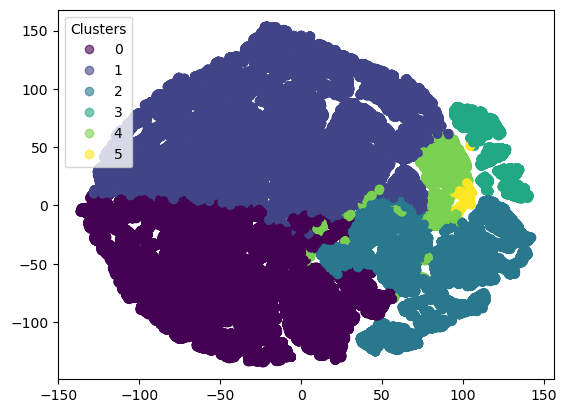

In [159]:
# Visualisation sur les 2 premiers axes de TSNE

# afficher chaque observation
scatter = plt.scatter(X_trans[:, 0], X_trans[:, 1],
    # colorer en utilisant la variable cluster
    c=vars_clust.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

In [160]:
# On ajoute la variable clusters à mon df d'orinige
my_data['clusters'] = vars_clust.labels_
# On décrit les clusters sur les variables de mon df
stats_by_cluster = my_data.groupby('clusters').agg(['mean','min', 'max', 'median'])
# Afficher les statistiques
stats_by_cluster.head(10)

C:\Users\druar\AppData\Local\Temp\ipykernel_20292\745521569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data['clusters'] = vars_clust.labels_


nombre_commandes                nb_jour_reference                   \
                     mean min max median              mean  min  max median   
clusters                                                                      
0                1.000000   1   1    1.0        391.927274  255  602  383.0   
1                1.000000   1   1    1.0        122.787859    1  258  120.0   
2                1.000000   1   1    1.0        230.583366    1  600  212.0   
3                2.109222   2   9    2.0        220.345750    2  602  200.0   
4                1.000000   1   1    1.0        233.299718    2  601  217.5   
5                1.052314   1   4    1.0        232.668008    5  581  208.0   

         montant_total_commandes                             score_min       \
                            mean      min      max    median      mean  min   
clusters                                                                      
0                     122.926229    10.07   568.90    97.635  4.634806  3.0   
1                     122.078004     9.59   510.96    99.555  4.698386  3.0   
2                     143.010786    13.78   697.23   110.665  1.713667  1.0   
3                     291.557964    35.94  2164.40   224.580  3.836269  1.0   
4                     743.900842   400.10  1423.21   681.040  4.280883  1.0   
5                    2082.849718  1391.35  7571.63  1869.800  3.814313  1.0   

                      
          max median  
clusters              
0         5.0    5.0  
1         5.0    5.0  
2         3.0    1.0  
3         5.0    4.0  
4         5.0    5.0  
5         5.0    5.0

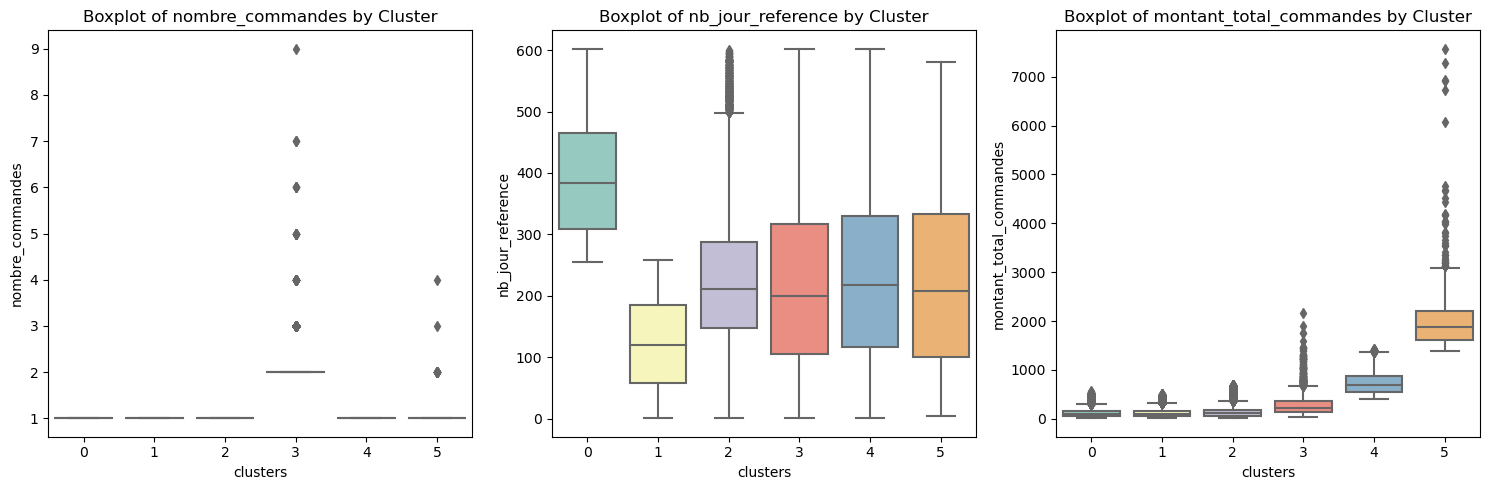

In [161]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(15, 5))

for i, var in enumerate(['nombre_commandes', 'nb_jour_reference', 'montant_total_commandes']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='clusters', y=var, data=my_data)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

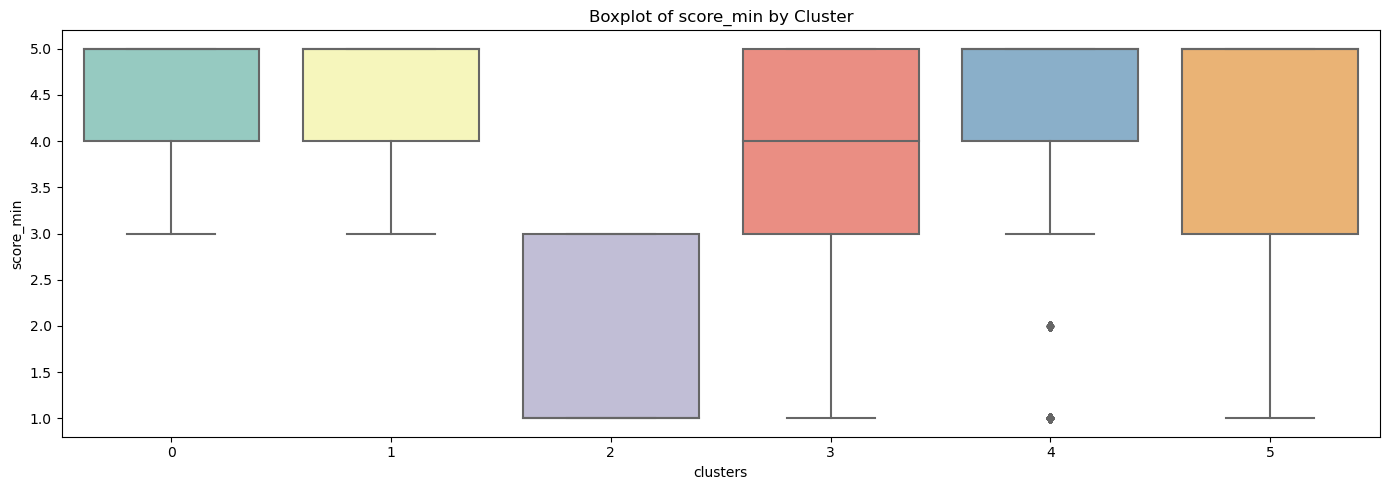

In [162]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(14, 5))

for i, var in enumerate(['score_min']):
    plt.subplot(1, 1, i+1)
    sns.boxplot(x='clusters', y=var, data=my_data)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

#### 3. Clustering des données sur les variables RFM + satisfaction + paiement comptant

In [163]:
# RFM + autres variables
my_data = base_client_unique_FILT[['nombre_commandes', 'nb_jour_reference', 'montant_total_commandes',
                                   'score_min','paiement_xfois']]
# 'commentaire_client' redondant avec le score min
# 'nombre_commandes_boleto' : boleto et credit card sont inversement correlés à 80% -> garder uniquement credit card
# comptant vs X fois : conserver uniquement la variable 'nombre_commandes_1 fois' - les autres variables vont toutes dans le même sens
# ,'nombre_produits_loisirs_divertissement', 'nombre_produits_maison_decoration','nombre_produits_bebe_sante_beaute', 'nombre_produits_electro_informatique'

In [164]:
# transformer les données en array numpy
X = my_data.values

In [165]:
# Centrer - réduire les données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#### -- ACP --

In [166]:
pca = decomposition.PCA(n_components=4)
pca.fit(X_scaled)

PCA(n_components=4)

In [167]:
# % de variance expliquée :
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.25191858 0.20388772 0.19745718 0.18765001]
0.8409134994159836


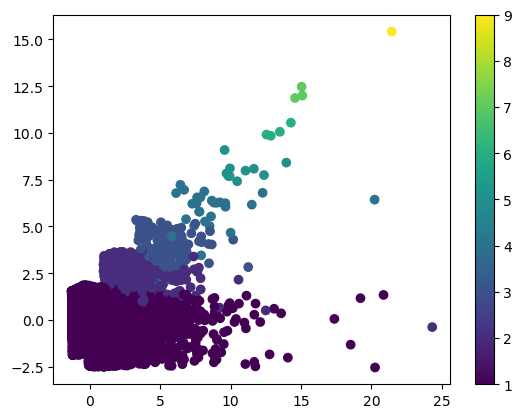

In [168]:
# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# afficher chaque observation
plt.scatter(X_projected[:, 0], X_projected[:, 1],
    # colorer en utilisant la variable c
    c=my_data['nombre_commandes'])

# plt.xlim([-5.5, 5.5])
# plt.ylim([-4, 4])
plt.colorbar()

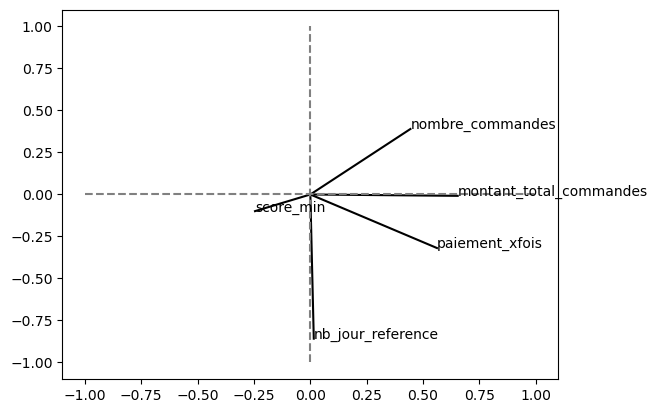

In [169]:
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, my_data.columns[i], fontsize='10')

# Afficher une ligne horizontale y=0
plt.plot([-1, 1], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-1,1], color='grey', ls='--')


#### -- Kmeans --

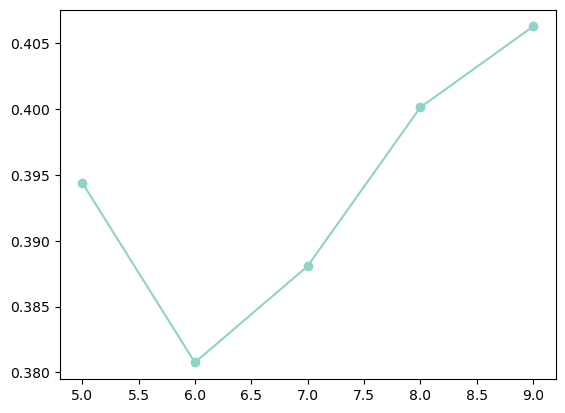

In [170]:
# Evaluation du nb de cluster optimal
silhouettes = []
for num_clusters in range(5,10):
    cls = cluster.KMeans(n_clusters = num_clusters, n_init=10)
    cls.fit(X_scaled)
    silh = metrics.silhouette_score(X_scaled,cls.labels_)
    silhouettes.append(silh)
    
plt.plot(range(5,10),silhouettes, marker='o')

In [178]:
# Choisissons le clustering optimal avec kmeans 
vars_clust = cluster.KMeans(n_clusters=6,n_init=10)
vars_clust.fit(X_scaled)

KMeans(n_clusters=6, n_init=10)

In [179]:
labels_df = pd.DataFrame(vars_clust.labels_, columns=['labels'])
effectifs = labels_df.value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['labels']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/labels_df['labels'].count())*100
print(tab.head(10))

  labels      n          %
0   (2,)  30566  32.830659
1   (0,)  27355  29.381753
2   (3,)  19382  20.818028
3   (1,)  11147  11.972890
4   (4,)   2760   2.964491
5   (5,)   1892   2.032180


-- Visualisation des clusters --

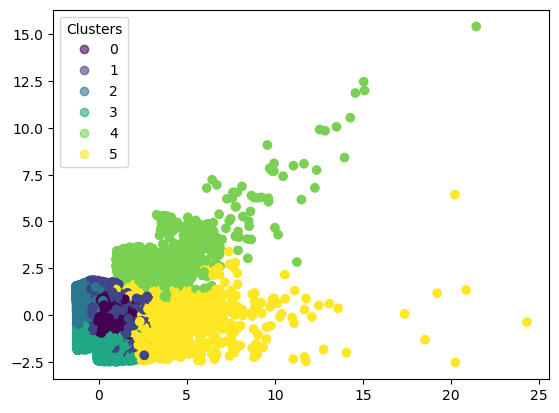

In [180]:
# Visualisation sur les 2 premiers axes de l'ACP
# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# afficher chaque observation
scatter = plt.scatter(X_projected[:, 0], X_projected[:, 1],
    # colorer en utilisant la variable cluster
    c=vars_clust.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

In [181]:
# Représenter le clustering sur les variables brutes de départ
# Supprimer les 2 individus atypiques :
var_brutes = base_client_unique.drop(12915) # customer_unique_id = 0a0a92112bd4c708ca5fde585afaa872
var_brutes = var_brutes.drop(2269) # customer_unique_id = 8d50f5eadf50201ccdcedfb9e2ac8455

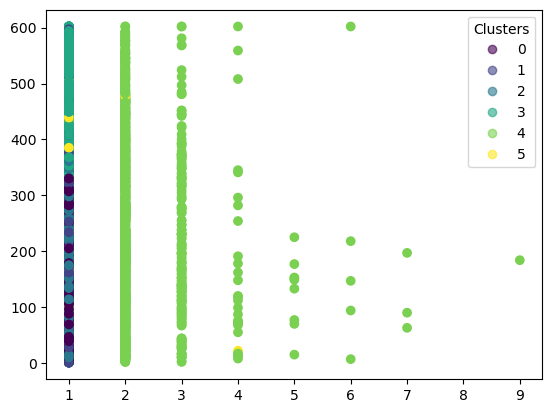

In [182]:
# Visualisation sur les 2 axes nb_commandes et récence du dernier achat

# afficher chaque observation
scatter = plt.scatter(var_brutes['nombre_commandes'], var_brutes['nb_jour_reference'],
    # colorer en utilisant la variable cluster
    c=vars_clust.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

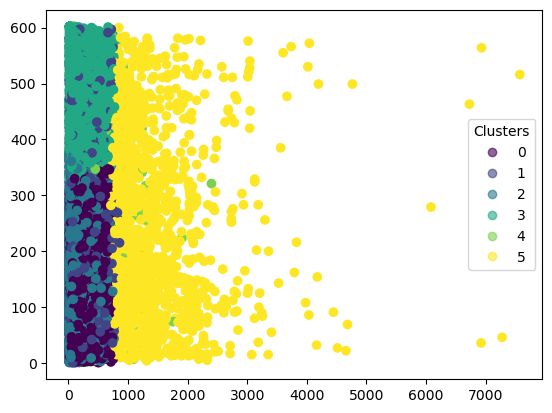

In [183]:
# Visualisation sur les 2 axes montant_commandes et récence du dernier achat

# afficher chaque observation
scatter = plt.scatter(var_brutes['montant_total_commandes'], var_brutes['nb_jour_reference'],
    # colorer en utilisant la variable cluster
    c=vars_clust.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

-- Visualisation des clusters sur la réduction de dimension par TSNE --

In [187]:
# Visualisation
# On applique tSNE aux données scalées :
tsne = manifold.TSNE(n_components=2, init='pca')
X_trans = tsne.fit_transform(X_scaled)

In [188]:
X_trans.shape

(93102, 2)

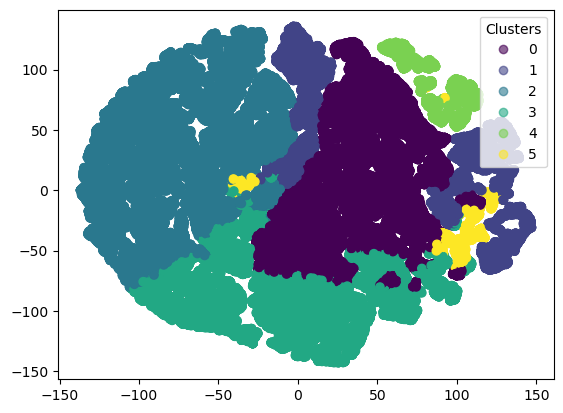

In [189]:
# Visualisation sur les 2 premiers axes de TSNE

# afficher chaque observation
scatter = plt.scatter(X_trans[:, 0], X_trans[:, 1],
    # colorer en utilisant la variable cluster
    c=vars_clust.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

In [184]:
# On ajoute la variable clusters à mon df d'orinige
my_data['clusters'] = vars_clust.labels_
# On décrit les clusters sur les variables de mon df
stats_by_cluster = my_data.groupby('clusters').agg(['mean','min', 'max', 'median'])
# Afficher les statistiques
stats_by_cluster.head(10)

C:\Users\druar\AppData\Local\Temp\ipykernel_20292\745521569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data['clusters'] = vars_clust.labels_


nombre_commandes                nb_jour_reference                   \
                     mean min max median              mean  min  max median   
clusters                                                                      
0                1.000000   1   1    1.0        161.613270    1  355  159.0   
1                1.000000   1   1    1.0        232.874765    1  600  209.0   
2                1.000000   1   1    1.0        172.549205    1  374  169.0   
3                1.000000   1   1    1.0        450.888505  326  602  446.0   
4                2.109783   2   9    2.0        220.285145    2  602  200.0   
5                1.015856   1   4    1.0        237.644820    4  600  217.0   

         montant_total_commandes                           score_min       \
                            mean     min      max   median      mean  min   
clusters                                                                    
0                     166.841213   20.08   762.40   134.13  4.574441  3.0   
1                     156.513212   13.89   859.02   116.36  1.232170  1.0   
2                     104.483902    9.59   766.32    77.01  4.586682  3.0   
3                     136.195263   12.28   783.00   102.82  4.558720  2.0   
4                     289.816359   35.94  2400.48   224.28  3.835248  1.0   
5                    1278.780782  695.61  7571.63  1061.54  4.062819  1.0   

                     paiement_xfois                   
          max median           mean  min  max median  
clusters                                              
0         5.0    5.0       1.000000  1.0  1.0    1.0  
1         3.0    1.0       0.541850  0.0  1.0    1.0  
2         5.0    5.0       0.000000  0.0  0.0    0.0  
3         5.0    5.0       0.590290  0.0  1.0    1.0  
4         5.0    4.0       0.644928  0.0  1.0    1.0  
5         5.0    5.0       0.760571  0.0  1.0    1.0

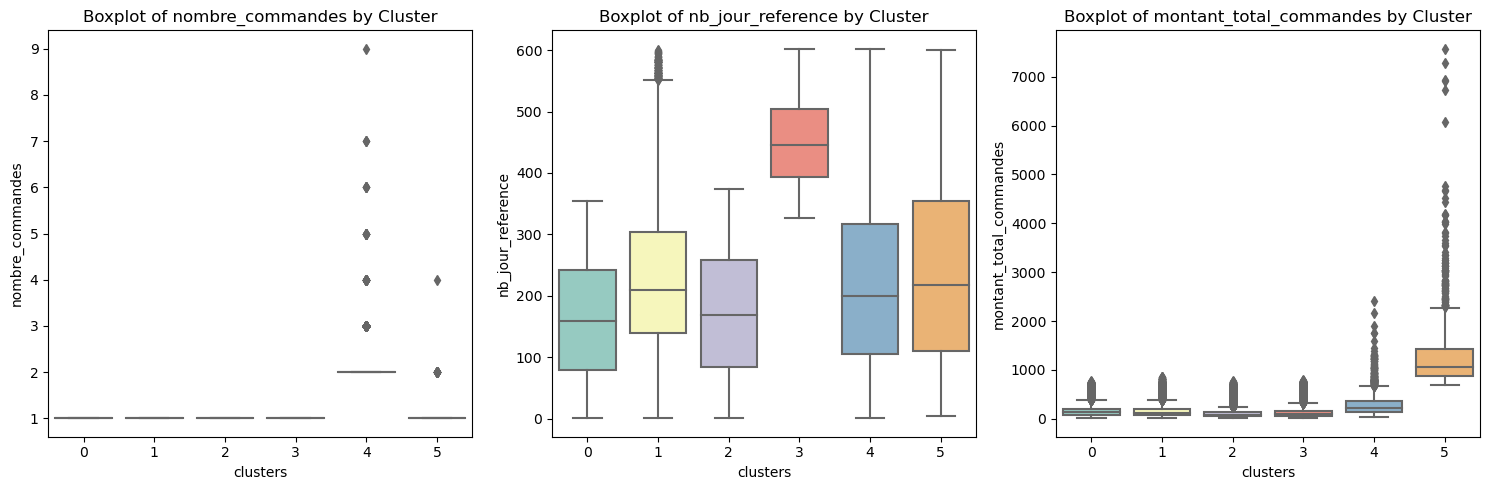

In [185]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(15, 5))

for i, var in enumerate(['nombre_commandes', 'nb_jour_reference', 'montant_total_commandes']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='clusters', y=var, data=my_data)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

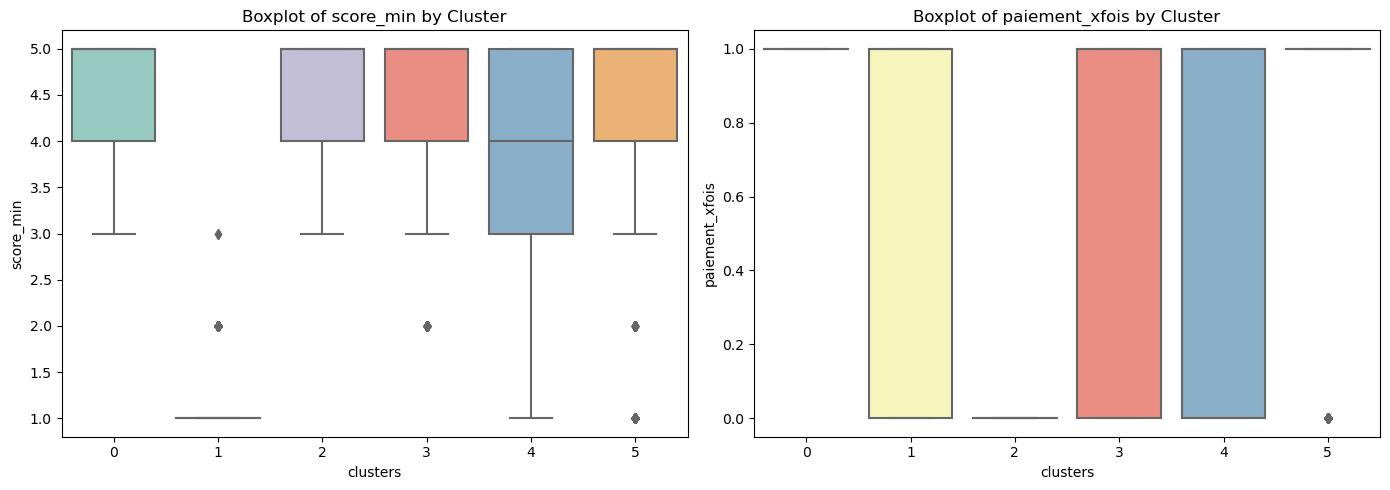

In [186]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(14, 5))

for i, var in enumerate(['score_min','paiement_xfois']):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x='clusters', y=var, data=my_data)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

-- 5 clusters --

In [190]:
# Choisissons le clustering optimal avec kmeans 
vars_clust = cluster.KMeans(n_clusters=5,n_init=10)
vars_clust.fit(X_scaled)

KMeans(n_clusters=5, n_init=10)

In [191]:
labels_df = pd.DataFrame(vars_clust.labels_, columns=['labels'])
effectifs = labels_df.value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['labels']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/labels_df['labels'].count())*100
print(tab.head(10))

  labels      n          %
0   (2,)  38663  41.527572
1   (0,)  38445  41.293420
2   (1,)  11243  12.076003
3   (3,)   2760   2.964491
4   (4,)   1991   2.138515


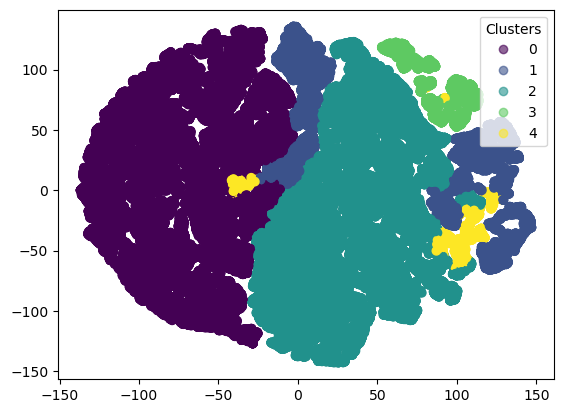

In [192]:
# Visualisation sur les 2 premiers axes de TSNE

# afficher chaque observation
scatter = plt.scatter(X_trans[:, 0], X_trans[:, 1],
    # colorer en utilisant la variable cluster
    c=vars_clust.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

In [193]:
# On ajoute la variable clusters à mon df d'orinige
my_data['clusters'] = vars_clust.labels_
# On décrit les clusters sur les variables de mon df
stats_by_cluster = my_data.groupby('clusters').agg(['mean','min', 'max', 'median'])
# Afficher les statistiques
stats_by_cluster.head(10)

C:\Users\druar\AppData\Local\Temp\ipykernel_20292\745521569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data['clusters'] = vars_clust.labels_


nombre_commandes                nb_jour_reference                  \
                     mean min max median              mean min  max median   
clusters                                                                     
0                1.000000   1   1    1.0        233.028144   1  602  214.0   
1                1.000000   1   1    1.0        235.961131   1  600  211.0   
2                1.000000   1   1    1.0        242.946693   1  600  228.0   
3                2.109783   2   9    2.0        220.285145   2  602  200.0   
4                1.015068   1   4    1.0        238.545455   4  600  215.0   

         montant_total_commandes                           score_min       \
                            mean     min      max   median      mean  min   
clusters                                                                    
0                     105.509106    9.59   735.85    77.34  4.583534  3.0   
1                     155.740264   13.89   850.92   116.17  1.239171  1.0   
2                     161.930340   20.08   722.21   129.32  4.574154  3.0   
3                     289.816359   35.94  2400.48   224.28  3.835248  1.0   
4                    1252.356012  695.61  7571.63  1037.79  4.074763  1.0   

                     paiement_xfois                   
          max median           mean  min  max median  
clusters                                              
0         5.0    5.0       0.000000  0.0  0.0    0.0  
1         2.0    1.0       0.542649  0.0  1.0    1.0  
2         5.0    5.0       1.000000  1.0  1.0    1.0  
3         5.0    4.0       0.644928  0.0  1.0    1.0  
4         5.0    5.0       0.758915  0.0  1.0    1.0

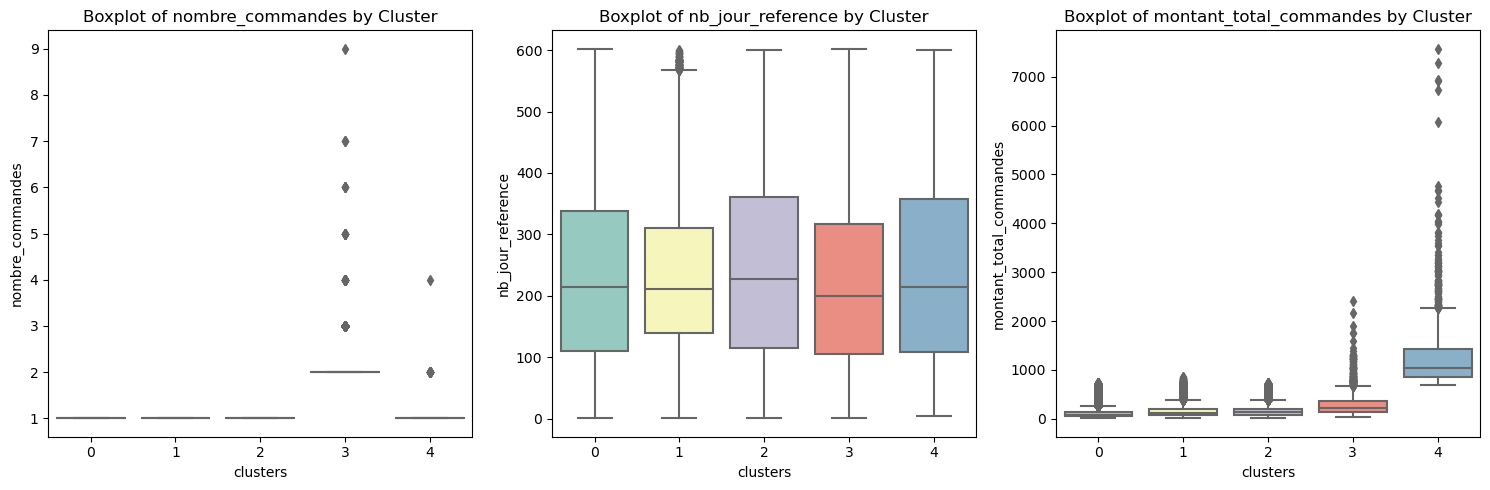

In [194]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(15, 5))

for i, var in enumerate(['nombre_commandes', 'nb_jour_reference', 'montant_total_commandes']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='clusters', y=var, data=my_data)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

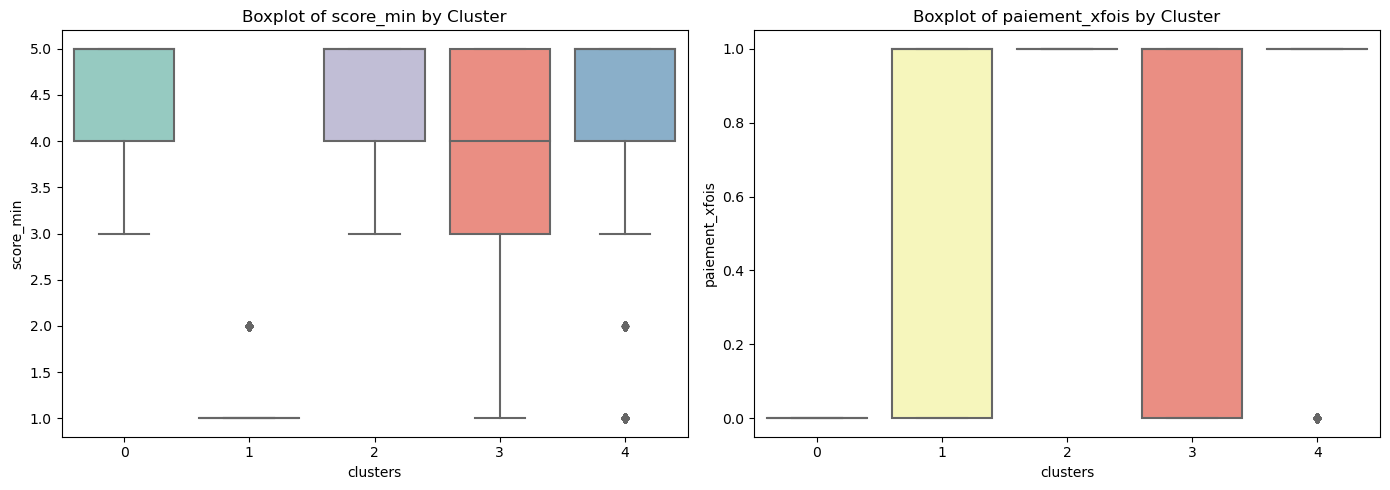

In [195]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(14, 5))

for i, var in enumerate(['score_min','paiement_xfois']):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x='clusters', y=var, data=my_data)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

#### 4. Clustering des données sur les variables RFM + satisfaction + type paiement + intallments

In [241]:
# RFM + autres variables
my_data = base_client_unique_FILT[['nombre_commandes', 'nb_jour_reference', 'montant_total_commandes',
                                   'paiement_credit_card','paiement_xfois','score_min']]
# 'commentaire_client' redondant avec le score min
# 'nombre_commandes_boleto' : boleto et credit card sont inversement correlés à 80% -> garder uniquement credit card
# comptant vs X fois : conserver uniquement la variable 'paiement_xfois' - les autres variables vont toutes dans le même sens
# ,'nombre_produits_loisirs_divertissement', 'nombre_produits_maison_decoration','nombre_produits_bebe_sante_beaute', 'nombre_produits_electro_informatique'

In [242]:
# transformer les données en array numpy
X = my_data.values

In [243]:
# Centrer - réduire les données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#### -- ACP --

In [244]:
pca = decomposition.PCA(n_components=4)
pca.fit(X_scaled)

PCA(n_components=4)

In [245]:
# % de variance expliquée :
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.269792   0.18614038 0.16773445 0.16151639]
0.7851832241929873


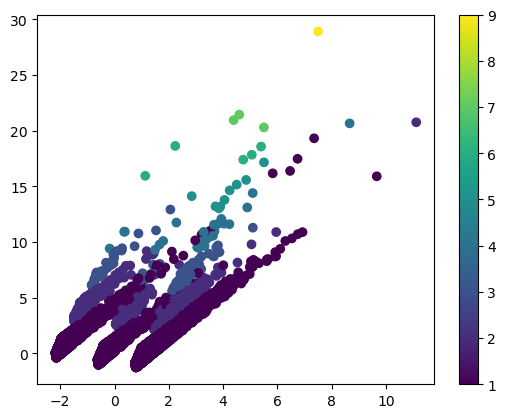

In [246]:
# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# afficher chaque observation
plt.scatter(X_projected[:, 0], X_projected[:, 1],
    # colorer en utilisant la variable c
    c=my_data['nombre_commandes'])

# plt.xlim([-5.5, 5.5])
# plt.ylim([-4, 4])
plt.colorbar()

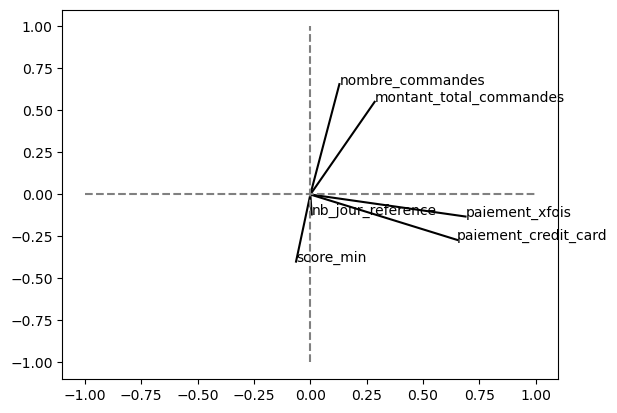

In [247]:
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, my_data.columns[i], fontsize='10')

# Afficher une ligne horizontale y=0
plt.plot([-1, 1], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-1,1], color='grey', ls='--')


#### -- Kmeans --

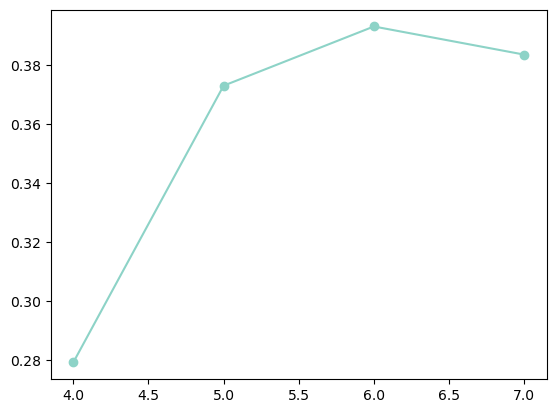

In [203]:
# Evaluation du nb de cluster optimal
silhouettes = []
for num_clusters in range(4,8):
    cls = cluster.KMeans(n_clusters = num_clusters, n_init=10)
    cls.fit(X_scaled)
    silh = metrics.silhouette_score(X_scaled,cls.labels_)
    silhouettes.append(silh)
    
plt.plot(range(4,8),silhouettes, marker='o')

In [248]:
# Choisissons le clustering optimal avec kmeans 
vars_clust = cluster.KMeans(n_clusters=6,n_init=10)
vars_clust.fit(X_scaled)

KMeans(n_clusters=6, n_init=10)

In [249]:
labels_df = pd.DataFrame(vars_clust.labels_, columns=['labels'])
effectifs = labels_df.value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['labels']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/labels_df['labels'].count())*100
print(tab.head(10))

  labels      n          %
0   (2,)  38724  41.593091
1   (1,)  20563  22.086529
2   (4,)  18582  19.958755
3   (3,)  10639  11.427252
4   (5,)   2760   2.964491
5   (0,)   1834   1.969882


-- Visualisation des clusters --

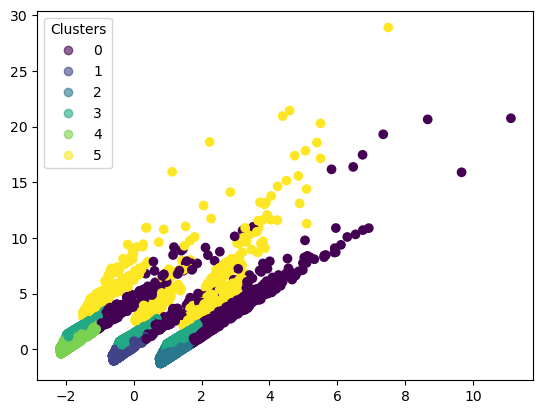

In [250]:
# Visualisation sur les 2 premiers axes de l'ACP
# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# afficher chaque observation
scatter = plt.scatter(X_projected[:, 0], X_projected[:, 1],
    # colorer en utilisant la variable cluster
    c=vars_clust.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

<div class="alert alert-block alert-info">
    <b> A RETENIR : </b> 
    
- les 2 premiers axes de l'ACP ne permettent pas de visualiser les clusters
- je vais tester la réduction de dimension avec l'algo t-SNE pour avoir une meilleure visualisation des clusters
    
</div>

-- Visualisation des clusters sur la réduction de dimension par TSNE --

In [224]:
# Visualisation
# On applique tSNE aux données scalées :
tsne = manifold.TSNE(n_components=2, init='pca')
X_trans = tsne.fit_transform(X_scaled)

In [225]:
X_trans.shape

(93102, 2)

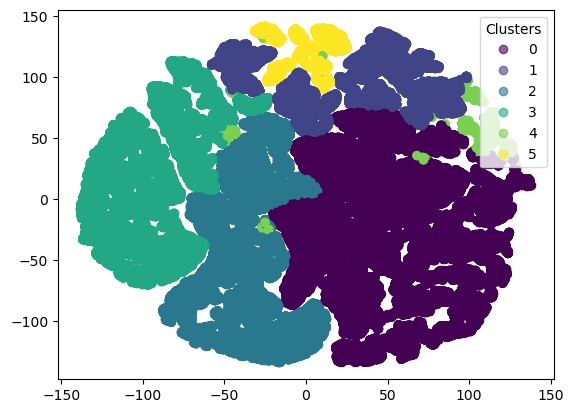

In [226]:
# Visualisation sur les 2 premiers axes de TSNE

# afficher chaque observation
scatter = plt.scatter(X_trans[:, 0], X_trans[:, 1],
    # colorer en utilisant la variable cluster
    c=vars_clust.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

In [251]:
# On ajoute la variable clusters à mon df d'orinige
my_data['clusters'] = vars_clust.labels_
# On décrit les clusters sur les variables de mon df
stats_by_cluster = my_data.groupby('clusters').agg(['mean','min', 'max', 'median'])
# Afficher les statistiques
stats_by_cluster.head(10)

C:\Users\druar\AppData\Local\Temp\ipykernel_20292\745521569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data['clusters'] = vars_clust.labels_


nombre_commandes                nb_jour_reference                  \
                     mean min max median              mean min  max median   
clusters                                                                     
0                1.016358   1   4    1.0        239.182661   4  600  215.0   
1                1.000000   1   1    1.0        225.169333   1  602  204.0   
2                1.000000   1   1    1.0        242.924543   1  600  228.0   
3                1.000000   1   1    1.0        235.346085   1  600  210.0   
4                1.000000   1   1    1.0        242.169573   1  602  227.0   
5                2.109783   2   9    2.0        220.285145   2  602  200.0   

         montant_total_commandes          ... paiement_credit_card         \
                            mean     min  ...                  max median   
clusters                                  ...                               
0                    1294.119335  717.23  ...                  1.0    1.0   
1                      93.577360    9.59  ...                  1.0    1.0   
2                     162.819482   20.08  ...                  1.0    1.0   
3                     158.479006   13.89  ...                  1.0    1.0   
4                     122.307237   12.28  ...                  0.0    0.0   
5                     289.816359   35.94  ...                  1.0    1.0   

         paiement_xfois                  score_min                   
                   mean  min  max median      mean  min  max median  
clusters                                                             
0              0.786805  0.0  1.0    1.0  4.058263  1.0  5.0    5.0  
1              0.000000  0.0  0.0    0.0  4.593464  3.0  5.0    5.0  
2              1.000000  1.0  1.0    1.0  4.574076  3.0  5.0    5.0  
3              0.574114  0.0  1.0    1.0  1.194849  1.0  2.0    1.0  
4              0.000000  0.0  0.0    0.0  4.486737  2.0  5.0    5.0  
5              0.644928  0.0  1.0    1.0  3.835248  1.0  5.0    4.0  

[6 rows x 24 columns]

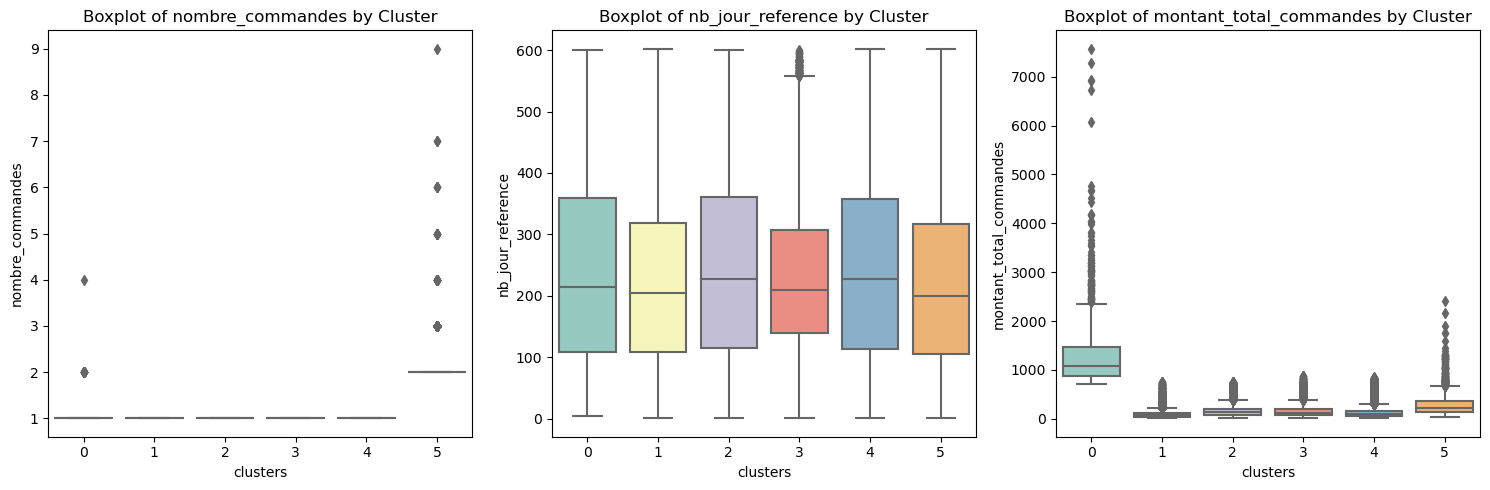

In [252]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(15, 5))

for i, var in enumerate(['nombre_commandes', 'nb_jour_reference', 'montant_total_commandes']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='clusters', y=var, data=my_data)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

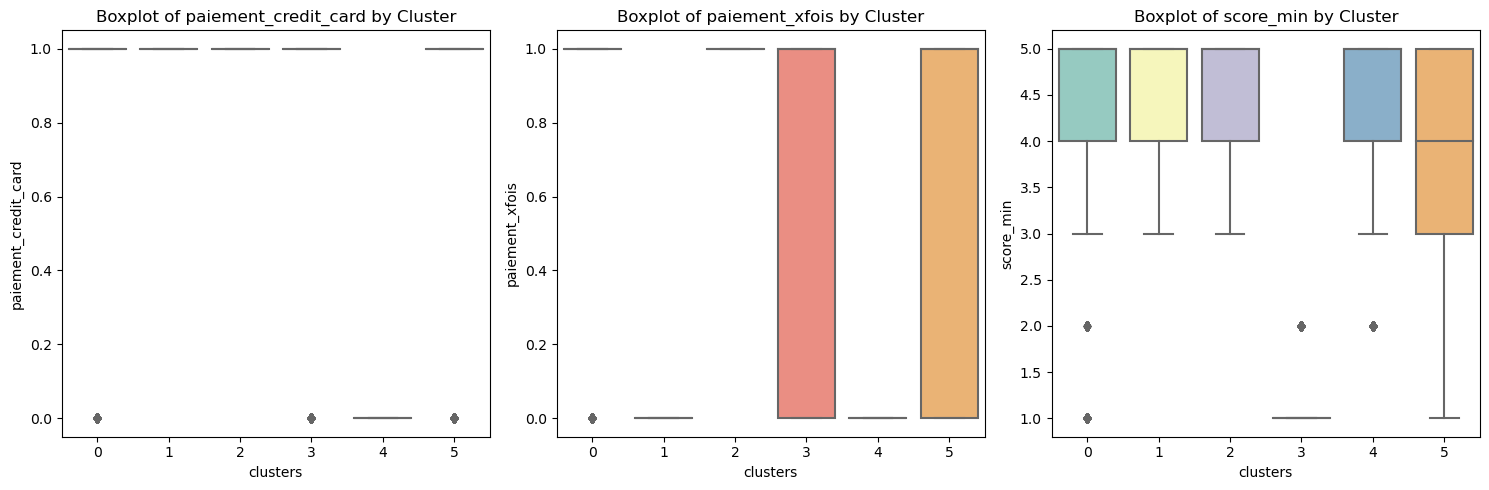

In [253]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(15, 5))

for i, var in enumerate(['paiement_credit_card','paiement_xfois','score_min']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='clusters', y=var, data=my_data)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

#### 5. Clustering des données sur les variables RFM + satisfaction + intallments + categ produit

In [254]:
# RFM + autres variables
my_data = base_client_unique_FILT[['nombre_commandes', 'nb_jour_reference', 'montant_total_commandes',
                                   'paiement_xfois','score_min',
                                  'nombre_produits_loisirs_divertissement', 'nombre_produits_maison_decoration',
                                   'nombre_produits_bebe_sante_beaute', 'nombre_produits_electro_informatique']]
# 'commentaire_client' redondant avec le score min
# 'nombre_commandes_boleto' : boleto et credit card sont inversement correlés à 80% -> garder uniquement credit card
# comptant vs X fois : conserver uniquement la variable 'nombre_commandes_1 fois' - les autres variables vont toutes dans le même sens
# ,'nombre_produits_loisirs_divertissement', 'nombre_produits_maison_decoration','nombre_produits_bebe_sante_beaute', 'nombre_produits_electro_informatique'

In [255]:
# transformer les données en array numpy
X = my_data.values

In [256]:
# Centrer - réduire les données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#### -- Kmeans --

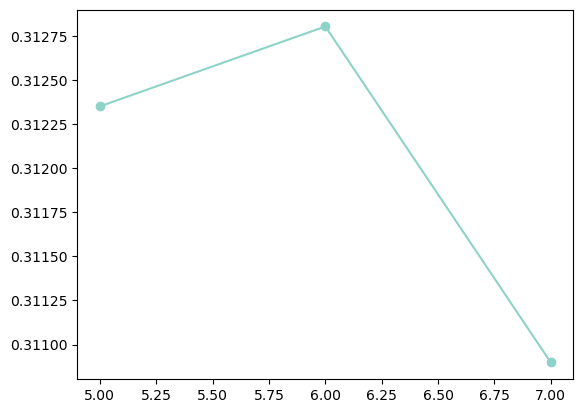

In [257]:
# Evaluation du nb de cluster optimal
silhouettes = []
for num_clusters in range(5,8):
    cls = cluster.KMeans(n_clusters = num_clusters, n_init=10)
    cls.fit(X_scaled)
    silh = metrics.silhouette_score(X_scaled,cls.labels_)
    silhouettes.append(silh)
    
plt.plot(range(5,8),silhouettes, marker='o')

In [264]:
# Choisissons le clustering optimal avec kmeans 
vars_clust = cluster.KMeans(n_clusters=6,n_init=10)
vars_clust.fit(X_scaled)

KMeans(n_clusters=6, n_init=10)

In [265]:
labels_df = pd.DataFrame(vars_clust.labels_, columns=['labels'])
effectifs = labels_df.value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['labels']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/labels_df['labels'].count())*100
print(tab.head(10))

  labels      n          %
0   (1,)  21833  23.450624
1   (4,)  21179  22.748169
2   (2,)  18982  20.388391
3   (0,)  14619  15.702133
4   (3,)  13696  14.710747
5   (5,)   2793   2.999936


-- Visualisation des clusters sur la réduction de dimension par TSNE --

In [270]:
# Visualisation
# On applique tSNE aux données scalées :
tsne = manifold.TSNE(n_components=2, init='pca')
X_trans = tsne.fit_transform(X_scaled)

In [271]:
X_trans.shape

(93102, 2)

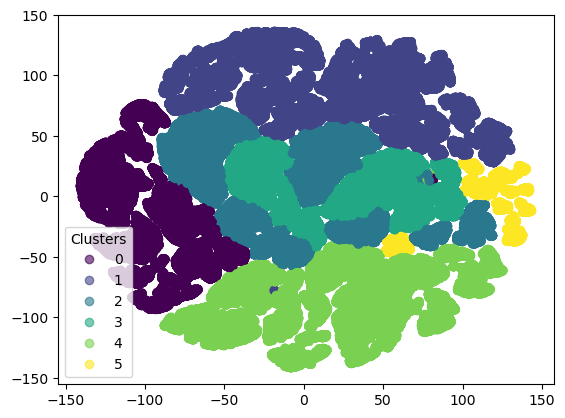

In [272]:
# Visualisation sur les 2 premiers axes de TSNE

# afficher chaque observation
scatter = plt.scatter(X_trans[:, 0], X_trans[:, 1],
    # colorer en utilisant la variable cluster
    c=vars_clust.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

In [266]:
# On ajoute la variable clusters à mon df d'orinige
my_data['clusters'] = vars_clust.labels_
# On décrit les clusters sur les variables de mon df
stats_by_cluster = my_data.groupby('clusters').agg(['mean','min', 'max', 'median'])
# Afficher les statistiques
stats_by_cluster.head(10)

C:\Users\druar\AppData\Local\Temp\ipykernel_20292\745521569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data['clusters'] = vars_clust.labels_


nombre_commandes                nb_jour_reference                  \
                     mean min max median              mean min  max median   
clusters                                                                     
0                1.000000   1   1    1.0        235.222929   1  601  209.0   
1                1.000000   1   1    1.0        246.161178   1  602  237.0   
2                1.000000   1   1    1.0        236.096881   1  602  220.0   
3                1.000000   1   1    1.0        225.165961   1  602  202.0   
4                1.000000   1   1    1.0        240.509892   1  602  222.0   
5                2.107411   1   9    2.0        220.291085   2  602  200.0   

         montant_total_commandes         ...  \
                            mean    min  ...   
clusters                                 ...   
0                     154.931677  12.39  ...   
1                     178.744629  12.89  ...   
2                     161.706737  10.07  ...   
3                     162.410177   9.59  ...   
4                     141.940482  13.78  ...   
5                     320.017863  35.94  ...   

         nombre_produits_maison_decoration         \
                                       max median   
clusters                                            
0                                      1.0    0.0   
1                                      1.0    0.0   
2                                      0.0    0.0   
3                                      1.0    0.0   
4                                      1.0    1.0   
5                                      1.0    0.0   

         nombre_produits_bebe_sante_beaute                   \
                                      mean  min  max median   
clusters                                                      
0                                 0.000137  0.0  1.0    0.0   
1                                 0.000000  0.0  0.0    0.0   
2                                 0.000000  0.0  0.0    0.0   
3                                 1.000000  1.0  1.0    1.0   
4                                 0.000000  0.0  0.0    0.0   
5                                 0.199069  0.0  1.0    0.0   

         nombre_produits_electro_informatique                   
                                         mean  min  max median  
clusters                                                        
0                                    1.000000  1.0  1.0    1.0  
1                                    0.000046  0.0  1.0    0.0  
2                                    0.000000  0.0  0.0    0.0  
3                                    0.000292  0.0  1.0    0.0  
4                                    0.000000  0.0  0.0    0.0  
5                                    0.207662  0.0  1.0    0.0  

[6 rows x 36 columns]

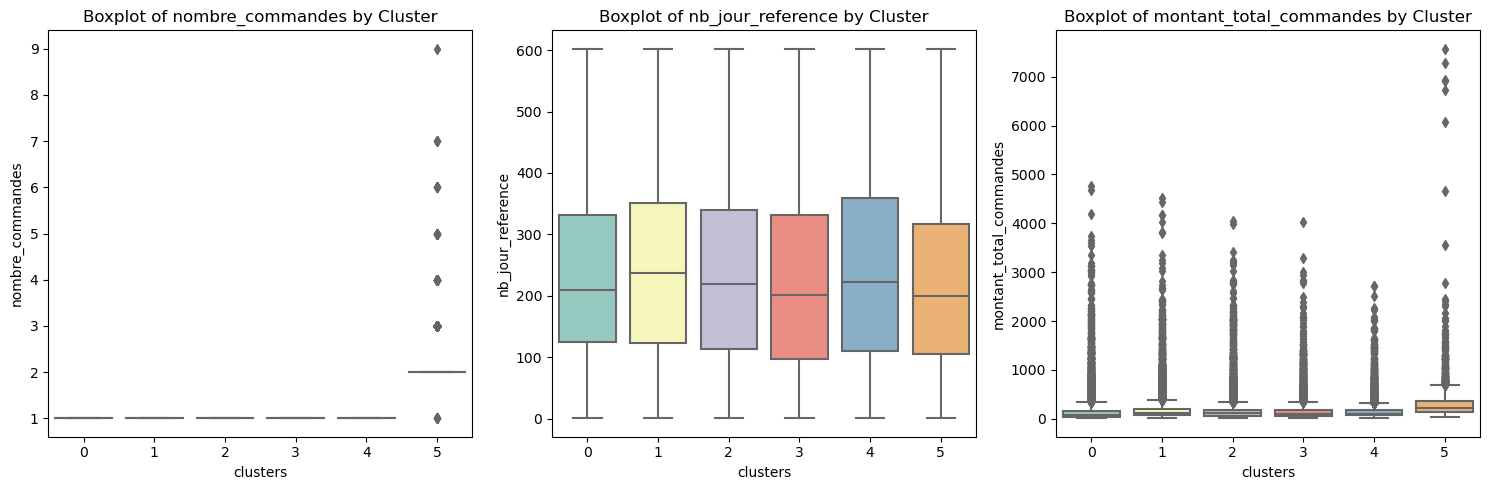

In [267]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(15, 5))

for i, var in enumerate(['nombre_commandes', 'nb_jour_reference', 'montant_total_commandes']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='clusters', y=var, data=my_data)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

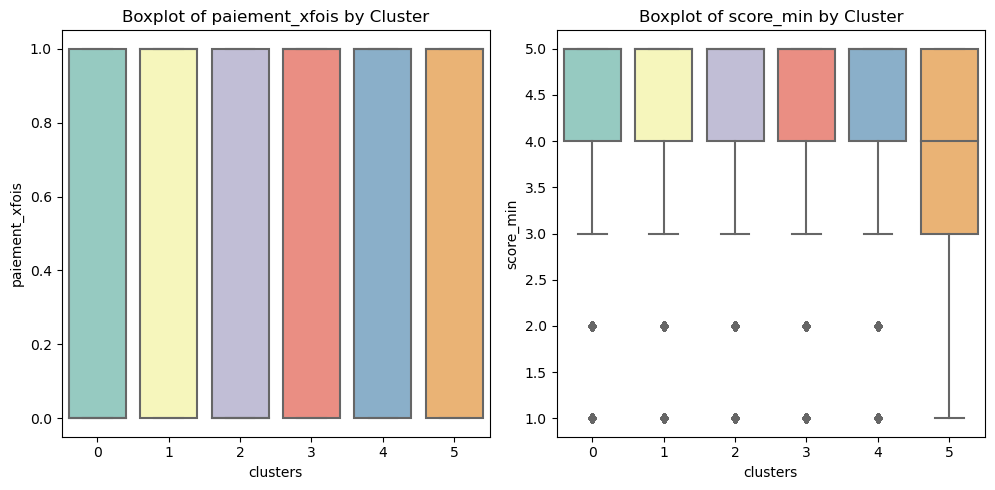

In [274]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(15, 5))

for i, var in enumerate(['paiement_xfois','score_min']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='clusters', y=var, data=my_data)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

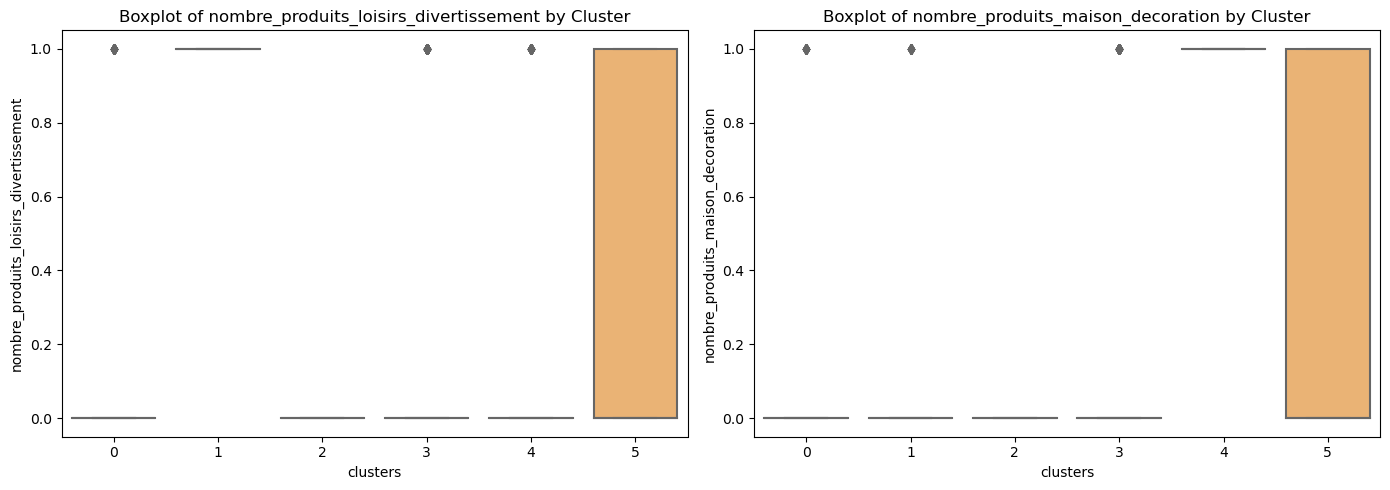

In [269]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(14, 5))

for i, var in enumerate(['nombre_produits_loisirs_divertissement', 'nombre_produits_maison_decoration']):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x='clusters', y=var, data=my_data)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

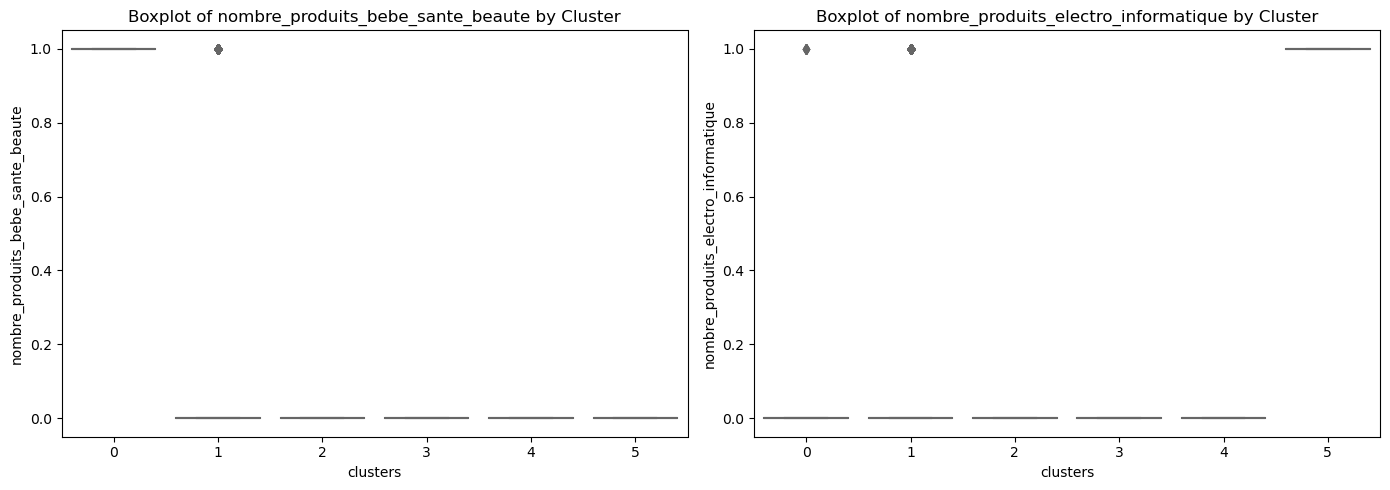

In [115]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(14, 5))

for i, var in enumerate(['nombre_produits_bebe_sante_beaute', 'nombre_produits_electro_informatique']):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x='clusters', y=var, data=my_data)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-info">
    <b> BILAN DU TEST DES MODELES DE CLUSTERING K-MEANS AVEC DIFFERENTES VARIABLES : </b> 

- tests effectués sur 6 clusters, cela semble un nb acceptable pour avoir un détail suffisant, en restant lisible ET au vu des coefficients de silhouettes observés sur les modèles    
- en intégrant la note de satisfaction dans le modèle, un cluster « d'insatisfaits » (= notes de 1 à 3) de 16% se créé en plus des groupes déjà observés avec les variables RFM (1 cluster « + 1 commande », 2 clusters « montants élevés »  et « très élevés » et 2 clusters 1 commande par ancienneté)
- en intégrant la note de satisfaction dans le modèle ET le paiement comptant, un cluster "de très insatisfaits" (= notes de 1) de 12% se créé, 1 cluster "+ 1 commande", 1 cluster « montants élevés », les autres clients sont splittés par ancienneté et paiement comptant/ plusieurs fois
- en intégrant la note de satisfaction dans le modèle ET le paiement par carte de crédit, les clusters ci-dessus évoluent très peu, la variable carte de crédit est assez proche de la variable paiement comptant -> choix de conserver la variable paiement comptant qui a plus de sens métier
- en intégrant les catégories de produits acheté, cela prend le pas sur l'ancienneté et le paiement comptant, ce qui ne semble pas pertinent d'un point de vue métier -> je n'intègre donc pas la catégorie de produit
</div>

#### 6. Clustering final sur les variables RFM + satisfaction + paiement comptant

In [85]:
# RFM + autres variables
my_data = base_client_unique_FILT[['nombre_commandes', 'nb_jour_reference', 'montant_total_commandes',
                                   'score_min','paiement_xfois']]

In [86]:
# transformer les données en array numpy
X = my_data.values

In [87]:
# Centrer - réduire les données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#### -- ACP --

In [88]:
pca = decomposition.PCA(n_components=4)
pca.fit(X_scaled)

PCA(n_components=4)

In [89]:
# % de variance expliquée :
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

[0.25191858 0.20388772 0.19745718 0.18765001]
0.8409134994159836


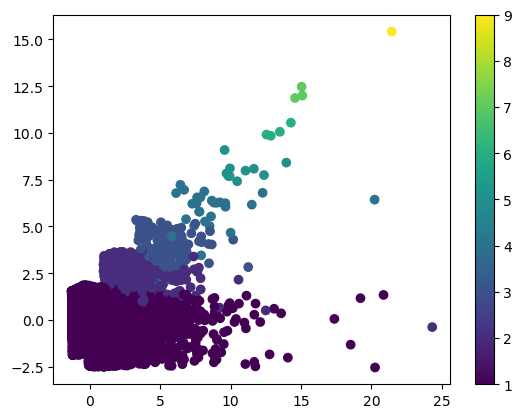

In [90]:
# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# afficher chaque observation
plt.scatter(X_projected[:, 0], X_projected[:, 1],
    # colorer en utilisant la variable c
    c=my_data['nombre_commandes'])

# plt.xlim([-5.5, 5.5])
# plt.ylim([-4, 4])
plt.colorbar()

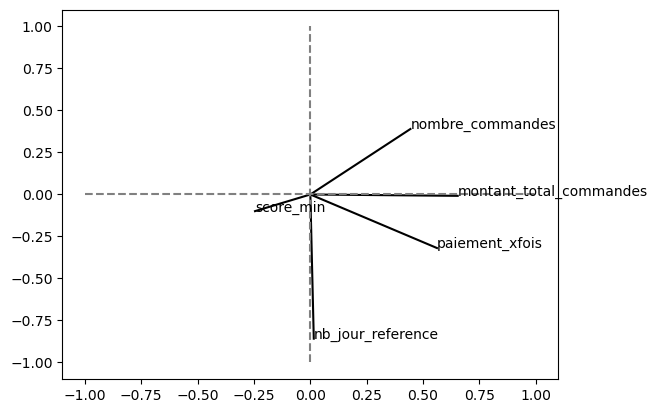

In [91]:
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, my_data.columns[i], fontsize='10')

# Afficher une ligne horizontale y=0
plt.plot([-1, 1], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-1,1], color='grey', ls='--')


#### -- Kmeans --

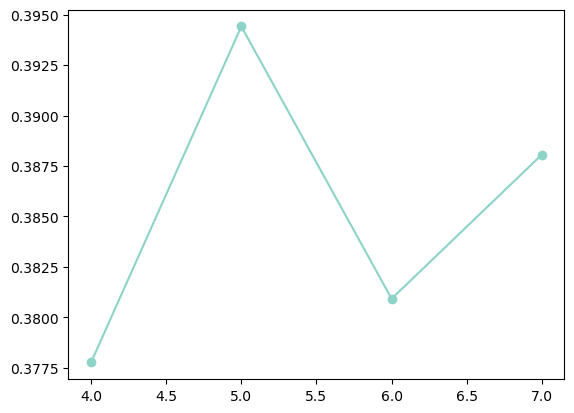

In [283]:
# Evaluation du nb de cluster optimal
silhouettes = []
for num_clusters in range(4,8):
    cls = cluster.KMeans(n_clusters = num_clusters, n_init=10)
    cls.fit(X_scaled)
    silh = metrics.silhouette_score(X_scaled,cls.labels_)
    silhouettes.append(silh)
    
plt.plot(range(4,8),silhouettes, marker='o')

In [98]:
# Choisissons le clustering optimal avec kmeans 
vars_clust = cluster.KMeans(n_clusters=6, n_init=10) # par défaut n_init=10, init='kmeans++' (initialiser les centroides les plus éloignés), max_iter = 300
vars_clust.fit(X_scaled)

KMeans(n_clusters=6, n_init=10)

In [99]:
labels_df = pd.DataFrame(vars_clust.labels_, columns=['labels'])
effectifs = labels_df.value_counts()
modalites = effectifs.index # l'index de effectifs contient les modalités
tab = pd.DataFrame(modalites, columns = ['labels']) # Création du tableau à partir des modalités
tab["n"] = effectifs.values
tab["%"] = (tab["n"]/labels_df['labels'].count())*100
print(tab.head(10))

  labels      n          %
0   (1,)  30544  32.807029
1   (3,)  27373  29.401087
2   (4,)  19384  20.820176
3   (2,)  11148  11.973964
4   (5,)   2760   2.964491
5   (0,)   1893   2.033254


-- Visualisation des clusters --

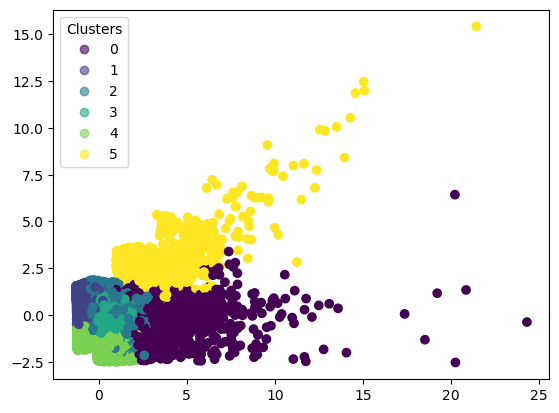

In [100]:
# Visualisation sur les 2 premiers axes de l'ACP
# projeter X sur les composantes principales
X_projected = pca.transform(X_scaled)

# afficher chaque observation
scatter = plt.scatter(X_projected[:, 0], X_projected[:, 1],
    # colorer en utilisant la variable cluster
    c=vars_clust.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

In [101]:
# Représenter le clustering sur les variables brutes de départ
# Supprimer les 2 individus atypiques :
var_brutes = base_client_unique.drop(12915) # customer_unique_id = 0a0a92112bd4c708ca5fde585afaa872
var_brutes = var_brutes.drop(2269) # customer_unique_id = 8d50f5eadf50201ccdcedfb9e2ac8455

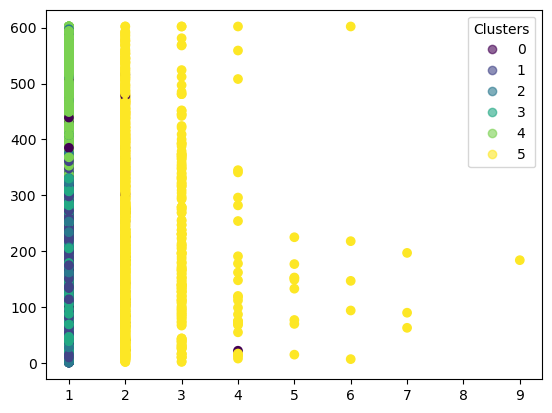

In [102]:
# Visualisation sur les 2 axes nb_commandes et récence du dernier achat

# afficher chaque observation
scatter = plt.scatter(var_brutes['nombre_commandes'], var_brutes['nb_jour_reference'],
    # colorer en utilisant la variable cluster
    c=vars_clust.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

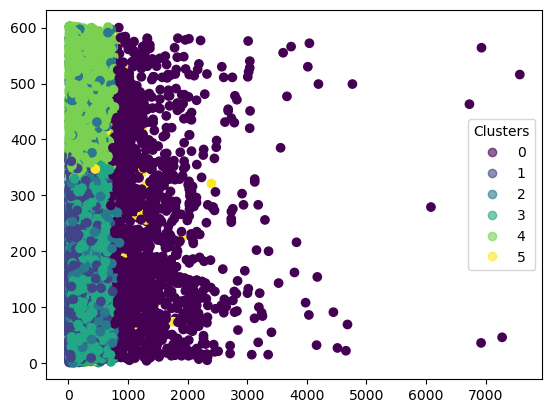

In [103]:
# Visualisation sur les 2 axes montant_commandes et récence du dernier achat

# afficher chaque observation
scatter = plt.scatter(var_brutes['montant_total_commandes'], var_brutes['nb_jour_reference'],
    # colorer en utilisant la variable cluster
    c=vars_clust.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

-- Visualisation des clusters sur la réduction de dimension par TSNE --

In [335]:
# Visualisation
# On applique tSNE aux données scalées :
tsne = manifold.TSNE(n_components=2, init='pca')
X_trans = tsne.fit_transform(X_scaled)

In [336]:
X_trans.shape

(93102, 2)

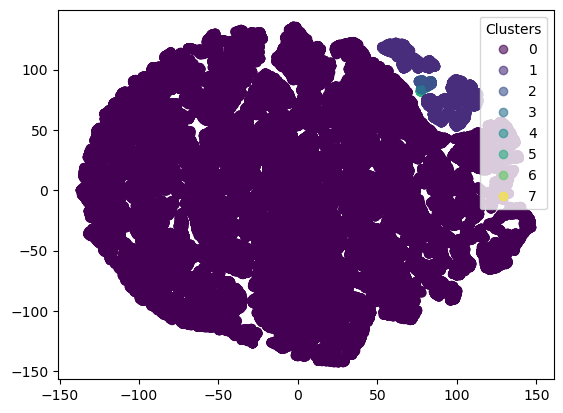

In [337]:
# Visualisation sur les 2 premiers axes de TSNE

# afficher chaque observation
scatter = plt.scatter(X_trans[:, 0], X_trans[:, 1],
    # colorer en utilisant la variable cluster
    c=var_brutes['nombre_commandes'])

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

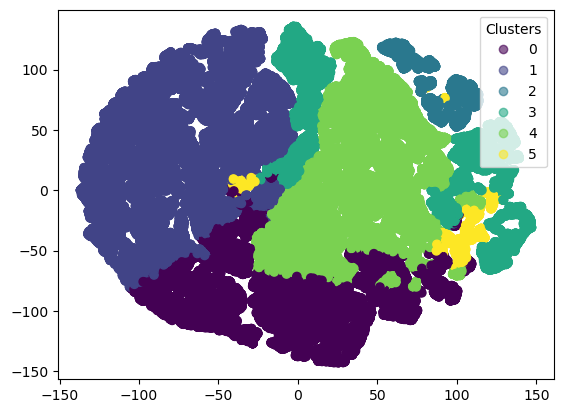

In [357]:
# Visualisation sur les 2 premiers axes de TSNE

# afficher chaque observation
scatter = plt.scatter(X_trans[:, 0], X_trans[:, 1],
    # colorer en utilisant la variable cluster
    c=vars_clust.labels_)

# Légende
handles, labels = scatter.legend_elements(prop="colors", alpha=0.6)
legend = plt.legend(handles, range(len(handles)), title="Clusters")

In [104]:
# On ajoute la variable clusters à mon df d'orinige
my_data['clusters'] = vars_clust.labels_
# On décrit les clusters sur les variables de mon df
stats_by_cluster = my_data.groupby('clusters').agg(['mean','min', 'max', 'median'])
# Afficher les statistiques
stats_by_cluster.head(10)

C:\Users\druar\AppData\Local\Temp\ipykernel_20800\745521569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data['clusters'] = vars_clust.labels_


nombre_commandes                nb_jour_reference                   \
                     mean min max median              mean  min  max median   
clusters                                                                      
0                1.015848   1   4    1.0        237.535129    4  600  217.0   
1                1.000000   1   1    1.0        172.406790    1  374  169.0   
2                1.000000   1   1    1.0        232.900431    1  600  209.0   
3                1.000000   1   1    1.0        161.738392    1  357  159.0   
4                1.000000   1   1    1.0        450.907140  327  602  446.0   
5                2.109783   2   9    2.0        220.285145    2  602  200.0   

         montant_total_commandes                            score_min       \
                            mean     min      max    median      mean  min   
clusters                                                                     
0                    1278.507998  695.61  7571.63  1061.520  4.063314  1.0   
1                     104.486677    9.59   766.32    76.985  4.586647  3.0   
2                     156.508933   13.89   859.02   116.360  1.232239  1.0   
3                     166.843588   20.08   758.32   134.090  4.574392  3.0   
4                     136.092196   12.28   783.00   102.765  4.558972  2.0   
5                     289.816359   35.94  2400.48   224.280  3.835248  1.0   

                     paiement_xfois                   
          max median           mean  min  max median  
clusters                                              
0         5.0    5.0       0.760697  0.0  1.0    1.0  
1         5.0    5.0       0.000000  0.0  0.0    0.0  
2         3.0    1.0       0.541891  0.0  1.0    1.0  
3         5.0    5.0       1.000000  1.0  1.0    1.0  
4         5.0    5.0       0.589197  0.0  1.0    1.0  
5         5.0    4.0       0.644928  0.0  1.0    1.0

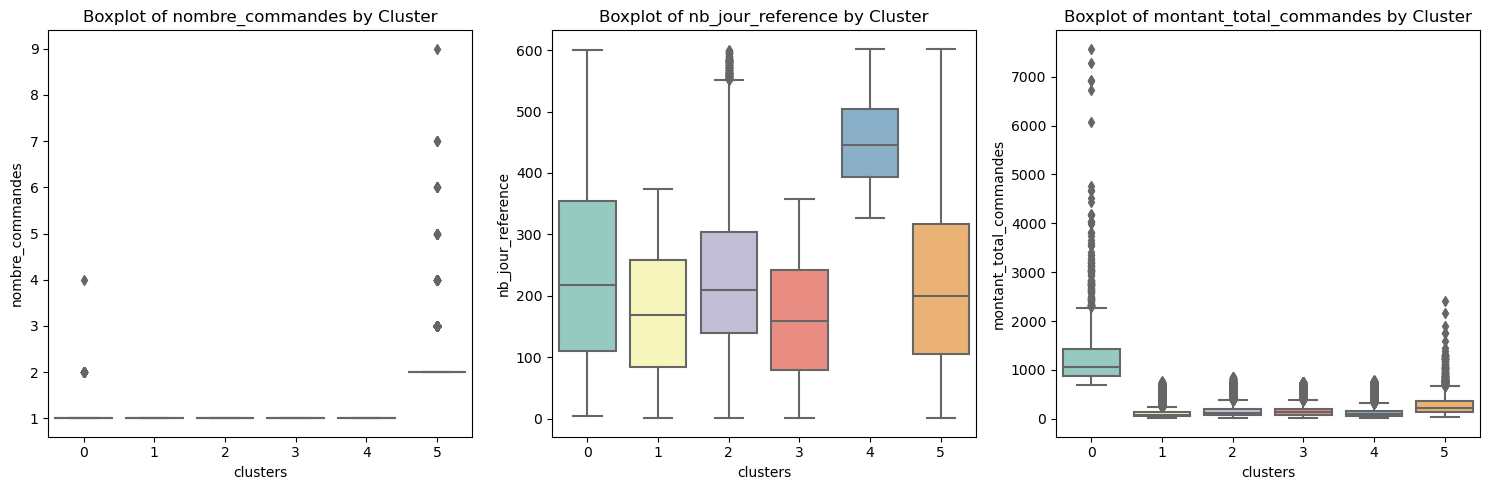

In [105]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(15, 5))

for i, var in enumerate(['nombre_commandes', 'nb_jour_reference', 'montant_total_commandes']):
    plt.subplot(1, 3, i+1)
    sns.boxplot(x='clusters', y=var, data=my_data)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

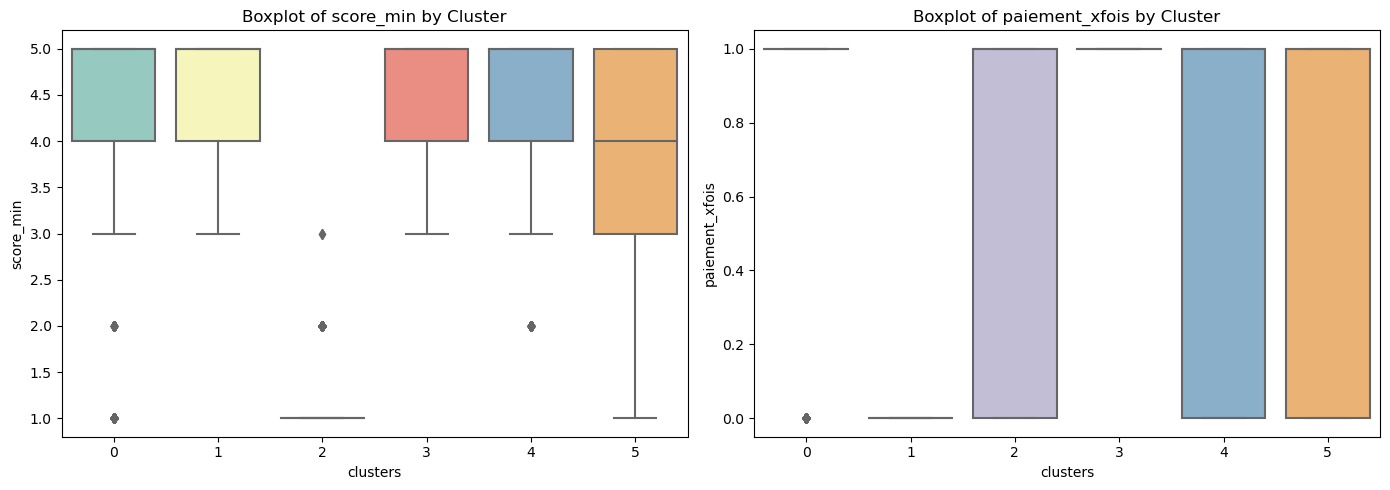

In [106]:
# Créer un boxplot pour chaque variable par cluster
plt.figure(figsize=(14, 5))

for i, var in enumerate(['score_min','paiement_xfois']):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x='clusters', y=var, data=my_data)
    plt.title(f'Boxplot of {var} by Cluster')

plt.tight_layout()
plt.show()

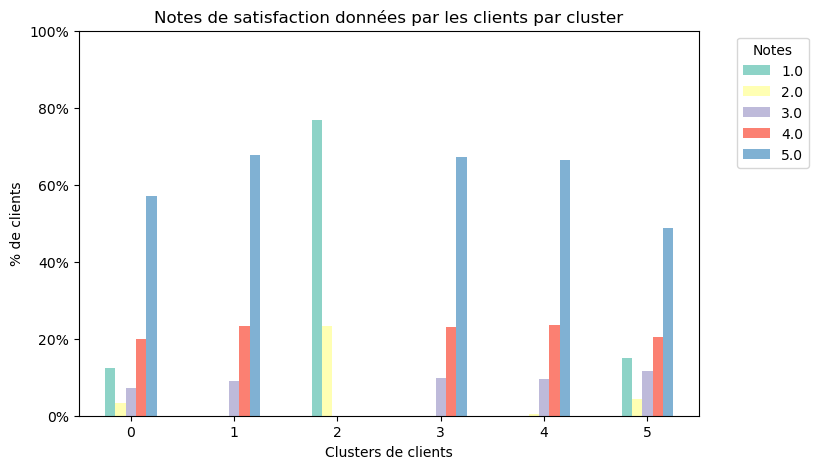

In [118]:
my_data_copy = my_data.copy()

# Arrondir les valeurs de score_min au nombre entier le plus proche
my_data_copy['score_min'] = my_data_copy['score_min'].round(0)

# Calculer la fréquence de chaque score au sein de chaque cluster
freqs = my_data_copy.groupby(['clusters','score_min']).size().unstack(fill_value=0)
freqs = freqs.div(freqs.sum(axis=1), axis=0)  # Convertir en pourcentages

# Tracer les données
ax = freqs.plot(kind='bar', stacked=False, figsize=(8, 5))

# Ajouter des titres et des étiquettes
plt.xticks(rotation=0)
plt.title("Notes de satisfaction données par les clients par cluster", fontsize=12)
plt.xlabel("Clusters de clients")
plt.ylabel("% de clients")
plt.ylim(0, 1)

# Formater l'axe y pour afficher des pourcentages
ticks = plt.yticks()[0]
plt.yticks(ticks, ['{}%'.format(int(tick * 100)) for tick in ticks])

# Ajouter une légende
plt.legend(title='Notes', bbox_to_anchor=(1.05, 1), loc='upper left')

# Afficher le graphique
plt.show()

In [119]:
freqs

score_min       1.0       2.0       3.0       4.0       5.0
clusters                                                   
0          0.123613  0.032752  0.072900  0.199683  0.571051
1          0.000000  0.000000  0.090296  0.233761  0.675943
2          0.767940  0.231880  0.000179  0.000000  0.000000
3          0.000000  0.000000  0.097614  0.231432  0.670953
4          0.000000  0.005417  0.095543  0.234833  0.664208
5          0.149638  0.043478  0.115942  0.204348  0.486594

In [116]:
my_data_copy = my_data.copy()

# Arrondir les valeurs de score_min au nombre entier le plus proche
my_data_copy['nombre_commandes'] = my_data_copy['nombre_commandes'].round(0)

# Calculer la fréquence de chaque score au sein de chaque cluster
freqs = my_data_copy.groupby(['clusters','nombre_commandes']).size().unstack(fill_value=0)
freqs_nombre_commandes = freqs.div(freqs.sum(axis=1), axis=0)  # Convertir en pourcentages

In [117]:
freqs_nombre_commandes

nombre_commandes         1         2         3         4         5         6  \
clusters                                                                       
0                 0.985209  0.014263  0.000000  0.000528  0.000000  0.000000   
1                 1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2                 1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3                 1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4                 1.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
5                 0.000000  0.918478  0.065217  0.009783  0.003261  0.001812   

nombre_commandes         7         9  
clusters                              
0                 0.000000  0.000000  
1                 0.000000  0.000000  
2                 0.000000  0.000000  
3                 0.000000  0.000000  
4                 0.000000  0.000000  
5                 0.001087  0.000362

In [123]:
# montants
montants = my_data_copy.groupby('clusters')['montant_total_commandes'].describe()
montants

count         mean         std     min       25%       50%  \
clusters                                                                 
0          1893.0  1278.507998  654.109059  695.61  870.7000  1061.520   
1         30544.0   104.486677   89.384965    9.59   48.2100    76.985   
2         11148.0   156.508933  132.464060   13.89   67.6200   116.360   
3         27373.0   166.843588  125.136731   20.08   82.1900   134.090   
4         19384.0   136.092196  113.799183   12.28   61.4600   102.765   
5          2760.0   289.816359  225.925277   35.94  145.9375   224.280   

                75%      max  
clusters                      
0         1437.1500  7571.63  
1          128.4275   766.32  
2          194.5025   859.02  
3          205.0800   758.32  
4          168.0075   783.00  
5          354.8450  2400.48

In [124]:
# anciennete
anciennete = my_data_copy.groupby('clusters')['nb_jour_reference'].describe()
anciennete

count        mean         std    min    25%    50%     75%    max
clusters                                                                     
0          1893.0  237.535129  152.267549    4.0  110.0  217.0  354.00  600.0
1         30544.0  172.406790  101.285286    1.0   85.0  169.0  259.00  374.0
2         11148.0  232.900431  136.014278    1.0  139.0  209.0  304.00  600.0
3         27373.0  161.738392   94.009302    1.0   80.0  159.0  242.00  357.0
4         19384.0  450.907140   67.887060  327.0  394.0  446.0  504.00  602.0
5          2760.0  220.285145  142.760496    2.0  106.0  200.0  317.25  602.0

In [125]:
# Arrondir les valeurs de score_min au nombre entier le plus proche
my_data_copy['paiement_xfois'] = my_data_copy['paiement_xfois'].round(0)

# Calculer la fréquence de chaque score au sein de chaque cluster
freqs = my_data_copy.groupby(['clusters','paiement_xfois']).size().unstack(fill_value=0)
freqs_paiement = freqs.div(freqs.sum(axis=1), axis=0)  # Convertir en pourcentages
freqs_paiement

paiement_xfois       0.0       1.0
clusters                          
0               0.239303  0.760697
1               1.000000  0.000000
2               0.458109  0.541891
3               0.000000  1.000000
4               0.410803  0.589197
5               0.355072  0.644928